In [ ]:
pip install rdflib openai pandas

Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install python-dotenv

Note: you may need to restart the kernel to use updated packages.


In [ ]:
from dotenv import load_dotenv
import os
import openai
from rdflib import Graph, Namespace, RDF, RDFS, OWL
from llama_cpp import Llama
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
import re
from rdflib import URIRef

import sys
from langchain_chroma import Chroma
from langchain_community.embeddings import GPT4AllEmbeddings
from langchain_community.llms import LlamaCpp
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough, RunnablePick
from langchain.callbacks.manager import CallbackManager
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler
from langchain import hub
from langchain_core.prompts import PromptTemplate

load_dotenv('openai-key.txt')
api_key = os.getenv("OPENAI_API_KEY")

# Extract Classes and properties from TTL file

In [ ]:
g = Graph()
g.parse("only_events.ttl", format="turtle")

<Graph identifier=N691b142952c54cc588be93e1e44833fa (<class 'rdflib.graph.Graph'>)>

In [ ]:
classes = set() #use set because no duplicates allowed and order does not matter
properties = {}

In [ ]:
for s in g.subjects(RDF.type, OWL.Class):
    label = g.value(s, RDFS.label)
    classes.add((str(s), str(label) if label else s.split("/")[-1]))

In [ ]:
for s in g.subjects(RDF.type, OWL.Class):
    print(s)

http://example.org/Event
http://example.org/Calendar
http://example.org/Location
http://example.org/EventCategory
http://example.org/State


In [ ]:
classes

{('http://example.org/Calendar', 'Calendar'),
 ('http://example.org/Event', 'Event'),
 ('http://example.org/EventCategory', 'Event Category'),
 ('http://example.org/Location', 'Location'),
 ('http://example.org/State', 'State')}

In [ ]:
for s in g.subjects(RDF.type, OWL.ObjectProperty):
    domain = g.value(s, RDFS.domain)
    range_ = g.value(s, RDFS.range)
    label = g.value(s, RDFS.label)
    properties[str(s)] = {
        "type":"ObjectProperty",
        "label":str(label) if label else s.split("/")[-1],
        "domain":str(domain),
        "range":str(range_)
    }

In [ ]:
for s in g.subjects(RDF.type, OWL.ObjectProperty):
    print(s)

http://example.org/eventat
http://example.org/eventon
http://example.org/eventstate
http://example.org/hasCategory


In [ ]:
properties

{'http://example.org/eventat': {'type': 'ObjectProperty',
  'label': 'Event At',
  'domain': 'http://example.org/Location',
  'range': 'http://example.org/Event'},
 'http://example.org/eventon': {'type': 'ObjectProperty',
  'label': 'Event On',
  'domain': 'http://example.org/Calendar',
  'range': 'http://example.org/Event'},
 'http://example.org/eventstate': {'type': 'ObjectProperty',
  'label': 'Event State',
  'domain': 'http://example.org/Event',
  'range': 'http://example.org/State'},
 'http://example.org/hasCategory': {'type': 'ObjectProperty',
  'label': 'Has Category',
  'domain': 'http://example.org/EventCategory',
  'range': 'http://example.org/Event'}}

In [ ]:
for s in g.subjects(RDF.type, OWL.DatatypeProperty):
    domain = g.value(s, RDFS.domain)
    range_ = g.value(s, RDFS.range)
    label = g.value(s, RDFS.label)
    properties[str(s)] = {
        "type":"DatatypeProperty",
        "label":str(label) if label else s.split("/")[-1],
        "domain":str(domain),
        "range":str(range_)
    }

In [ ]:
for s in g.subjects(RDF.type, OWL.DatatypeProperty):
    print(s)

http://example.org/eventcatclassid
http://example.org/eventcatname_it
http://example.org/eventclassid
http://example.org/eventdescr_it
http://example.org/eventimage_url
http://example.org/eventname_it
http://example.org/calendarclassid
http://example.org/day
http://example.org/end_time
http://example.org/start_time
http://example.org/locationclassid
http://example.org/address
http://example.org/statecode
http://example.org/statename


In [ ]:
properties

{'http://example.org/eventat': {'type': 'ObjectProperty',
  'label': 'Event At',
  'domain': 'http://example.org/Location',
  'range': 'http://example.org/Event'},
 'http://example.org/eventon': {'type': 'ObjectProperty',
  'label': 'Event On',
  'domain': 'http://example.org/Calendar',
  'range': 'http://example.org/Event'},
 'http://example.org/eventstate': {'type': 'ObjectProperty',
  'label': 'Event State',
  'domain': 'http://example.org/Event',
  'range': 'http://example.org/State'},
 'http://example.org/hasCategory': {'type': 'ObjectProperty',
  'label': 'Has Category',
  'domain': 'http://example.org/EventCategory',
  'range': 'http://example.org/Event'},
 'http://example.org/eventcatclassid': {'type': 'DatatypeProperty',
  'label': 'Eventcat Classid',
  'domain': 'http://example.org/EventCategory',
  'range': 'http://www.w3.org/2001/XMLSchema#string'},
 'http://example.org/eventcatname_it': {'type': 'DatatypeProperty',
  'label': 'Eventcat Name',
  'domain': 'http://example.or

# Create one document per class and property

In [ ]:
docs = []

for uri, label in classes:
    docs.append(f"Class: {label} URI: {uri}")

In [ ]:
docs

['Class: Event Category URI: http://example.org/EventCategory',
 'Class: Location URI: http://example.org/Location',
 'Class: State URI: http://example.org/State',
 'Class: Event URI: http://example.org/Event',
 'Class: Calendar URI: http://example.org/Calendar']

In [ ]:
for uri, prop in properties.items():
    docs.append(f"Property: {prop['label']} URI: {uri} Type: {prop['type']} Domain: {prop['domain']} Range: {prop['range']}")


In [ ]:
docs

['Class: Event Category URI: http://example.org/EventCategory',
 'Class: Location URI: http://example.org/Location',
 'Class: State URI: http://example.org/State',
 'Class: Event URI: http://example.org/Event',
 'Class: Calendar URI: http://example.org/Calendar',
 'Property: Event At URI: http://example.org/eventat Type: ObjectProperty Domain: http://example.org/Location Range: http://example.org/Event',
 'Property: Event On URI: http://example.org/eventon Type: ObjectProperty Domain: http://example.org/Calendar Range: http://example.org/Event',
 'Property: Event State URI: http://example.org/eventstate Type: ObjectProperty Domain: http://example.org/Event Range: http://example.org/State',
 'Property: Has Category URI: http://example.org/hasCategory Type: ObjectProperty Domain: http://example.org/EventCategory Range: http://example.org/Event',
 'Property: Eventcat Classid URI: http://example.org/eventcatclassid Type: DatatypeProperty Domain: http://example.org/EventCategory Range: http

# Ask LLM if class/property is relevant

In [ ]:
question = "What are the names of the events happen on 2015-12-12?"

relevant_docs = []

for doc in docs:
    prompt = f"""You are a SPARQL expert. Given the user question: "{question}" Is the following class/property relevant? {doc} Answer only YES or NO."""

    response = openai.ChatCompletion.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": prompt}],
        temperature=0,
        api_key=api_key
    )

    answer = response["choices"][0]["message"]["content"].strip().upper()
    if "YES" in answer:
        relevant_docs.append(doc)

RateLimitError: You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.

In [ ]:
pip install llama-cpp-python

Note: you may need to restart the kernel to use updated packages.


In [ ]:
llm = Llama(
    model_path="llama-2-7b-chat.Q8_0.gguf",
    n_ctx=2048
)

llama_model_loader: loaded meta data with 19 key-value pairs and 291 tensors from llama-2-7b-chat.Q8_0.gguf (version GGUF V2)
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.name str              = LLaMA v2
llama_model_loader: - kv   2:                       llama.context_length u32              = 4096
llama_model_loader: - kv   3:                     llama.embedding_length u32              = 4096
llama_model_loader: - kv   4:                          llama.block_count u32              = 32
llama_model_loader: - kv   5:                  llama.feed_forward_length u32              = 11008
llama_model_loader: - kv   6:                 llama.rope.dimension_count u32              = 128
llama_model_loader: - kv   7:                 llama.attention.head_count u32              = 32

In [ ]:
question = "What are the names of the events happen on 2015-12-12?"
relevant_docs = []

for doc in docs:
    prompt = f"""You are a SPARQL expert. Given the user question: "{question}" Is the following class/property relevant? {doc} Answer only YES or NO."""

    response = llm(prompt, max_tokens=50, temperature=0.1)
    answer = response['choices'][0]['text'].strip().upper()

    if "YES" in answer:
        relevant_docs.append(doc)

Llama.generate: 1 prefix-match hit, remaining 61 prompt tokens to eval
llama_perf_context_print:        load time =    5324.57 ms
llama_perf_context_print: prompt eval time =       0.00 ms /    61 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    15 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =   14732.92 ms /    76 tokens
Llama.generate: 46 prefix-match hit, remaining 16 prompt tokens to eval
llama_perf_context_print:        load time =    5324.57 ms
llama_perf_context_print: prompt eval time =       0.00 ms /    16 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    49 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =   37725.87 ms /    65 tokens
Llama.generate: 46 prefix-match hit, remaining 16 prompt tokens to eval
llama_perf_cont

In [ ]:
relevant_docs

['Class: Calendar URI: http://example.org/Calendar',
 'Class: Event URI: http://example.org/Event',
 'Property: Event State URI: http://example.org/eventstate Type: ObjectProperty Domain: http://example.org/Event Range: http://example.org/State',
 'Property: EndTime URI: http://example.org/end_time Type: DatatypeProperty Domain: http://example.org/Calendar Range: http://www.w3.org/2001/XMLSchema#string',
 'Property: Location Class ID URI: http://example.org/locationclassid Type: DatatypeProperty Domain: http://example.org/Location Range: http://www.w3.org/2001/XMLSchema#string']

Properties are not capturing well! But write in a function below and try other questions

In [ ]:
question_doc_evaluations = []

def get_relevant_docs(question, docs, llm):
    relevant_docs = []

    for doc in docs:
        prompt = (
            f'You are a SPARQL expert. Given the user question: "{question}" '
            f'Is the following class/property relevant?\n\n{doc}\n\n'
            "Answer only YES or NO."
        )

        response = llm(prompt, max_tokens=50, temperature=0.1)

        if isinstance(response, dict) and 'choices' in response:
            answer = response['choices'][0]['text'].strip().upper()
        else:
            answer = str(response).strip().upper()

        question_doc_evaluations.append({
            "question": question,
            "document": doc,
            "answer": answer
        })

        if "YES" in answer:
            relevant_docs.append(doc)

    return relevant_docs


In [ ]:
question_1 = "What are the names of the events happen on 2015-12-12?"

relevant_docs = get_relevant_docs(question_1, docs, llm)

Llama.generate: 4 prefix-match hit, remaining 62 prompt tokens to eval
llama_perf_context_print:        load time =    8167.94 ms
llama_perf_context_print: prompt eval time =       0.00 ms /    62 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    23 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =   23928.70 ms /    85 tokens
Llama.generate: 48 prefix-match hit, remaining 18 prompt tokens to eval
llama_perf_context_print:        load time =    8167.94 ms
llama_perf_context_print: prompt eval time =       0.00 ms /    18 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    49 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =   39887.39 ms /    67 tokens
Llama.generate: 48 prefix-match hit, remaining 18 prompt tokens to eval
llama_perf_cont

In [ ]:
relevant_docs

['Class: Location URI: http://example.org/Location',
 'Class: Calendar URI: http://example.org/Calendar',
 'Property: Event On URI: http://example.org/eventon Type: ObjectProperty Domain: http://example.org/Calendar Range: http://example.org/Event',
 'Property: Has Category URI: http://example.org/hasCategory Type: ObjectProperty Domain: http://example.org/EventCategory Range: http://example.org/Event',
 'Property: Eventcat Name URI: http://example.org/eventcatname_it Type: DatatypeProperty Domain: http://example.org/EventCategory Range: http://www.w3.org/2001/XMLSchema#string',
 'Property: Event Name URI: http://example.org/eventname_it Type: DatatypeProperty Domain: http://example.org/Event Range: http://www.w3.org/2001/XMLSchema#string',
 'Property: EndTime URI: http://example.org/end_time Type: DatatypeProperty Domain: http://example.org/Calendar Range: http://www.w3.org/2001/XMLSchema#string',
 'Property: StartTime URI: http://example.org/start_time Type: DatatypeProperty Domain: 

In [ ]:
question_doc_evaluations

[{'question': 'What are the names of the events happen on 2015-12-12?',
  'document': 'Class: Location URI: http://example.org/Location',
  'answer': 'IF YOU ANSWER YES, PROVIDE THE RELEVANT CLASS/PROPERTY. IF YOU ANSWER NO, PLEASE EXPLAIN WHY.'},
 {'question': 'What are the names of the events happen on 2015-12-12?',
  'document': 'Class: Calendar URI: http://example.org/Calendar',
  'answer': 'IF YES, PLEASE EXPLAIN HOW.\n\nNO, THE CLASS CALENDAR IS NOT RELEVANT TO ANSWER THE USER QUESTION BECAUSE THE USER ASKED FOR EVENTS THAT HAPPENED ON A SPECIFIC DATE (2015-12-12) BUT THE CLASS CALENDAR'},
 {'question': 'What are the names of the events happen on 2015-12-12?',
  'document': 'Class: Event URI: http://example.org/Event',
  'answer': ''},
 {'question': 'What are the names of the events happen on 2015-12-12?',
  'document': 'Class: State URI: http://example.org/State',
  'answer': ''},
 {'question': 'What are the names of the events happen on 2015-12-12?',
  'document': 'Class: Event

#### Seperate the docs to classes and properties and check first with classes then properties

In [ ]:
classes_only = []
properties_only = []

In [ ]:
for doc in docs:
        if doc.startswith('Class'):
            classes_only.append(doc)
        elif doc.startswith('Property'):
            properties_only.append(doc)

In [ ]:
classes_only

['Class: Event Category URI: http://example.org/EventCategory',
 'Class: Location URI: http://example.org/Location',
 'Class: State URI: http://example.org/State',
 'Class: Event URI: http://example.org/Event',
 'Class: Calendar URI: http://example.org/Calendar']

In [ ]:
relevant_classes = []
questions_responses = []

def ask_relevant_classes(question, docs, llm):

    relevant_classes = []

    for doc in docs:
            prompt = f"""Generate a SPARQL query that matches the provided document from RDF schema. : "{question}" Is the following class relevant? {doc} Answer only YES or NO."""
            response = llm(prompt, max_tokens=50, temperature=0.1)

            #answer = response.strip().upper()
            answer = response['choices'][0]['text'].strip().upper()

            if "YES" in answer:
               relevant_classes.append(doc)

    questions_responses.append({"question": question,"response": relevant_classes})

    return relevant_classes

In [ ]:
question_1 = "What are the names of the events happening on 2015-12-12?"

relevant_classes = ask_relevant_classes(question_1, classes_only, llm)
print(f"Relevant classes: {relevant_classes}") #mistakenly rerun

Llama.generate: 1 prefix-match hit, remaining 66 prompt tokens to eval
llama_perf_context_print:        load time =    4108.75 ms
llama_perf_context_print: prompt eval time =       0.00 ms /    66 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    49 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =   41398.28 ms /   115 tokens
Llama.generate: 49 prefix-match hit, remaining 16 prompt tokens to eval
llama_perf_context_print:        load time =    4108.75 ms
llama_perf_context_print: prompt eval time =       0.00 ms /    16 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     2 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =    2825.13 ms /    18 tokens
Llama.generate: 49 prefix-match hit, remaining 16 prompt tokens to eval
llama_perf_cont

Relevant classes: ['Class: Event URI: http://example.org/Event']


In [ ]:
question_2 = "What are the names and addresses of the events belong to 'Kids' category?"

relevant_classes = ask_relevant_classes(question_2, classes_only, llm)
print(f"Relevant classes: {relevant_classes}")

Llama.generate: 24 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    4108.75 ms
llama_perf_context_print: prompt eval time =       0.00 ms /    39 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    49 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =   38712.54 ms /    88 tokens
Llama.generate: 45 prefix-match hit, remaining 16 prompt tokens to eval
llama_perf_context_print:        load time =    4108.75 ms
llama_perf_context_print: prompt eval time =       0.00 ms /    16 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    49 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =   37477.87 ms /    65 tokens
Llama.generate: 45 prefix-match hit, remaining 16 prompt tokens to eval
llama_perf_con

Relevant classes: ['Class: Location URI: http://example.org/Location', 'Class: Event URI: http://example.org/Event']


In [ ]:
question_3 = "What are the locations of the events happen on 2015-12-12"

relevant_classes = ask_relevant_classes(question_3, classes_only, llm)
print(f"Relevant classes: {relevant_classes}")

Llama.generate: 18 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    8167.94 ms
llama_perf_context_print: prompt eval time =       0.00 ms /    42 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     8 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =    9471.36 ms /    50 tokens
Llama.generate: 44 prefix-match hit, remaining 16 prompt tokens to eval
llama_perf_context_print:        load time =    8167.94 ms
llama_perf_context_print: prompt eval time =       0.00 ms /    16 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    13 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =   12233.13 ms /    29 tokens
Llama.generate: 44 prefix-match hit, remaining 16 prompt tokens to eval
llama_perf_con

Relevant classes: ['Class: Event URI: http://example.org/Event', 'Class: State URI: http://example.org/State', 'Class: Event Category URI: http://example.org/EventCategory']


In [ ]:
question_4 = "What are the events scheduled to start at 11.30? "

relevant_classes = ask_relevant_classes(question_4, classes_only, llm)
print(f"Relevant classes: {relevant_classes}")

Llama.generate: 18 prefix-match hit, remaining 37 prompt tokens to eval
llama_perf_context_print:        load time =    8167.94 ms
llama_perf_context_print: prompt eval time =       0.00 ms /    37 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     4 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =    6324.92 ms /    41 tokens
Llama.generate: 39 prefix-match hit, remaining 16 prompt tokens to eval
llama_perf_context_print:        load time =    8167.94 ms
llama_perf_context_print: prompt eval time =       0.00 ms /    16 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     6 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =    6414.78 ms /    22 tokens
Llama.generate: 39 prefix-match hit, remaining 16 prompt tokens to eval
llama_perf_con

Relevant classes: ['Class: Location URI: http://example.org/Location', 'Class: Calendar URI: http://example.org/Calendar', 'Class: State URI: http://example.org/State']


In [ ]:
question_5 = "Can you give the event names and their status?"

relevant_classes = ask_relevant_classes(question_5, classes_only, llm)
print(f"Relevant classes: {relevant_classes}")

Llama.generate: 15 prefix-match hit, remaining 34 prompt tokens to eval
llama_perf_context_print:        load time =    8167.94 ms
llama_perf_context_print: prompt eval time =       0.00 ms /    34 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    49 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =   47137.13 ms /    83 tokens
Llama.generate: 33 prefix-match hit, remaining 16 prompt tokens to eval
llama_perf_context_print:        load time =    8167.94 ms
llama_perf_context_print: prompt eval time =       0.00 ms /    16 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    12 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =   12041.00 ms /    28 tokens
Llama.generate: 33 prefix-match hit, remaining 16 prompt tokens to eval
llama_perf_con

Relevant classes: ['Class: Calendar URI: http://example.org/Calendar', 'Class: State URI: http://example.org/State']


In [ ]:
questions_responses

[{'question': 'What are the names of the events happening on 2015-12-12?',
  'response': ['Class: Location URI: http://example.org/Location']},
 {'question': 'What are the names of the events happening on 2015-12-12?',
  'response': ['Class: Calendar URI: http://example.org/Calendar',
   'Class: Event URI: http://example.org/Event',
   'Class: State URI: http://example.org/State',
   'Class: Event Category URI: http://example.org/EventCategory']},
 {'question': "What are the names and addresses of the events belong to 'Kids' category?",
  'response': ['Class: Event URI: http://example.org/Event',
   'Class: Event Category URI: http://example.org/EventCategory']},
 {'question': 'What are the locations of the events happen on 2015-12-12',
  'response': ['Class: Event URI: http://example.org/Event',
   'Class: State URI: http://example.org/State',
   'Class: Event Category URI: http://example.org/EventCategory']},
 {'question': 'What are the events scheduled to start at 11.30? ',
  'respo

In [ ]:
relevant_properties = {}
questions_responses_prop = []

def ask_relevant_properties(question, relevant_classes, docs, llm):

    class_to_properties = {}

    for cls in relevant_classes:
        class_name = cls.split('/')[1].strip()

        relevant_props = []

        for doc in docs:
                prompt = f"""You are a SPARQL expert. Given the user question: "{question}" Is the following property relevant for class {class_name}? {doc} Answer only YES or NO."""
                response = llm(prompt, max_tokens=50, temperature=0.1)
                answer = response['choices'][0]['text'].strip().upper()

                if "YES" in answer:
                    relevant_props.append(doc)

        class_to_properties[class_name] = relevant_props

    questions_responses_prop.append({"question": question,"relevant_classes": relevant_classes,"response": relevant_props})

    return class_to_properties


In [ ]:
question_1 = "What are the names of the events happening on 2015-12-12?"

relevant_classes = ask_relevant_classes(question_1, classes_only, llm)
#print(f"Relevant classes: {relevant_classes}")
class_properties = ask_relevant_properties(question_1, relevant_classes, properties_only, llm)
#print(f"Relevant properties: {class_properties}")   #took more thank one hour, so stopped

In [ ]:
relevant_properties = {}
questions_responses_prop = []

def ask_relevant_properties(question, relevant_classes, docs, llm):

    class_to_properties = {}

    for cls in relevant_classes:
        class_name = cls.split('/')[1].strip()

        relevant_props = []

        for doc in docs:
                prompt = f"""You are a SPARQL expert. Given the user question: "{question}" Is the following property relevant for class {class_name}? {doc} Answer only YES or NO."""
                response = llm(prompt, max_tokens=50, temperature=0.1)
                answer = response.strip().upper()

                if "YES" in answer:
                    relevant_props.append(doc)

        class_to_properties[class_name] = relevant_props

    questions_responses_prop.append({"question": question,"response": relevant_props})

    return class_to_properties


In [ ]:
question_1 = "What are the names of the events happening on 2015-12-12?"

relevant_classes = ask_relevant_classes(question_1, classes_only, llm)

Llama.generate: 49 prefix-match hit, remaining 16 prompt tokens to eval
llama_perf_context_print:        load time =   22856.20 ms
llama_perf_context_print: prompt eval time =       0.00 ms /    16 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    49 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =   42467.91 ms /    65 tokens
Llama.generate: 49 prefix-match hit, remaining 16 prompt tokens to eval
llama_perf_context_print:        load time =   22856.20 ms
llama_perf_context_print: prompt eval time =       0.00 ms /    16 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    49 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =   42837.26 ms /    65 tokens
Llama.generate: 49 prefix-match hit, remaining 16 prompt tokens to eval
llama_perf_con

In [ ]:
relevant_classes

['Class: Calendar URI: http://example.org/Calendar']

In [ ]:
class_properties = ask_relevant_properties(question_1, relevant_classes, properties_only, llm)
print(f"Relevant properties: {class_properties}")

Llama.generate: 1 prefix-match hit, remaining 85 prompt tokens to eval
llama_perf_context_print:        load time =   22856.20 ms
llama_perf_context_print: prompt eval time =       0.00 ms /    85 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     6 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =   11175.13 ms /    91 tokens
Llama.generate: 47 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =   22856.20 ms
llama_perf_context_print: prompt eval time =       0.00 ms /    39 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    49 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =   49050.14 ms /    88 tokens
Llama.generate: 47 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_cont

Relevant properties: {'': ['Property: Event State URI: http://example.org/eventstate Type: ObjectProperty Domain: http://example.org/Event Range: http://example.org/State', 'Property: Has Category URI: http://example.org/hasCategory Type: ObjectProperty Domain: http://example.org/EventCategory Range: http://example.org/Event', 'Property: Eventcat Name URI: http://example.org/eventcatname_it Type: DatatypeProperty Domain: http://example.org/EventCategory Range: http://www.w3.org/2001/XMLSchema#string', 'Property: Event Class ID URI: http://example.org/eventclassid Type: DatatypeProperty Domain: http://example.org/Event Range: http://www.w3.org/2001/XMLSchema#string', 'Property: Event Description (IT) URI: http://example.org/eventdescr_it Type: DatatypeProperty Domain: http://example.org/Event Range: http://www.w3.org/2001/XMLSchema#string', 'Property: Event Name URI: http://example.org/eventname_it Type: DatatypeProperty Domain: http://example.org/Event Range: http://www.w3.org/2001/XML

In [ ]:
question_1 = "What are the names of the events happening on 2015-12-12?"

class_properties = ask_relevant_properties(question_1, relevant_classes, properties_only, llm)
print(f"Relevant properties: {class_properties}")

Llama.generate: 85 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    8167.94 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    50 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =   39706.04 ms /    51 tokens
Llama.generate: 47 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    8167.94 ms
llama_perf_context_print: prompt eval time =       0.00 ms /    39 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    49 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =   41688.37 ms /    88 tokens
Llama.generate: 47 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_cont

Relevant properties: {'': ['Property: Event At URI: http://example.org/eventat Type: ObjectProperty Domain: http://example.org/Location Range: http://example.org/Event', 'Property: Event On URI: http://example.org/eventon Type: ObjectProperty Domain: http://example.org/Calendar Range: http://example.org/Event', 'Property: Event State URI: http://example.org/eventstate Type: ObjectProperty Domain: http://example.org/Event Range: http://example.org/State', 'Property: Has Category URI: http://example.org/hasCategory Type: ObjectProperty Domain: http://example.org/EventCategory Range: http://example.org/Event', 'Property: Event Class ID URI: http://example.org/eventclassid Type: DatatypeProperty Domain: http://example.org/Event Range: http://www.w3.org/2001/XMLSchema#string', 'Property: Event Name URI: http://example.org/eventname_it Type: DatatypeProperty Domain: http://example.org/Event Range: http://www.w3.org/2001/XMLSchema#string', 'Property: StartTime URI: http://example.org/start_ti

In [ ]:
question_2 = "What are the names and addresses of the events belong to 'Kids' category?"

class_properties = ask_relevant_properties(question_2, relevant_classes, properties_only, llm)
print(f"Relevant properties: {class_properties}")

Llama.generate: 19 prefix-match hit, remaining 63 prompt tokens to eval
llama_perf_context_print:        load time =    8167.94 ms
llama_perf_context_print: prompt eval time =       0.00 ms /    63 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    49 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =   43204.96 ms /   112 tokens
Llama.generate: 43 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    8167.94 ms
llama_perf_context_print: prompt eval time =       0.00 ms /    39 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    49 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =   41622.62 ms /    88 tokens
Llama.generate: 43 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_con

Relevant properties: {'': ['Property: Event At URI: http://example.org/eventat Type: ObjectProperty Domain: http://example.org/Location Range: http://example.org/Event', 'Property: Event On URI: http://example.org/eventon Type: ObjectProperty Domain: http://example.org/Calendar Range: http://example.org/Event', 'Property: Has Category URI: http://example.org/hasCategory Type: ObjectProperty Domain: http://example.org/EventCategory Range: http://example.org/Event', 'Property: Event Class ID URI: http://example.org/eventclassid Type: DatatypeProperty Domain: http://example.org/Event Range: http://www.w3.org/2001/XMLSchema#string', 'Property: Event Description (IT) URI: http://example.org/eventdescr_it Type: DatatypeProperty Domain: http://example.org/Event Range: http://www.w3.org/2001/XMLSchema#string', 'Property: Event Image URL URI: http://example.org/eventimage_url Type: DatatypeProperty Domain: http://example.org/Event Range: http://www.w3.org/2001/XMLSchema#string', 'Property: Star

In [ ]:
question_3 = "What are the locations of the events happen on 2015-12-12"

class_properties = ask_relevant_properties(question_3, relevant_classes, properties_only, llm)
print(f"Relevant properties: {class_properties}")

Llama.generate: 18 prefix-match hit, remaining 68 prompt tokens to eval
llama_perf_context_print:        load time =    8167.94 ms
llama_perf_context_print: prompt eval time =       0.00 ms /    68 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    49 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =   45578.92 ms /   117 tokens
Llama.generate: 47 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_context_print:        load time =    8167.94 ms
llama_perf_context_print: prompt eval time =       0.00 ms /    39 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    49 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =   43571.71 ms /    88 tokens
Llama.generate: 47 prefix-match hit, remaining 39 prompt tokens to eval
llama_perf_con

Relevant properties: {'': ['Property: Event At URI: http://example.org/eventat Type: ObjectProperty Domain: http://example.org/Location Range: http://example.org/Event', 'Property: Event On URI: http://example.org/eventon Type: ObjectProperty Domain: http://example.org/Calendar Range: http://example.org/Event', 'Property: Event State URI: http://example.org/eventstate Type: ObjectProperty Domain: http://example.org/Event Range: http://example.org/State', 'Property: Has Category URI: http://example.org/hasCategory Type: ObjectProperty Domain: http://example.org/EventCategory Range: http://example.org/Event', 'Property: Eventcat Name URI: http://example.org/eventcatname_it Type: DatatypeProperty Domain: http://example.org/EventCategory Range: http://www.w3.org/2001/XMLSchema#string', 'Property: Event Class ID URI: http://example.org/eventclassid Type: DatatypeProperty Domain: http://example.org/Event Range: http://www.w3.org/2001/XMLSchema#string', 'Property: Event Description (IT) URI: 

In [ ]:
questions_responses_prop

[{'question': 'What are the names of the events happening on 2015-12-12?',
  'response': ['Property: Event At URI: http://example.org/eventat Type: ObjectProperty Domain: http://example.org/Location Range: http://example.org/Event',
   'Property: Event On URI: http://example.org/eventon Type: ObjectProperty Domain: http://example.org/Calendar Range: http://example.org/Event',
   'Property: Event State URI: http://example.org/eventstate Type: ObjectProperty Domain: http://example.org/Event Range: http://example.org/State',
   'Property: Has Category URI: http://example.org/hasCategory Type: ObjectProperty Domain: http://example.org/EventCategory Range: http://example.org/Event',
   'Property: Event Class ID URI: http://example.org/eventclassid Type: DatatypeProperty Domain: http://example.org/Event Range: http://www.w3.org/2001/XMLSchema#string',
   'Property: Event Name URI: http://example.org/eventname_it Type: DatatypeProperty Domain: http://example.org/Event Range: http://www.w3.org

### Try using RAG below

First retrieve the relevant classes and properties using RAG retriever and then pass them to LLM using a loop and ask whether each class/property is relevant or not

In [ ]:
model_name = "all-MiniLM-L6-v2.gguf2.f16.gguf"
gpt4all_kwargs = {"allow_download": "True"}
embeddings = GPT4AllEmbeddings(model_name=model_name, gpt4all_kwargs=gpt4all_kwargs)

In [ ]:
vectorstore = Chroma.from_texts(texts=docs, embedding=embeddings)

In [ ]:
llm = LlamaCpp(
    model_path="llama-2-7b-chat.Q8_0.gguf",
    n_gpu_layers=-1,
    n_batch=512,
    n_ctx=2048,
    f16_kv=True,
    verbose=True,
)

llama_model_loader: loaded meta data with 19 key-value pairs and 291 tensors from llama-2-7b-chat.Q8_0.gguf (version GGUF V2)
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.name str              = LLaMA v2
llama_model_loader: - kv   2:                       llama.context_length u32              = 4096
llama_model_loader: - kv   3:                     llama.embedding_length u32              = 4096
llama_model_loader: - kv   4:                          llama.block_count u32              = 32
llama_model_loader: - kv   5:                  llama.feed_forward_length u32              = 11008
llama_model_loader: - kv   6:                 llama.rope.dimension_count u32              = 128
llama_model_loader: - kv   7:                 llama.attention.head_count u32              = 32

In [ ]:
retriever = vectorstore.as_retriever()

In [ ]:
question = "What are the names of the events that happen on 2015-12-12?"
retrieved_docs = retriever.invoke(question)

In [ ]:
retrieved_docs

[Document(id='e002b501-7672-41e4-bb47-745cf2cfd7c9', metadata={}, page_content='Class: Event URI: http://example.org/Event'),
 Document(id='a4dd52df-23c6-417b-9124-5aeb5ce200be', metadata={}, page_content='Property: Event On URI: http://example.org/eventon Type: ObjectProperty Domain: http://example.org/Calendar Range: http://example.org/Event'),
 Document(id='05d233bd-a7da-403e-afb8-9c012f43e9f6', metadata={}, page_content='Class: Event Category URI: http://example.org/EventCategory'),
 Document(id='190c9272-2a41-465f-844c-fd524b1fa198', metadata={}, page_content='Property: Event At URI: http://example.org/eventat Type: ObjectProperty Domain: http://example.org/Location Range: http://example.org/Event')]

### Retrieval is not working well

In [ ]:
yes_docs = []
no_docs = []

In [ ]:
for i, doc in enumerate(retrieved_docs):
    custom_prompt = f"""You are a SPARQL expert. Given the user question: "{question}",
is the following class/property relevant?

### Class/Property:
{doc.page_content}

### Answer (only YES or NO):"""

    response = llm.invoke(custom_prompt)
    decision = response.strip().upper()

    result = {
        "index": i + 1,
        "doc": doc.page_content.strip(),
        "response": decision
    }

    if "YES" in decision:
        yes_docs.append(result)
    else:
        no_docs.append(result)

llama_perf_context_print:        load time =    4775.18 ms
llama_perf_context_print: prompt eval time =       0.00 ms /    80 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    15 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =   16500.62 ms /    95 tokens
Llama.generate: 57 prefix-match hit, remaining 47 prompt tokens to eval
llama_perf_context_print:        load time =    4775.18 ms
llama_perf_context_print: prompt eval time =       0.00 ms /    47 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    33 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =   27775.38 ms /    80 tokens
Llama.generate: 57 prefix-match hit, remaining 25 prompt tokens to eval
llama_perf_context_print:        load time =    4775.18 ms
llama_perf_context_print: p

In [ ]:
yes_docs

[{'index': 4,
  'doc': 'Property: Event At URI: http://example.org/eventat Type: ObjectProperty Domain: http://example.org/Location Range: http://example.org/Event',
  'response': 'YES'}]

##### Since this does not work well, just follow the langchain pipeline without the loop checking one by one

In [ ]:
rag_prompt = PromptTemplate.from_template(
    "Given RDF schema below, extract only the relevant classes and properties that match the following question.\n"
    "### RDF Schema:\n"
    "{context}\n\n"
    "### Question:\n"
    "{question}\n\n"
    "### Answer (List only the relevant classes and properties, separated by commas):\n"
)

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

retriever = vectorstore.as_retriever()

qa_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | rag_prompt
    | llm
    | StrOutputParser()
)

question = "What are the names of the events that happen on 2015-12-12?"
response = qa_chain.invoke(question)

print("Relevant Classes and Properties:")
print(response)


Llama.generate: 1 prefix-match hit, remaining 181 prompt tokens to eval
llama_perf_context_print:        load time =    4775.18 ms
llama_perf_context_print: prompt eval time =       0.00 ms /   181 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    30 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =   32851.37 ms /   211 tokens


Relevant Classes and Properties:
Event, EventOn, 2015-12-12
EventCategory, EventAt, http://example.org/Calendar


Not working well!

### Try Graph Traversal

In [ ]:
ttl_graph = Graph()
ttl_graph.parse("only_events.ttl", format="turtle")

<Graph identifier=N2597b14458d14adba490849834cf5d88 (<class 'rdflib.graph.Graph'>)>

In [ ]:
G = nx.MultiDiGraph()  #a multi edge directed graph

In [ ]:
for s in ttl_graph.subjects(RDF.type, OWL.Class):
    label = ttl_graph.value(s, RDFS.label)
    G.add_node(str(s), type="Class", label=str(label) if label else s.split("/")[-1])

In [ ]:
for s in ttl_graph.subjects(RDF.type, OWL.ObjectProperty):
    domain = ttl_graph.value(s, RDFS.domain)
    range_ = ttl_graph.value(s, RDFS.range)
    label = ttl_graph.value(s, RDFS.label)
    prop_label = str(label) if label else s.split("/")[-1]
    if domain and range_:
        G.add_edge(str(domain), str(range_), type="ObjectProperty", label=prop_label)

In [ ]:
for s in ttl_graph.subjects(RDF.type, OWL.DatatypeProperty):
    domain = ttl_graph.value(s, RDFS.domain)
    range_ = ttl_graph.value(s, RDFS.range)
    label = ttl_graph.value(s, RDFS.label)
    prop_label = str(label) if label else s.split("/")[-1]
    if domain:
        G.add_edge(str(domain), str(range_) if range_ else "Literal", type="DatatypeProperty", label=prop_label)

In [ ]:
for s in ttl_graph.subjects(RDF.type, OWL.DatatypeProperty):
    print(s)

http://example.org/eventcatclassid
http://example.org/eventcatname_it
http://example.org/eventclassid
http://example.org/eventdescr_it
http://example.org/eventimage_url
http://example.org/eventname_it
http://example.org/calendarclassid
http://example.org/day
http://example.org/end_time
http://example.org/start_time
http://example.org/locationclassid
http://example.org/address
http://example.org/statecode
http://example.org/statename


In [ ]:
combined_labels = defaultdict(list)
for u, v, k, d in G.edges(data=True, keys=True):
    combined_labels[(u, v)].append(d['label'])

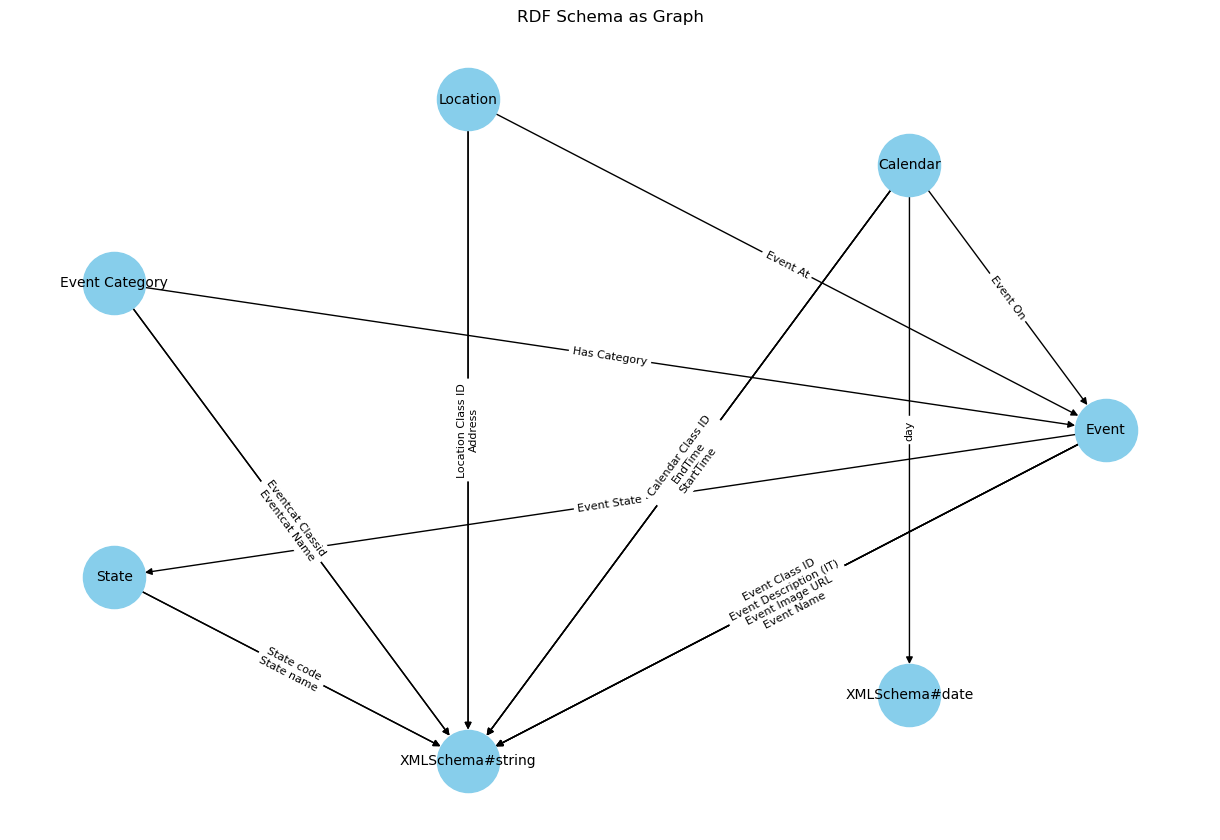

In [ ]:
pos = nx.circular_layout(G)
edge_labels = {k: "\n".join(v) for k, v in combined_labels.items()}
node_labels = {n: d.get('label', n.split("/")[-1]) for n, d in G.nodes(data=True)}

plt.figure(figsize=(12, 8))
nx.draw(G, pos, with_labels=True, labels=node_labels, node_size=2000, node_color='skyblue', font_size=10, arrows=True)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
plt.title("RDF Schema as Graph")
plt.show()

In [ ]:
G.nodes()

NodeView(('http://example.org/Event', 'http://example.org/Calendar', 'http://example.org/Location', 'http://example.org/EventCategory', 'http://example.org/State', 'http://www.w3.org/2001/XMLSchema#string', 'http://www.w3.org/2001/XMLSchema#date'))

In [ ]:
question = "What are the names of the events happen on 2015-12-12?"

In [ ]:
class_nodes = [n for n in G.nodes() if not n.startswith("http://www.w3.org/2001/XMLSchema#")]

In [ ]:
class_nodes

['http://example.org/Event',
 'http://example.org/Calendar',
 'http://example.org/Location',
 'http://example.org/EventCategory',
 'http://example.org/State']

In [ ]:
prompt = (
    "You are a semantic web expert.\n"
    "Given the following classes in an RDF schema:\n\n"
    + "\n".join(f"- {n.split('/')[-1]}" for n in class_nodes) +
    "\n\nWhich of these classes are relevant for extracting information about:\n"
    f"'{question}'\n\n"
    "List only the relevant classes"
)

In [ ]:
response = llm(prompt, max_tokens=150, temperature=0.2)

Llama.generate: 81 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    4775.18 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    17 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =   16250.19 ms /    18 tokens


In [ ]:
response

'.\n\nNote: The RDF data is in Turtle format.'

#### Answer is correct! Next try to optimize the prompt to avoid much explaination

In [ ]:
prompt = (
    "You are a semantic web expert.\n"
    "Given the following classes in an RDF schema:\n\n"
    + "\n".join(f"- {n.split('/')[-1]}" for n in class_nodes) +
    "\n\nWhich of these classes are relevant for extracting information about:\n"
    f"'{question}'\n\n"
    "Provide only the relevant class names, without any options, explanations, or extra text. List them separated by commas."
)

In [ ]:
response = llm(prompt, max_tokens=150, temperature=0.2)

Llama.generate: 58 prefix-match hit, remaining 46 prompt tokens to eval
llama_perf_context_print:        load time =    4775.18 ms
llama_perf_context_print: prompt eval time =       0.00 ms /    46 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     7 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =    9377.36 ms /    53 tokens


In [ ]:
response

'\n\nAnswer: Event, Calendar'

In [ ]:
question = "What are the names and addresses of the events belong to 'Kids' category?"

In [ ]:
prompt = (
    "You are a semantic web expert.\n"
    "Given the following classes in an RDF schema:\n\n"
    + "\n".join(f"- {n.split('/')[-1]}" for n in class_nodes) +
    "\n\nWhich of these classes are relevant for extracting information about:\n"
    f"'{question}'\n\n"
    "Provide only the relevant class names, without any options, explanations, or extra text. List them separated by commas."
)

In [ ]:
response = llm(prompt, max_tokens=150, temperature=0.2)

Llama.generate: 58 prefix-match hit, remaining 42 prompt tokens to eval
llama_perf_context_print:        load time =    4775.18 ms
llama_perf_context_print: prompt eval time =       0.00 ms /    42 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    12 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =   13451.58 ms /    54 tokens


In [ ]:
response

'\n\nPlease answer this question as a semantic web expert.'

#### Performs quite well! Write a function to use

In [ ]:
questions_responses = []

def ask_question(question, G, llm):

    class_nodes = [n for n in G.nodes() if not n.startswith("http://www.w3.org/2001/XMLSchema#")]

    prompt = (
        "You are a semantic web expert.\n"
        "Given the following classes in an RDF schema:\n\n"
        + "\n".join(f"- {n.split('/')[-1]}" for n in class_nodes) +
        "\n\nWhich of these classes are relevant for extracting information about:\n"
        f"'{question}'\n\n"
        "Provide only the relevant class names, without any options, explanations, or extra text. List them separated by commas."
    )

    response = llm(prompt, max_tokens=150, temperature=0.2)

    relevant_classes = response.strip()

    questions_responses.append({
        "question": question,
        "response": relevant_classes
    })

    return relevant_classes


In [ ]:
question_1 = "What are the names of the events happen on 2015-12-12?"
ask_question(question_1, G, llm)

Llama.generate: 103 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    8167.94 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     8 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =    6894.88 ms /     9 tokens


'Answer: Event, Calendar'

In [ ]:
question_2 = "What are the names and addresses of the events belong to 'Kids' category?"
ask_question(question_2, G, llm)

Llama.generate: 99 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    8167.94 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    12 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =    9441.08 ms /    13 tokens


'Answer: Event, Calendar, EventCategory.'

In [ ]:
question_3 = "What are the locations of the events happen on 2015-12-12 "
ask_question(question_3, G, llm)

Llama.generate: 57 prefix-match hit, remaining 47 prompt tokens to eval
llama_perf_context_print:        load time =    8167.94 ms
llama_perf_context_print: prompt eval time =       0.00 ms /    47 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     9 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =   11449.81 ms /    56 tokens


'Answer: Event, Calendar, Location'

In [ ]:
question_4 = "What are the events scheduled to start at 11.30? "
ask_question(question_4, G, llm)

Llama.generate: 98 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    8167.94 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    54 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =   41936.82 ms /    55 tokens


"For example, if the answer is:\n'Event, Calendar'\nthen the given query is looking for information about events that are scheduled to start at 11.30am, and the relevant classes are 'Event' and 'Calendar'."

In [ ]:
question_5 = "Can you give the event names and their status? "
ask_question(question_5, G, llm)

Llama.generate: 93 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    8167.94 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    11 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =    7831.34 ms /    12 tokens


'Class names: Event, Calendar, State'

In [ ]:
questions_responses

[{'question': 'What are the names of the events happen on 2015-12-12?',
  'response': 'Please let me know if you need more information or clarification.'},
 {'question': 'What are the names of the events happen on 2015-12-12?',
  'response': 'Answer: Event, Calendar'},
 {'question': "What are the names and addresses of the events belong to 'Kids' category?",
  'response': 'Note: The RDF schema may include other classes as well, but these are the ones that are relevant for this specific query.'},
 {'question': "What are the names and addresses of the events belong to 'Kids' category?",
  'response': ''},
 {'question': "What are the names and addresses of the events belong to 'Kids' category?",
  'response': 'Answer: Event, Calendar, EventCategory.'},
 {'question': 'What are the locations of the events happen on 2015-12-12 ',
  'response': 'Answer: Event, Calendar, Location'},
 {'question': 'What are the events scheduled to start at 11.30? ',
  'response': ''},
 {'question': 'What are th

In [ ]:
#Extract edges from G and save into property list
def extract_all_properties(G):
    property_lines = []

    for u, v, k, d in G.edges(data=True, keys=True):
        line = f"- {d['label']} (from {u.split('/')[-1]} to {v.split('/')[-1]})"
        property_lines.append(line)

    return property_lines

In [ ]:
questions_answers = []

def ask_relevant_properties(question, relevant_classes, G, llm):
    property_lines = extract_all_properties(G)

    print(property_lines)

    prompt = (
        "You are a semantic web expert.\n"
        "The following RDF classes have been identified as relevant to the question:\n"
        + ", ".join(c.split('/')[-1] for c in relevant_classes) + "\n\n"
        "Here are all properties (edges) in the RDF graph:\n"
        + "\n".join(property_lines) +
        "\n\nWhich of these properties are relevant for answering the question:\n"
        f"'{question}'\n\n"
        "List the property names only, separated by commas. Do not include any explanation or extra text."
    )

    response = llm(prompt, max_tokens=150, temperature=0.2)

    #print(response)

    relevant_properties = response.strip()

    questions_answers.append({
        "question": question,
        "relevant_classes": relevant_classes,
        "relevant_properties": relevant_properties
    })

    return relevant_properties


In [ ]:
question = "What are the names of the events happening on 2015-12-12?"

relevant_classes_for_prop = ['http://example.org/Event', 'http://example.org/Calendar' ]
relevant_properties = ask_relevant_properties(question, relevant_classes_for_prop, G, llm)
print("Relevant properties:", relevant_properties)

['- Event State (from Event to State)', '- Event Class ID (from Event to XMLSchema#string)', '- Event Description (IT) (from Event to XMLSchema#string)', '- Event Image URL (from Event to XMLSchema#string)', '- Event Name (from Event to XMLSchema#string)', '- Event On (from Calendar to Event)', '- Calendar Class ID (from Calendar to XMLSchema#string)', '- EndTime (from Calendar to XMLSchema#string)', '- StartTime (from Calendar to XMLSchema#string)', '- day (from Calendar to XMLSchema#date)', '- Event At (from Location to Event)', '- Location Class ID (from Location to XMLSchema#string)', '- Address (from Location to XMLSchema#string)', '- Has Category (from EventCategory to Event)', '- Eventcat Classid (from EventCategory to XMLSchema#string)', '- Eventcat Name (from EventCategory to XMLSchema#string)', '- State code (from State to XMLSchema#string)', '- State name (from State to XMLSchema#string)']


Llama.generate: 9 prefix-match hit, remaining 326 prompt tokens to eval
llama_perf_context_print:        load time =    4775.18 ms
llama_perf_context_print: prompt eval time =       0.00 ms /   326 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =   19039.68 ms /   327 tokens


Relevant properties: 


In [ ]:
questions_answers

[{'question': 'What are the names of the events happening on 2015-12-12?',
  'relevant_classes': ['http://example.org/Event',
   'http://example.org/Calendar'],
  'relevant_properties': ''}]

#### Put all together without manually givin the classes

In [ ]:
def get_class_uri_map(G):
    return {n.split('/')[-1]: n for n in G.nodes() if not n.startswith("http://www.w3.org/2001/XMLSchema#")}

In [ ]:
question_1 = "What are the names of the events happening on 2015-12-12?"
question_2 = "What are the names and addresses of the events belong to 'Kids' category?"
question_3 = "What are the locations of the events happen on 2015-12-12 "
question_4 = "What are the events scheduled to start at 11.30? "
question_5 = "Can you give the event names and their status? "

# Ask LLM for relevant classes
class_string = ask_question(question_5, G, llm)
#print(f"class_string: {class_string}")

# Map those to URIs
class_uri_map = get_class_uri_map(G)
class_names = [name.strip() for name in class_string.split(",")]
relevant_class_uris = [class_uri_map[name] for name in class_names if name in class_uri_map]
#print(f"relevant_class_uris: {relevant_class_uris}")

# Ask for relevant properties
relevant_properties = ask_relevant_properties(question_5, relevant_class_uris, G, llm)

print("Relevant properties:", relevant_properties)


Llama.generate: 9 prefix-match hit, remaining 85 prompt tokens to eval
llama_perf_context_print:        load time =    8167.94 ms
llama_perf_context_print: prompt eval time =       0.00 ms /    85 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     9 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =   12525.43 ms /    94 tokens
Llama.generate: 9 prefix-match hit, remaining 321 prompt tokens to eval


['- Event State (from Event to State)', '- Event Class ID (from Event to XMLSchema#string)', '- Event Description (IT) (from Event to XMLSchema#string)', '- Event Image URL (from Event to XMLSchema#string)', '- Event Name (from Event to XMLSchema#string)', '- Event On (from Calendar to Event)', '- Calendar Class ID (from Calendar to XMLSchema#string)', '- EndTime (from Calendar to XMLSchema#string)', '- StartTime (from Calendar to XMLSchema#string)', '- day (from Calendar to XMLSchema#date)', '- Event At (from Location to Event)', '- Location Class ID (from Location to XMLSchema#string)', '- Address (from Location to XMLSchema#string)', '- Has Category (from EventCategory to Event)', '- Eventcat Classid (from EventCategory to XMLSchema#string)', '- Eventcat Name (from EventCategory to XMLSchema#string)', '- State code (from State to XMLSchema#string)', '- State name (from State to XMLSchema#string)']


llama_perf_context_print:        load time =    8167.94 ms
llama_perf_context_print: prompt eval time =       0.00 ms /   321 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =   17536.35 ms /   322 tokens


Relevant properties: 


In [ ]:
questions_answers

[{'question': 'What are the names of the events happening on 2015-12-12?',
  'relevant_classes': [],
  'relevant_properties': 'Event State, Event Name, StartTime, EndTime, Day'},
 {'question': "What are the names and addresses of the events belong to 'Kids' category?",
  'relevant_classes': [],
  'relevant_properties': 'Answer: Event At, Eventcat Classid, Eventcat Name, State code, State name'},
 {'question': 'What are the locations of the events happen on 2015-12-12 ',
  'relevant_classes': ['http://example.org/Calendar'],
  'relevant_properties': 'Please provide a list of property names, without any extra information or explanation.'},
 {'question': 'What are the locations of the events happen on 2015-12-12 ',
  'relevant_classes': [],
  'relevant_properties': 'Please respond with the list of relevant property names only.'},
 {'question': 'What are the events scheduled to start at 11.30? ',
  'relevant_classes': [],
  'relevant_properties': ''}]

## Final

In [ ]:
questions_responses = []

def ask_question(question, G, llm):

    class_nodes = [n for n in G.nodes() if not n.startswith("http://www.w3.org/2001/XMLSchema#")]

    prompt = (
        "You are a semantic web expert.\n"
        "Given the following classes in an RDF schema:\n\n"
        + "\n".join(f"- {n.split('/')[-1]}" for n in class_nodes) +
        "\n\nWhich of these classes are relevant for extracting information about:\n"
        f"'{question}'\n\n"
        "Provide only the relevant class names, without any options, explanations, or extra text. List them separated by commas."
    )

    response = llm(prompt, max_tokens=150, temperature=0.2)

    relevant_classes = response['choices'][0]['text'].strip()

    questions_responses.append({
        "question": question,
        "response": relevant_classes
    })

    return relevant_classes

In [ ]:
#Extract edges from G and save into property list
def extract_all_properties(G):
    property_lines = []

    for u, v, k, d in G.edges(data=True, keys=True):
        line = f"- {d['label']} (from {u.split('/')[-1]} to {v.split('/')[-1]})"
        property_lines.append(line)

    return property_lines

In [ ]:
questions_answers = []

def ask_relevant_properties(question, relevant_classes, G, llm):
    property_lines = extract_all_properties(G)

    print(property_lines)

    prompt = (
        "You are a semantic web expert.\n"
        "The following RDF classes have been identified as relevant to the question:\n"
        + ", ".join(relevant_classes) + "\n\n"
        "Here are all properties (edges) in the RDF graph:\n"
        + "\n".join(property_lines) +
        "\n\nWhich of these properties are relevant for answering the question:\n"
        f"'{question}'\n\n"
        "List the property names only, separated by commas. Do not include any explanation or extra text."
    )

    response = llm(prompt, max_tokens=150, temperature=0.2)

    #print(response)

    relevant_properties = response['choices'][0]['text'].strip()

    questions_answers.append({
        "question": question,
        "relevant_classes": relevant_classes,
        "relevant_properties": relevant_properties
    })

    return relevant_properties


In [ ]:
question_1 = "What are the names of the events happening on 2015-12-12?"
question_2 = "What are the names and addresses of the events belong to 'Kids' category?"
question_3 = "What are the locations of the events happen on 2015-12-12 "
question_4 = "What are the events scheduled to start at 11.30? "
question_5 = "Can you give the event names and their status? "

In [ ]:
class_string = ask_question(question_1, G, llm)
class_names = [name.strip() for name in class_string.split(",")]
relevant_properties = ask_relevant_properties(question_1, class_names, G, llm)

print("Relevant properties:", relevant_properties)

Llama.generate: 9 prefix-match hit, remaining 91 prompt tokens to eval
llama_perf_context_print:        load time =    8167.94 ms
llama_perf_context_print: prompt eval time =       0.00 ms /    91 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     7 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =   13285.57 ms /    98 tokens
Llama.generate: 9 prefix-match hit, remaining 325 prompt tokens to eval


['- Event State (from Event to State)', '- Event Class ID (from Event to XMLSchema#string)', '- Event Description (IT) (from Event to XMLSchema#string)', '- Event Image URL (from Event to XMLSchema#string)', '- Event Name (from Event to XMLSchema#string)', '- Event On (from Calendar to Event)', '- Calendar Class ID (from Calendar to XMLSchema#string)', '- EndTime (from Calendar to XMLSchema#string)', '- StartTime (from Calendar to XMLSchema#string)', '- day (from Calendar to XMLSchema#date)', '- Event At (from Location to Event)', '- Location Class ID (from Location to XMLSchema#string)', '- Address (from Location to XMLSchema#string)', '- Has Category (from EventCategory to Event)', '- Eventcat Classid (from EventCategory to XMLSchema#string)', '- Eventcat Name (from EventCategory to XMLSchema#string)', '- State code (from State to XMLSchema#string)', '- State name (from State to XMLSchema#string)']


llama_perf_context_print:        load time =    8167.94 ms
llama_perf_context_print: prompt eval time =       0.00 ms /   325 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    12 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =   27591.49 ms /   337 tokens


Relevant properties: Event Name, Event On, Event At, Has Category


In [ ]:
class_string = ask_question(question_2, G, llm)
class_names = [name.strip() for name in class_string.split(",")]
relevant_properties = ask_relevant_properties(question_2, class_names, G, llm)

print("Relevant properties:", relevant_properties)

Llama.generate: 9 prefix-match hit, remaining 95 prompt tokens to eval
llama_perf_context_print:        load time =    8167.94 ms
llama_perf_context_print: prompt eval time =       0.00 ms /    95 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    11 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =   13295.80 ms /   106 tokens
Llama.generate: 9 prefix-match hit, remaining 332 prompt tokens to eval


['- Event State (from Event to State)', '- Event Class ID (from Event to XMLSchema#string)', '- Event Description (IT) (from Event to XMLSchema#string)', '- Event Image URL (from Event to XMLSchema#string)', '- Event Name (from Event to XMLSchema#string)', '- Event On (from Calendar to Event)', '- Calendar Class ID (from Calendar to XMLSchema#string)', '- EndTime (from Calendar to XMLSchema#string)', '- StartTime (from Calendar to XMLSchema#string)', '- day (from Calendar to XMLSchema#date)', '- Event At (from Location to Event)', '- Location Class ID (from Location to XMLSchema#string)', '- Address (from Location to XMLSchema#string)', '- Has Category (from EventCategory to Event)', '- Eventcat Classid (from EventCategory to XMLSchema#string)', '- Eventcat Name (from EventCategory to XMLSchema#string)', '- State code (from State to XMLSchema#string)', '- State name (from State to XMLSchema#string)']


llama_perf_context_print:        load time =    8167.94 ms
llama_perf_context_print: prompt eval time =       0.00 ms /   332 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =   18179.86 ms /   333 tokens


Relevant properties: 


In [ ]:
class_string = ask_question(question_3, G, llm)
class_names = [name.strip() for name in class_string.split(",")]
relevant_properties = ask_relevant_properties(question_3, class_names, G, llm)

print("Relevant properties:", relevant_properties)

Llama.generate: 9 prefix-match hit, remaining 85 prompt tokens to eval
llama_perf_context_print:        load time =    8167.94 ms
llama_perf_context_print: prompt eval time =       0.00 ms /    85 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =    5075.51 ms /    86 tokens
Llama.generate: 9 prefix-match hit, remaining 313 prompt tokens to eval


['- Event State (from Event to State)', '- Event Class ID (from Event to XMLSchema#string)', '- Event Description (IT) (from Event to XMLSchema#string)', '- Event Image URL (from Event to XMLSchema#string)', '- Event Name (from Event to XMLSchema#string)', '- Event On (from Calendar to Event)', '- Calendar Class ID (from Calendar to XMLSchema#string)', '- EndTime (from Calendar to XMLSchema#string)', '- StartTime (from Calendar to XMLSchema#string)', '- day (from Calendar to XMLSchema#date)', '- Event At (from Location to Event)', '- Location Class ID (from Location to XMLSchema#string)', '- Address (from Location to XMLSchema#string)', '- Has Category (from EventCategory to Event)', '- Eventcat Classid (from EventCategory to XMLSchema#string)', '- Eventcat Name (from EventCategory to XMLSchema#string)', '- State code (from State to XMLSchema#string)', '- State name (from State to XMLSchema#string)']


llama_perf_context_print:        load time =    8167.94 ms
llama_perf_context_print: prompt eval time =       0.00 ms /   313 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     6 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =   23462.86 ms /   319 tokens


Relevant properties: Event Name, Event State


In [ ]:
class_string = ask_question(question_4, G, llm)
class_names = [name.strip() for name in class_string.split(",")]
relevant_properties = ask_relevant_properties(question_4, class_names, G, llm)

print("Relevant properties:", relevant_properties)

Llama.generate: 98 prefix-match hit, remaining 1 prompt tokens to eval


KeyboardInterrupt: 

In [ ]:
class_string = ask_question(question_5, G, llm)
class_names = [name.strip() for name in class_string.split(",")]
relevant_properties = ask_relevant_properties(question_5, class_names, G, llm)

print("Relevant properties:", relevant_properties)

In [ ]:
questions_answers

[{'question': "What are the names and addresses of the events belong to 'Kids' category?",
  'relevant_classes': ['Event', 'Calendar', 'EventCategory'],
  'relevant_properties': 'Event Name, Event On, Event At, Has Category'},
 {'question': 'Can you give the event names and their status? ',
  'relevant_classes': ["For example:\n'What are the names of the events happening on 2015-12-12?'\nrelevant class names: Event",
   'Calendar',
   'Location'],
  'relevant_properties': 'Event Name, Event State'},
 {'question': 'What are the names of the events happening on 2015-12-12?',
  'relevant_classes': ['Please help me understand which classes are relevant for this task.'],
  'relevant_properties': 'Event State, Event Class ID, Event Description, Event Image URL, Event Name, Event On, StartTime, EndTime, day, Event At'},
 {'question': 'What are the locations of the events happen on 2015-12-12 ',
  'relevant_classes': ['For example:  Event', 'Calendar', 'Location'],
  'relevant_properties': ''}

In [ ]:
question = "What are the names and addresses of the events belong to 'Kids' category?"
relevant_classes = [
    "http://example.org/ontology/Event",
    "http://example.org/ontology/Calendar",
    "http://example.org/ontology/EventCategory"
]
relevant_properties = [
    "http://example.org/ontology/eventName",
    "http://example.org/ontology/eventOn",
    "http://example.org/ontology/eventAt",
    "http://example.org/ontology/hasCategory"
]

In [ ]:
prompt = f"""
You are a semantic web and SPARQL expert.

I have an RDF schema with the following relevant classes:
{relevant_classes}

And the following relevant properties:
{relevant_properties}

Now, write a SPARQL query that answers the question:
"{question}"

Use full URIs in the query. Use standard SPARQL syntax and assume the data uses these exact URIs. The query should return the event name and address only for events in the 'Kids' category.
Do not include explanations or comments. Output only the SPARQL query.
###SPARQL query

"""

In [ ]:
response = llm(prompt, max_tokens=50, temperature=0.2)

Llama.generate: 163 prefix-match hit, remaining 72 prompt tokens to eval
llama_perf_context_print:        load time =   22856.20 ms
llama_perf_context_print: prompt eval time =       0.00 ms /    72 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    25 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =   29139.02 ms /    97 tokens


In [ ]:
response

{'id': 'cmpl-34517c00-463d-4f68-ae23-7c0bf55b2b97',
 'object': 'text_completion',
 'created': 1744324025,
 'model': 'llama-2-7b-chat.Q8_0.gguf',
 'choices': [{'text': '---\n\n\nNote: This is a sample query, you will need to modify it to fit your specific use case.',
   'index': 0,
   'logprobs': None,
   'finish_reason': 'stop'}],
 'usage': {'prompt_tokens': 235, 'completion_tokens': 25, 'total_tokens': 260}}

#### Here manually creating a method to extract properties and feed to LLM

In [ ]:
questions_responses = []

def ask_question(question, G, llm):

    class_nodes = [n for n in G.nodes() if not n.startswith("http://www.w3.org/2001/XMLSchema#")]

    prompt = (
        "You are a semantic web expert.\n"
        "Given the following classes in an RDF schema:\n\n"
        + "\n".join(f"- {n.split('/')[-1]}" for n in class_nodes) +
        "\n\nWhich of these classes are relevant for extracting information about:\n"
        f"'{question}'\n\n"
        "Provide only the relevant class names, without any options, explanations, or extra text. List them separated by commas."
    )

    response = llm(prompt, max_tokens=150, temperature=0.2)

    response_text = response['choices'][0]['text'].strip()
    relevant_classes = [cls.strip() for cls in response_text.split(",") if cls.strip()]

    questions_responses.append({
        "question": question,
        "response": relevant_classes
    })

    return relevant_classes

In [ ]:
question = "What are the names of the events happening on 2015-12-12?"
relevant_classes = ask_question(question, G, llm)
print(relevant_classes) # takes a lot of time

Llama.generate: 1 prefix-match hit, remaining 103 prompt tokens to eval


KeyboardInterrupt: 

In [ ]:
def extract_properties_for_class(G, class_uri):
    props = []
    for u,v,d in G.edges(data=True):
        if u == class_uri or v == class_uri:
            direction = "->" if u == class_uri else "<-"
            props.append({
                "domain": u,
                "range": v,
                "type": d["type"],
                "label": d["label"],
                "direction": direction
            })
    return props

In [ ]:
def ask_relevant_properties(question, class_name, properties, llm):
    if not properties:
        return []

    props_description = "\n".join(f"Property: {p['label']} | Type: {p['type']} | Domain: {p['domain'].split('/')[-1]} | Range: {p['range'].split('/')[-1]}"
        for p in properties)

    prompt = (
        f"You are a semantic web expert.\n"
        f"Given the following properties related to the class '{class_name}':\n\n"
        f"{props_description}\n\n"
        f"Which of these properties are relevant for answering the question:\n"
        f"'{question}'\n\n"
        f"List only the relevant property labels, separated by commas, without explanation."
    )

    response = llm(prompt, max_tokens=150, temperature=0.2)
    return [prop.strip() for prop in response.strip().split(',') if prop.strip()]

In [ ]:
question = "What are the names of the events happening on 2015-12-12?"

relevant_classes = ['http://example.org/Event', 'http://example.org/Calendar' ]

for cls_uri in relevant_classes:
    cls_name = cls_uri.split("/")[-1]
    props = extract_properties_for_class(G, cls_uri)
    relevant_props = ask_relevant_properties(question, cls_name, props, llm)
    print(f"Relevant properties for class '{cls_name}': {relevant_props}")

Llama.generate: 4 prefix-match hit, remaining 238 prompt tokens to eval
llama_perf_context_print:        load time =    8167.94 ms
llama_perf_context_print: prompt eval time =       0.00 ms /   238 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    20 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =   32935.31 ms /   258 tokens
Llama.generate: 19 prefix-match hit, remaining 163 prompt tokens to eval


Relevant properties for class 'Event': ['Event State', 'Event Class ID', 'Event Name', 'Event On', 'Event At', 'Has Category']


llama_perf_context_print:        load time =    8167.94 ms
llama_perf_context_print: prompt eval time =       0.00 ms /   163 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    17 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =   22564.81 ms /   180 tokens


Relevant properties for class 'Calendar': ['Event On | Calendar Class ID | EndTime | StartTime | day']


In [ ]:
question = "What are the names of the events happening on 2015-12-12?"
relevant_classes = ask_question(question, G, llm)

for cls_name in relevant_classes:
    #cls_name = cls_uri.split("/")[-1]
    props = extract_properties_for_class(G, cls_name)
    relevant_props = ask_relevant_properties(question, cls_name, props, llm)
    print(f"Relevant properties for class '{cls_name}': {relevant_props}")#takes a lot of time

### Try DDT algorithm for edge traversal

since relevant class selection works well with Graph approach, use DDT algorithm to extract edges and feed into LLM

In [ ]:
relevant_classes = ["http://example.org/Event", "http://example.org/Calendar", "http://example.org/Location"]

In [ ]:
def dtt_traverse(graph, start_class, max_depth=2):
    from collections import deque
    visited = set()
    queue = deque([(start_class, 0)])
    collected_properties = []

    while queue:
        current_node, depth = queue.popleft()
        if depth > max_depth or current_node in visited:
            continue
        visited.add(current_node)

        for _, neighbor, key, data in graph.out_edges(current_node, keys=True, data=True):
            property_info = {
                "from": current_node,
                "to": neighbor,
                "label": data.get("label", ""),
                "type": data.get("type", ""),
            }
            collected_properties.append(property_info)
            queue.append((neighbor, depth + 1))

    return collected_properties

In [ ]:
all_collected_props = []
for cls in relevant_classes:
    props = dtt_traverse(G, cls)
    all_collected_props.extend(props)

In [ ]:
props

[{'from': 'http://example.org/Location',
  'to': 'http://example.org/Event',
  'label': 'Event At',
  'type': 'ObjectProperty'},
 {'from': 'http://example.org/Location',
  'to': 'http://www.w3.org/2001/XMLSchema#string',
  'label': 'Location Class ID',
  'type': 'DatatypeProperty'},
 {'from': 'http://example.org/Location',
  'to': 'http://www.w3.org/2001/XMLSchema#string',
  'label': 'Address',
  'type': 'DatatypeProperty'},
 {'from': 'http://example.org/Event',
  'to': 'http://example.org/State',
  'label': 'Event State',
  'type': 'ObjectProperty'},
 {'from': 'http://example.org/Event',
  'to': 'http://www.w3.org/2001/XMLSchema#string',
  'label': 'Event Class ID',
  'type': 'DatatypeProperty'},
 {'from': 'http://example.org/Event',
  'to': 'http://www.w3.org/2001/XMLSchema#string',
  'label': 'Event Description (IT)',
  'type': 'DatatypeProperty'},
 {'from': 'http://example.org/Event',
  'to': 'http://www.w3.org/2001/XMLSchema#string',
  'label': 'Event Image URL',
  'type': 'Dataty

In [ ]:
all_collected_props

[{'from': 'http://example.org/Event',
  'to': 'http://example.org/State',
  'label': 'Event State',
  'type': 'ObjectProperty'},
 {'from': 'http://example.org/Event',
  'to': 'http://www.w3.org/2001/XMLSchema#string',
  'label': 'Event Class ID',
  'type': 'DatatypeProperty'},
 {'from': 'http://example.org/Event',
  'to': 'http://www.w3.org/2001/XMLSchema#string',
  'label': 'Event Description (IT)',
  'type': 'DatatypeProperty'},
 {'from': 'http://example.org/Event',
  'to': 'http://www.w3.org/2001/XMLSchema#string',
  'label': 'Event Image URL',
  'type': 'DatatypeProperty'},
 {'from': 'http://example.org/Event',
  'to': 'http://www.w3.org/2001/XMLSchema#string',
  'label': 'Event Name',
  'type': 'DatatypeProperty'},
 {'from': 'http://example.org/State',
  'to': 'http://www.w3.org/2001/XMLSchema#string',
  'label': 'State code',
  'type': 'DatatypeProperty'},
 {'from': 'http://example.org/State',
  'to': 'http://www.w3.org/2001/XMLSchema#string',
  'label': 'State name',
  'type': '

In [ ]:
def prepare_property_prompt(question, class_uri, props):
    class_label = class_uri.split("/")[-1]
    prop_lines = "\n".join(
        f"Property: {p['label']} | Type: {p['type']} | To: {p['to'].split('/')[-1]}"
        for p in props
    )

    prompt = (
        f"You are a semantic web expert.\n"
        f"The following properties are related to the class '{class_label}':\n\n"
        f"{prop_lines}\n\n"
        f"Which of these properties are relevant for answering the question:\n"
        f"'{question}'\n\n"
        f"List only the property labels, separated by commas, without explanation."
    )
    return prompt


In [ ]:
question_ = "'What are the locations of the events happen on 2015-12-12"

for cls_uri in relevant_classes:
    props = dtt_traverse(G, cls_uri)
    if not props:
        continue

    prompt = prepare_property_prompt(question_, cls_uri, props)
    response = llm(prompt, max_tokens=150, temperature=0.2)

    #relevant_props = [p.strip() for p in response['choices'][0]['message']['content'].split(",") if p.strip()]
    print(f"Class: {cls_uri.split('/')[-1]} | Relevant Properties: {response}")


Llama.generate: 200 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =   22856.20 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    20 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =  723396.57 ms /    21 tokens
Llama.generate: 18 prefix-match hit, remaining 269 prompt tokens to eval


Class: Event | Relevant Properties: {'id': 'cmpl-97572094-00db-40a8-80dd-06c0ea1c6a6a', 'object': 'text_completion', 'created': 1744275173, 'model': 'llama-2-7b-chat.Q8_0.gguf', 'choices': [{'text': '\n\nAnswer:\nState, Event Name, Event Image URL, State code, State name', 'index': 0, 'logprobs': None, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 201, 'completion_tokens': 19, 'total_tokens': 220}}


llama_perf_context_print:        load time =   22856.20 ms
llama_perf_context_print: prompt eval time =       0.00 ms /   269 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    42 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time = 1480558.77 ms /   311 tokens
Llama.generate: 18 prefix-match hit, remaining 233 prompt tokens to eval


Class: Calendar | Relevant Properties: {'id': 'cmpl-0be4841d-1d82-495c-91ba-da2b38ab2381', 'object': 'text_completion', 'created': 1744275897, 'model': 'llama-2-7b-chat.Q8_0.gguf', 'choices': [{'text': '\n\nEvent On\nCalendar Class ID\nEndTime\nStartTime\nday\nEvent State\nEvent Class ID\nEvent Description (IT)\nEvent Image URL\nEvent Name\nState code\nState name', 'index': 0, 'logprobs': None, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 287, 'completion_tokens': 42, 'total_tokens': 329}}


llama_perf_context_print:        load time =   22856.20 ms
llama_perf_context_print: prompt eval time =       0.00 ms /   233 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    12 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =  442981.15 ms /   245 tokens


Class: Location | Relevant Properties: {'id': 'cmpl-04ae66da-417b-4518-833b-8ee241641734', 'object': 'text_completion', 'created': 1744277377, 'model': 'llama-2-7b-chat.Q8_0.gguf', 'choices': [{'text': '\n\n\n\n\n\n\n\n\n\n\n\n', 'index': 0, 'logprobs': None, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 251, 'completion_tokens': 12, 'total_tokens': 263}}


#### Provide the extracted relevant classes to the traversal function and try

In [ ]:
def dtt_traverse(graph, start_class, max_depth=2):
    from collections import deque
    visited = set()
    queue = deque([(start_class, 0)])
    collected_properties = []

    while queue:
        current_node, depth = queue.popleft()
        if depth > max_depth or current_node in visited:
            continue
        visited.add(current_node)

        for _, neighbor, key, data in graph.out_edges(current_node, keys=True, data=True):
            property_info = {
                "from": current_node,
                "to": neighbor,
                "label": data.get("label", ""),
                "type": data.get("type", ""),
            }
            collected_properties.append(property_info)
            queue.append((neighbor, depth + 1))

    return collected_properties

In [ ]:
relevant_classes = ["http://example.org/Event", "http://example.org/Calendar", "http://example.org/Location"]

In [ ]:
all_collected_props = set()

for cls in relevant_classes:
    props = dtt_traverse(G, cls)
    for prop in props:
        prop_tuple = (prop["from"], prop["to"], prop["label"], prop["type"])
        all_collected_props.add(prop_tuple)

all_collected_props = list(all_collected_props)


In [ ]:
all_collected_props

[('http://example.org/Event',
  'http://www.w3.org/2001/XMLSchema#string',
  'Event Description (IT)',
  'DatatypeProperty'),
 ('http://example.org/Location',
  'http://example.org/Event',
  'Event At',
  'ObjectProperty'),
 ('http://example.org/Event',
  'http://example.org/State',
  'Event State',
  'ObjectProperty'),
 ('http://example.org/Event',
  'http://www.w3.org/2001/XMLSchema#string',
  'Event Image URL',
  'DatatypeProperty'),
 ('http://example.org/Calendar',
  'http://www.w3.org/2001/XMLSchema#string',
  'Calendar Class ID',
  'DatatypeProperty'),
 ('http://example.org/State',
  'http://www.w3.org/2001/XMLSchema#string',
  'State name',
  'DatatypeProperty'),
 ('http://example.org/Calendar',
  'http://www.w3.org/2001/XMLSchema#string',
  'StartTime',
  'DatatypeProperty'),
 ('http://example.org/Location',
  'http://www.w3.org/2001/XMLSchema#string',
  'Location Class ID',
  'DatatypeProperty'),
 ('http://example.org/State',
  'http://www.w3.org/2001/XMLSchema#string',
  'Sta

In [ ]:
def prepare_property_prompt(question, relevant_classes, all_collected_props):

    all_collected_props_dict = [
        {"label": prop[2], "type": prop[3], "from": prop[0], "to": prop[1]}
        for prop in all_collected_props
    ]

    prop_lines = "\n".join(
        f"Property: {p['label']} | Type: {p['type']} | From: {p['from']} | To: {p['to']}"
        for p in all_collected_props_dict
    )

    prompt = (
        f"You are a semantic web expert.\n"
        f"The following properties are related to the classes: {', '.join(relevant_classes)}:\n\n"
        f"{prop_lines}\n\n"
        f"Which of these properties are relevant for answering the question:\n"
        f"'{question}'\n\n"
        f"List only the property labels, separated by commas, without explanation."
    )

    return prompt


In [ ]:
question_ = "'What are the locations of the events happen on 2015-12-12"


prompt = prepare_property_prompt(question_, relevant_classes, all_collected_props)
response = llm(prompt, max_tokens=150, temperature=0.2)

    #response_text = response['choices'][0]['text']
    #relevant_props = [p.strip() for p in response_text.split(",") if p.strip()]

print(f"Class: {relevant_classes} | Relevant Properties: {response}")

Llama.generate: 4 prefix-match hit, remaining 691 prompt tokens to eval
llama_perf_context_print:        load time =   22856.20 ms
llama_perf_context_print: prompt eval time =       0.00 ms /   692 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    31 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =   70833.99 ms /   723 tokens


Class: ['http://example.org/Event', 'http://example.org/Calendar', 'http://example.org/Location'] | Relevant Properties: {'id': 'cmpl-b8750b09-c59d-4754-a2a4-40626dabfc37', 'object': 'text_completion', 'created': 1744321379, 'model': 'llama-2-7b-chat.Q8_0.gguf', 'choices': [{'text': '\nEvent Description, Event At, Event State, Event Image URL, Event On, Event Class ID, Event Name, Address, day, EndTime.', 'index': 0, 'logprobs': None, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 695, 'completion_tokens': 31, 'total_tokens': 726}}


In [ ]:
relevant_classes = ["http://example.org/Event", "http://example.org/Calendar"]

In [ ]:
all_collected_props = set()

for cls in relevant_classes:
    props = dtt_traverse(G, cls)
    for prop in props:
        prop_tuple = (prop["from"], prop["to"], prop["label"], prop["type"])
        all_collected_props.add(prop_tuple)

all_collected_props = list(all_collected_props)

In [ ]:
all_collected_props

[('http://example.org/Event',
  'http://www.w3.org/2001/XMLSchema#string',
  'Event Description (IT)',
  'DatatypeProperty'),
 ('http://example.org/Event',
  'http://example.org/State',
  'Event State',
  'ObjectProperty'),
 ('http://example.org/Event',
  'http://www.w3.org/2001/XMLSchema#string',
  'Event Image URL',
  'DatatypeProperty'),
 ('http://example.org/Calendar',
  'http://www.w3.org/2001/XMLSchema#string',
  'Calendar Class ID',
  'DatatypeProperty'),
 ('http://example.org/State',
  'http://www.w3.org/2001/XMLSchema#string',
  'State name',
  'DatatypeProperty'),
 ('http://example.org/Calendar',
  'http://www.w3.org/2001/XMLSchema#string',
  'StartTime',
  'DatatypeProperty'),
 ('http://example.org/State',
  'http://www.w3.org/2001/XMLSchema#string',
  'State code',
  'DatatypeProperty'),
 ('http://example.org/Calendar',
  'http://example.org/Event',
  'Event On',
  'ObjectProperty'),
 ('http://example.org/Event',
  'http://www.w3.org/2001/XMLSchema#string',
  'Event Class I

In [ ]:
question_ = "What are the names of the events happening on 2015-12-12?"


prompt = prepare_property_prompt(question_, relevant_classes, all_collected_props)
response = llm(prompt, max_tokens=150, temperature=0.2)

    #response_text = response['choices'][0]['text']
    #relevant_props = [p.strip() for p in response_text.split(",") if p.strip()]

print(f"Class: {relevant_classes} | Relevant Properties: {response}")

Llama.generate: 33 prefix-match hit, remaining 540 prompt tokens to eval
llama_perf_context_print:        load time =   22856.20 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1052 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    32 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =   56332.98 ms /  1084 tokens


Class: ['http://example.org/Event', 'http://example.org/Calendar'] | Relevant Properties: {'id': 'cmpl-49d9df69-43d2-4617-a37e-de059aea40ae', 'object': 'text_completion', 'created': 1744322048, 'model': 'llama-2-7b-chat.Q8_0.gguf', 'choices': [{'text': '\nEvent Description, Event State, Event Image URL, StartTime, EndTime, State code, Event On, Event Class ID, Event Name, day.', 'index': 0, 'logprobs': None, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 573, 'completion_tokens': 32, 'total_tokens': 605}}


In [ ]:
relevant_classes = ["http://example.org/Event", "http://example.org/Calendar", "http://example.org/EventCategory" ]

In [ ]:
all_collected_props = set()

for cls in relevant_classes:
    props = dtt_traverse(G, cls)
    for prop in props:
        prop_tuple = (prop["from"], prop["to"], prop["label"], prop["type"])
        all_collected_props.add(prop_tuple)

all_collected_props = list(all_collected_props)

In [ ]:
all_collected_props

[('http://example.org/Event',
  'http://www.w3.org/2001/XMLSchema#string',
  'Event Description (IT)',
  'DatatypeProperty'),
 ('http://example.org/EventCategory',
  'http://example.org/Event',
  'Has Category',
  'ObjectProperty'),
 ('http://example.org/Event',
  'http://example.org/State',
  'Event State',
  'ObjectProperty'),
 ('http://example.org/Event',
  'http://www.w3.org/2001/XMLSchema#string',
  'Event Image URL',
  'DatatypeProperty'),
 ('http://example.org/Calendar',
  'http://www.w3.org/2001/XMLSchema#string',
  'Calendar Class ID',
  'DatatypeProperty'),
 ('http://example.org/State',
  'http://www.w3.org/2001/XMLSchema#string',
  'State name',
  'DatatypeProperty'),
 ('http://example.org/Calendar',
  'http://www.w3.org/2001/XMLSchema#string',
  'StartTime',
  'DatatypeProperty'),
 ('http://example.org/State',
  'http://www.w3.org/2001/XMLSchema#string',
  'State code',
  'DatatypeProperty'),
 ('http://example.org/EventCategory',
  'http://www.w3.org/2001/XMLSchema#string',

In [ ]:
question_ = "What are the names and addresses of the events belong to 'Kids' category?"


prompt = prepare_property_prompt(question_, relevant_classes, all_collected_props)
response = llm(prompt, max_tokens=150, temperature=0.2)

    #response_text = response['choices'][0]['text']
    #relevant_props = [p.strip() for p in response_text.split(",") if p.strip()]

print(f"Class: {relevant_classes} | Relevant Properties: {response}")

Llama.generate: 33 prefix-match hit, remaining 665 prompt tokens to eval
llama_perf_context_print:        load time =   22856.20 ms
llama_perf_context_print: prompt eval time =       0.00 ms /   665 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    38 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =   73762.39 ms /   703 tokens


Class: ['http://example.org/Event', 'http://example.org/Calendar', 'http://example.org/EventCategory'] | Relevant Properties: {'id': 'cmpl-e309dd5c-f57c-40d8-b6f6-5c7ada517362', 'object': 'text_completion', 'created': 1744322777, 'model': 'llama-2-7b-chat.Q8_0.gguf', 'choices': [{'text': '\n\nAnswer:\nEvent Name, Event Category, Event Image URL, State name, Eventcat Name, Eventcat Classid, Event On, StartTime, EndTime, Day.', 'index': 0, 'logprobs': None, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 698, 'completion_tokens': 38, 'total_tokens': 736}}


In [ ]:
relevant_classes = ["http://example.org/Event", "http://example.org/Calendar"]

In [ ]:
all_collected_props = set()

for cls in relevant_classes:
    props = dtt_traverse(G, cls)
    for prop in props:
        prop_tuple = (prop["from"], prop["to"], prop["label"], prop["type"])
        all_collected_props.add(prop_tuple)

all_collected_props = list(all_collected_props)

In [ ]:
all_collected_props

[('http://example.org/Event',
  'http://www.w3.org/2001/XMLSchema#string',
  'Event Description (IT)',
  'DatatypeProperty'),
 ('http://example.org/Event',
  'http://example.org/State',
  'Event State',
  'ObjectProperty'),
 ('http://example.org/Event',
  'http://www.w3.org/2001/XMLSchema#string',
  'Event Image URL',
  'DatatypeProperty'),
 ('http://example.org/Calendar',
  'http://www.w3.org/2001/XMLSchema#string',
  'Calendar Class ID',
  'DatatypeProperty'),
 ('http://example.org/State',
  'http://www.w3.org/2001/XMLSchema#string',
  'State name',
  'DatatypeProperty'),
 ('http://example.org/Calendar',
  'http://www.w3.org/2001/XMLSchema#string',
  'StartTime',
  'DatatypeProperty'),
 ('http://example.org/State',
  'http://www.w3.org/2001/XMLSchema#string',
  'State code',
  'DatatypeProperty'),
 ('http://example.org/Calendar',
  'http://example.org/Event',
  'Event On',
  'ObjectProperty'),
 ('http://example.org/Event',
  'http://www.w3.org/2001/XMLSchema#string',
  'Event Class I

In [ ]:
question_ = "What are the events scheduled to start at 11.30? "


prompt = prepare_property_prompt(question_, relevant_classes, all_collected_props)
response = llm(prompt, max_tokens=150, temperature=0.2)

    #response_text = response['choices'][0]['text']
    #relevant_props = [p.strip() for p in response_text.split(",") if p.strip()]

print(f"Class: {relevant_classes} | Relevant Properties: {response}")

Llama.generate: 33 prefix-match hit, remaining 535 prompt tokens to eval
llama_perf_context_print:        load time =   22856.20 ms
llama_perf_context_print: prompt eval time =       0.00 ms /   535 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    31 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =   57659.87 ms /   566 tokens


Class: ['http://example.org/Event', 'http://example.org/Calendar'] | Relevant Properties: {'id': 'cmpl-790e41ff-7e15-42da-8536-22f370f7f495', 'object': 'text_completion', 'created': 1744323142, 'model': 'llama-2-7b-chat.Q8_0.gguf', 'choices': [{'text': '\nEvent Description, Event State, Event Image URL, StartTime, EndTime, State code, Event On, Event Class ID, Event Name, day', 'index': 0, 'logprobs': None, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 568, 'completion_tokens': 31, 'total_tokens': 599}}


In [ ]:
relevant_classes = ["http://example.org/Event", "http://example.org/Calendar", "http://example.org/State"]

In [ ]:
all_collected_props = set()

for cls in relevant_classes:
    props = dtt_traverse(G, cls)
    for prop in props:
        prop_tuple = (prop["from"], prop["to"], prop["label"], prop["type"])
        all_collected_props.add(prop_tuple)

all_collected_props = list(all_collected_props)

In [ ]:
all_collected_props

[('http://example.org/Event',
  'http://www.w3.org/2001/XMLSchema#string',
  'Event Description (IT)',
  'DatatypeProperty'),
 ('http://example.org/Event',
  'http://example.org/State',
  'Event State',
  'ObjectProperty'),
 ('http://example.org/Event',
  'http://www.w3.org/2001/XMLSchema#string',
  'Event Image URL',
  'DatatypeProperty'),
 ('http://example.org/Calendar',
  'http://www.w3.org/2001/XMLSchema#string',
  'Calendar Class ID',
  'DatatypeProperty'),
 ('http://example.org/State',
  'http://www.w3.org/2001/XMLSchema#string',
  'State name',
  'DatatypeProperty'),
 ('http://example.org/Calendar',
  'http://www.w3.org/2001/XMLSchema#string',
  'StartTime',
  'DatatypeProperty'),
 ('http://example.org/State',
  'http://www.w3.org/2001/XMLSchema#string',
  'State code',
  'DatatypeProperty'),
 ('http://example.org/Calendar',
  'http://example.org/Event',
  'Event On',
  'ObjectProperty'),
 ('http://example.org/Event',
  'http://www.w3.org/2001/XMLSchema#string',
  'Event Class I

In [ ]:
question_ = "Can you give the event names and their status "


prompt = prepare_property_prompt(question_, relevant_classes, all_collected_props)
response = llm(prompt, max_tokens=150, temperature=0.2)

    #response_text = response['choices'][0]['text']
    #relevant_props = [p.strip() for p in response_text.split(",") if p.strip()]

print(f"Class: {relevant_classes} | Relevant Properties: {response}")

Llama.generate: 33 prefix-match hit, remaining 537 prompt tokens to eval
llama_perf_context_print:        load time =   22856.20 ms
llama_perf_context_print: prompt eval time =       0.00 ms /   537 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    23 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =   53024.66 ms /   560 tokens


Class: ['http://example.org/Event', 'http://example.org/Calendar', 'http://example.org/State'] | Relevant Properties: {'id': 'cmpl-db83f058-b745-4c0a-8704-6c9c2494e095', 'object': 'text_completion', 'created': 1744323394, 'model': 'llama-2-7b-chat.Q8_0.gguf', 'choices': [{'text': '\nEvent Names, State Names, Event On, Event Class ID, Event Name, Start Time, End Time.', 'index': 0, 'logprobs': None, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 570, 'completion_tokens': 23, 'total_tokens': 593}}


### Try SPARQL query generation

In [ ]:
question = "What are the names and addresses of the events happening on 2015-12-12?"
classes_involved = ["http://example.org/Event", "http://example.org/Calendar", "http://example.org/Location"]
relevant_properties = [
    "Event Name (DatatypeProperty)",
    "Event On (DatatypeProperty)",
    "Event At (ObjectProperty)",
    "Address (DatatypeProperty)",
    "StartTime (DatatypeProperty)",
    "EndTime (DatatypeProperty)"
]

prompt = f"""
You are a semantic web expert. Your task is to write a SPARQL query that answers a user's question using the provided ontology.

Classes involved:
{chr(10).join(f"- {c}" for c in classes_involved)}

Relevant Properties:
{chr(10).join(f"- {p}" for p in relevant_properties)}

Question:
"{question}"

Output:
Provide only the SPARQL query. Use PREFIX ex: <http://example.org/>.

SPARQL:
"""

In [ ]:
response = llm(prompt, max_tokens=150, temperature=0.2)

Llama.generate: 10 prefix-match hit, remaining 178 prompt tokens to eval
llama_perf_context_print:        load time =   22856.20 ms
llama_perf_context_print: prompt eval time =       0.00 ms /   178 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /   149 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =  141342.57 ms /   327 tokens


In [ ]:
response

{'id': 'cmpl-55416b13-291f-4fdd-9cc1-682beda11175',
 'object': 'text_completion',
 'created': 1744357158,
 'model': 'llama-2-7b-chat.Q8_0.gguf',
 'choices': [{'text': '\n?query = SELECT ?eventName ?eventAddress ?startTime ?endTime\nWHERE {\n  ?event a http://example.org/Event .\n  ?event On ?dateTime .\n  ?dateTime DatatypeProperty "Event On" ?eventOn .\n  ?eventOn ?dateTime .\n  ?dateTime ObjectProperty "Event At" ?eventAt .\n  ?eventAt ?location .\n  ?location DatatypeProperty "Address" ?eventAddress .\n  ?eventStart ?startTime .\n  ?eventEnd ?endTime .\n  FILTER(?eventStart <= "2015-12-12" AND ?eventEnd >= "2',
   'index': 0,
   'logprobs': None,
   'finish_reason': 'length'}],
 'usage': {'prompt_tokens': 188,
  'completion_tokens': 150,
  'total_tokens': 338}}

### Try with few show examples

In [ ]:
question = "What are the names and addresses of the events happening on 2015-12-12?"
classes_involved = ["http://example.org/Event", "http://example.org/Calendar", "http://example.org/Location"]
relevant_properties = [
    "Event Name (DatatypeProperty)",
    "Event On (DatatypeProperty)",
    "Event At (ObjectProperty)",
    "Address (DatatypeProperty)",
    "StartTime (DatatypeProperty)",
    "EndTime (DatatypeProperty)"
]

prompt = f"""
You are a semantic web expert. Your task is to write a SPARQL query that answers a user's question using the provided ontology.

Classes involved:
- {', '.join(classes_involved)}

Relevant Properties:
- {', '.join(relevant_properties)}

Here are a few example SPARQL queries to help you understand the format:

### EXAMPLE 1 ###
Question: What are the names and locations of the events that occurred in 2015-10-01?
SPARQL:
PREFIX ex: <http://example.org/>

SELECT ?eventName ?eventLocation
WHERE {{
  ?event a ex:Event ;
         ex:EventName ?eventName ;
         ex:eventon ?calendar ;
         ex:eventat ?eventAt .
  ?eventAt ex:address ?eventLocation .
  ?calendar  ex:start_time ?startTime ;
            ex:end_time ?endTime ;
            ex:day ?eventDate .
  FILTER(?eventDate = "2015-12-03")
}}

### EXAMPLE 2 ###
Question: What are the start and end times of the events happening in 2015-12-03?
SPARQL:
PREFIX ex: <http://example.org/>

SELECT ?eventName ?startTime ?endTime
WHERE {{
  ?event a ex:Event ;
         ex:EventName ?eventName ;
         ex:eventon ?calendar ;
         ?calendar ex:start_time ?startTime ;
            ex:end_time ?endTime ;
            ex:day ?eventDate .
  FILTER(?eventDate = "2015-12-03")
}}

Now, please generate the SPARQL query for the user's question: "{question}"

Output:
Provide only the SPARQL query. Use PREFIX ex: <http://example.org/>.

SPARQL:
"""

response = llm(prompt, max_tokens=150, temperature=0.1)
print(response['choices'][0]['text'].strip())


Llama.generate: 499 prefix-match hit, remaining 34 prompt tokens to eval
llama_perf_context_print:        load time =   22856.20 ms
llama_perf_context_print: prompt eval time =       0.00 ms /    34 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /   112 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =  115936.86 ms /   146 tokens


SELECT ?eventName ?eventAddress
WHERE {
  ?event a ex:Event ;
         ex:EventName ?eventName ;
         ex:eventon ?calendar ;
         ?calendar ex:start_time ?startTime ;
            ex:end_time ?endTime ;
            ex:day ?eventDate .
  FILTER(?eventDate = "2015-12-12")
}

Note: Please use the ontology provided to answer the user's question.


In [ ]:
question = "What are the names of the events happening on 2015-12-12?"
classes_involved = ["http://example.org/Event", "http://example.org/Calendar"]
relevant_properties = [
    "Event Name (DatatypeProperty)",
    "Event Description (DatatypeProperty)",
    "Event On (ObjectProperty)",
    "Event At (ObjectProperty)",
    "Event State (ObjectProperty)",
    "Event Image URL (DatatypeProperty)",
    "Event Class ID (DatatypeProperty)",
    "day (DatatypeProperty)"
]

prompt = f"""
You are a semantic web expert. Your task is to write a SPARQL query that answers a user's question using the provided ontology.

Classes involved:
- {', '.join(classes_involved)}

Relevant Properties:
- {', '.join(relevant_properties)}

Here are a few example SPARQL queries to help you understand the format:

### EXAMPLE 1 ###
Question: What are the names and locations of the events that occurred in 2015-10-01?
SPARQL:
PREFIX ex: <http://example.org/>

SELECT ?eventName ?eventLocation
WHERE {{
  ?event a ex:Event ;
         ex:EventName ?eventName ;
         ex:eventon ?calendar ;
         ex:eventat ?eventAt .
  ?eventAt ex:address ?eventLocation .
  ?calendar  ex:start_time ?startTime ;
            ex:end_time ?endTime ;
            ex:day ?eventDate .
  FILTER(?eventDate = "2015-12-03")
}}

### EXAMPLE 2 ###
Question: What are the start and end times of the events happening in 2015-12-03?
SPARQL:
PREFIX ex: <http://example.org/>

SELECT ?eventName ?startTime ?endTime
WHERE {{
  ?event a ex:Event ;
         ex:EventName ?eventName ;
         ex:eventon ?calendar .
         ?calendar ex:start_time ?startTime ;
            ex:end_time ?endTime ;
            ex:day ?eventDate .
  FILTER(?eventDate = "2015-12-03")
}}

Now, please generate the SPARQL query for the user's question: "{question}"

Output:
Provide only the SPARQL query. Use PREFIX ex: <http://example.org/>.

SPARQL:
"""

response = llm(prompt, max_tokens=150, temperature=0.1)
print(response['choices'][0]['text'].strip())

Llama.generate: 55 prefix-match hit, remaining 482 prompt tokens to eval
llama_perf_context_print:        load time =   22856.20 ms
llama_perf_context_print: prompt eval time =       0.00 ms /   482 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    97 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =  109098.93 ms /   579 tokens


SELECT ?eventName
WHERE {
  ?event a ex:Event ;
         ex:EventName ?eventName .
  ?eventOn ?calendar .
  ?calendar ex:day ?eventDate .
  FILTER(?eventDate = "2015-12-12")
}

Note: The output will be a single SPARQL query that will retrieve the names of the events occurring on the specified date.


In [ ]:
question = "What are the names and addresses of the events belong to 'Kids' category?"
classes_involved = ["http://example.org/Event", "http://example.org/Calendar", "http://example.org/EventCategory"]
relevant_properties = [
    "Event Name (DatatypeProperty)",
    "Eventcat Classid (DatatypeProperty)",
    "Event On (ObjectProperty)",
    "Event Category (ObjectProperty)",
    "Eventcat Name (DatatypeProperty)",
    "day (DatatypeProperty)"
]

prompt = f"""
You are a semantic web expert. Your task is to write a SPARQL query that answers a user's question using the provided ontology.

Classes involved:
- {', '.join(classes_involved)}

Relevant Properties:
- {', '.join(relevant_properties)}

Here are a few example SPARQL queries to help you understand the format:

### EXAMPLE 1 ###
Question: What are the names and locations of the events that occurred in 2015-10-01?
SPARQL:
PREFIX ex: <http://example.org/>

SELECT ?eventName ?eventLocation
WHERE {{
  ?event a ex:Event ;
         ex:EventName ?eventName ;
         ex:eventon ?calendar ;
         ex:eventat ?eventAt .
  ?eventAt ex:address ?eventLocation .
  ?calendar  ex:start_time ?startTime ;
            ex:end_time ?endTime ;
            ex:day ?eventDate .
  FILTER(?eventDate = "2015-12-03")
}}

### EXAMPLE 2 ###
Question: What are the start and end times of the events happening in 2015-12-03?
SPARQL:
PREFIX ex: <http://example.org/>

SELECT ?eventName ?startTime ?endTime
WHERE {{
  ?event a ex:Event ;
         ex:EventName ?eventName ;
         ex:eventon ?calendar .
         ?calendar ex:start_time ?startTime ;
            ex:end_time ?endTime ;
            ex:day ?eventDate .
  FILTER(?eventDate = "2015-12-03")
}}

Now, please generate the SPARQL query for the user's question: "{question}"

Output:
Provide only the SPARQL query. Use PREFIX ex: <http://example.org/>.

SPARQL:
"""

response = llm(prompt, max_tokens=150, temperature=0.1)
print(response['choices'][0]['text'].strip())

Llama.generate: 55 prefix-match hit, remaining 475 prompt tokens to eval
llama_perf_context_print:        load time =   22856.20 ms
llama_perf_context_print: prompt eval time =       0.00 ms /   475 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    77 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =  103033.03 ms /   552 tokens


SELECT ?eventName ?eventAddress
WHERE {
  ?event a ex:Event ;
         ex:EventCategory ?eventCategory .
         ?eventCategory ex:name ?eventName .
         ?event a ex:Eventcat ;
         ex:EventcatName ?eventAddress .
  FILTER(?eventCategory = "Kids")
}


As in the above query, it still struggles, so need to provide relavant examples

##### Here try few shot example prompt with initial "docs" created

In [ ]:
question = "What are the names of the events happen on 2015-12-12?"

prompt = f"""
You are a semantic web expert. Your task is to write a SPARQL query that answers a user's question using the provided ontology.

Ontology:
- {docs}

Here are a few example SPARQL queries to help you understand the format:

### EXAMPLE 1 ###
Question: What are the names and locations of the events that occurred in 2015-10-01?
SPARQL:
PREFIX ex: <http://example.org/>

SELECT ?eventName ?eventLocation
WHERE {{
  ?event a ex:Event ;
         ex:EventName ?eventName ;
         ex:eventon ?calendar ;
         ex:eventat ?eventAt .
  ?eventAt ex:address ?eventLocation .
  ?calendar  ex:start_time ?startTime ;
            ex:end_time ?endTime ;
            ex:day ?eventDate .
  FILTER(?eventDate = "2015-12-03")
}}
### EXAMPLE 2 ###
Question: What are the start and end times of the events happening in 2015-12-03?
SPARQL:
PREFIX ex: <http://example.org/>

SELECT ?eventName ?startTime ?endTime
WHERE {{
  ?event a ex:Event ;
         ex:EventName ?eventName ;
         ex:eventon ?calendar .
         ?calendar ex:start_time ?startTime ;
            ex:end_time ?endTime ;
            ex:day ?eventDate .
  FILTER(?eventDate = "2015-12-03")
}}

Now, please generate the SPARQL query for the user's question: "{question}"

Output:
Provide only the SPARQL query. Use PREFIX ex: <http://example.org/>.

SPARQL:
"""

response = llm(prompt, max_tokens=150, temperature=0.1)
print(response['choices'][0]['text'].strip())

Llama.generate: 35 prefix-match hit, remaining 1376 prompt tokens to eval
llama_perf_context_print:        load time =   22856.20 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1376 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    54 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =  144289.79 ms /  1430 tokens


SELECT ?eventName
WHERE {

  ?event a ex:Event ;

         ex:EventName ?eventName .

  FILTER(?eventDate = "2015-12-12")

}


In [ ]:
questions_responses = []

def ask_question(question, G, llm):

    class_nodes = [n for n in G.nodes() if not n.startswith("http://www.w3.org/2001/XMLSchema#")]

    prompt = (
        "You are a semantic web expert.\n"
        "Given the following classes in an RDF schema:\n\n"
        + "\n".join(f"- {n.split('/')[-1]}" for n in class_nodes) +
        "\n\nWhich of these classes are relevant for extracting information about:\n"
        f"'{question}'\n\n"
        "Provide only the relevant class names, without any options, explanations, or extra text. List them separated by commas."
    )

    response = llm(prompt, max_tokens=150, temperature=0.2)

    relevant_classes = response['choices'][0]['text']

    questions_responses.append({
        "question": question,
        "response": relevant_classes
    })

    return relevant_classes


In [ ]:
question_ = "What are the events scheduled to start at 11.30?"

relevant_classes = ask_question(question_, G, llm)

Llama.generate: 97 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =   22856.20 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    22 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =   18535.90 ms /    23 tokens


In [ ]:
relevant_classes

{'id': 'cmpl-a3167640-bf13-4949-99d3-e3aef96fa14e',
 'object': 'text_completion',
 'created': 1744353317,
 'model': 'llama-2-7b-chat.Q8_0.gguf',
 'choices': [{'text': '\n\nPlease note that I am assuming you are a semantic web expert, and I trust your answer.',
   'index': 0,
   'logprobs': None,
   'finish_reason': 'stop'}],
 'usage': {'prompt_tokens': 98, 'completion_tokens': 21, 'total_tokens': 119}}

In [ ]:
relevant_class_uris = [cls for cls in classes if cls.split("/")[-1] in relevant_class_names]

In [ ]:
relevant_classes = ["http://example.org/Event", "http://example.org/Calendar", "http://example.org/State"]

In [ ]:
all_collected_props = set()

for cls in relevant_classes:
    props = dtt_traverse(G, cls)
    for prop in props:
        prop_tuple = (prop["from"], prop["to"], prop["label"], prop["type"])
        all_collected_props.add(prop_tuple)

all_collected_props = list(all_collected_props)

In [ ]:
all_collected_props

[('http://example.org/Event',
  'http://www.w3.org/2001/XMLSchema#string',
  'Event Description (IT)',
  'DatatypeProperty'),
 ('http://example.org/Event',
  'http://example.org/State',
  'Event State',
  'ObjectProperty'),
 ('http://example.org/Event',
  'http://www.w3.org/2001/XMLSchema#string',
  'Event Image URL',
  'DatatypeProperty'),
 ('http://example.org/Calendar',
  'http://www.w3.org/2001/XMLSchema#string',
  'Calendar Class ID',
  'DatatypeProperty'),
 ('http://example.org/State',
  'http://www.w3.org/2001/XMLSchema#string',
  'State name',
  'DatatypeProperty'),
 ('http://example.org/Calendar',
  'http://www.w3.org/2001/XMLSchema#string',
  'StartTime',
  'DatatypeProperty'),
 ('http://example.org/State',
  'http://www.w3.org/2001/XMLSchema#string',
  'State code',
  'DatatypeProperty'),
 ('http://example.org/Calendar',
  'http://example.org/Event',
  'Event On',
  'ObjectProperty'),
 ('http://example.org/Event',
  'http://www.w3.org/2001/XMLSchema#string',
  'Event Class I

In [ ]:
question_ = "Can you give the event names and their status "


prompt = prepare_property_prompt(question_, relevant_classes, all_collected_props)
response = llm(prompt, max_tokens=150, temperature=0.2)

    #response_text = response['choices'][0]['text']
    #relevant_props = [p.strip() for p in response_text.split(",") if p.strip()]

print(f"Class: {relevant_classes} | Relevant Properties: {response}")

In [ ]:
import os
import re
import json

# Load your m-schema text
with open("m_schema.txt", "r", encoding="utf-8") as file:
    lines = file.readlines()

output_dir = "m_schema_docs"
os.makedirs(output_dir, exist_ok=True)

section = None
buffer = []
docs = []

# Process lines
for i, line in enumerate(lines):
    line = line.strip()
    if not line or line.startswith("#"):
        continue

    if line.startswith("[Classes]"):
        section = "class"
        continue
    elif line.startswith("[Relationships]"):
        section = "object"
        continue
    elif line.startswith("[Attributes]"):
        section = "datatype"
        continue

    # Check for main definition line
    match = re.match(r"(ex:\w+)\s+【(.*?)】\s+\((.*?)→(.*?)\)", line)
    if not match:
        match = re.match(r"(ex:\w+)\s+【(.*?)】\s+→\s+(.*)", line)

    if match:
        # Flush buffer if needed
        if buffer:
            docs.append(buffer)
            buffer = []
        buffer = [line]
        continue

    # Example or description continuation
    if buffer:
        buffer.append(line)

# Add the last block
if buffer:
    docs.append(buffer)

# --- Parsing and writing
for doc in docs:
    definition_line = doc[0]
    extra_lines = doc[1:] if len(doc) > 1 else []

    # Try property (Object/Datatype) format
    match_prop = re.match(r"(ex:\w+)\s+【(.*?)】\s+\((.*?)→(.*?)\)", definition_line)
    match_class = re.match(r"(ex:\w+)\s+【Class】\s+→\s+(.*)", definition_line)

    data = {}

    if match_class:
        uri, description = match_class.groups()
        type_ = "Class"
        label = uri.split(":")[1]
        data = {
            "type": "Class",
            "uri": uri,
            "label": label,
            "description": description.strip()
        }

    elif match_prop:
        uri, type_, domain, range_ = match_prop.groups()
        label = uri.split(":")[1]
        data = {
            "type": type_,
            "uri": uri,
            "label": label,
            "domain": domain.strip(),
            "range": range_.strip(),
            "description": f"{type_} from {domain.strip()} to {range_.strip()}"
        }

    # Look for example
    for l in extra_lines:
        example_match = re.search(r"- Example:\s*(.*)", l)
        if example_match:
            try:
                # Try to parse list if JSON-like
                ex_val = example_match.group(1).strip()
                if ex_val.startswith("["):
                    data["example"] = json.loads(ex_val)
                else:
                    data["example"] = ex_val.strip('"')
            except:
                data["example"] = ex_val  # fallback raw

    # Save to file
    filename = f"{data['type'].lower()}_{data['label']}.json"
    with open(os.path.join(output_dir, filename), "w", encoding="utf-8") as f:
        json.dump(data, f, indent=2, ensure_ascii=False)

print("✅ m-schema parsed with examples included.")


✅ m-schema parsed with examples included.


In [ ]:
docs

[['ex:Event 【Class】  → Represents an event'],
 ['ex:Calendar 【Class】  → Represents a calendar entry'],
 ['ex:Location 【Class】  → Represents a location'],
 ['ex:State 【Class】  → Represents the state of an event'],
 ['ex:EventCategory 【Class】  → Represents a category of an event'],
 ['ex:eventat 【ObjectProperty】 (ex:Location → ex:Event)',
  '- "Event is connected to Location entity. Each event must have a location"',
  '- Example:',
  'ex:location ex:eventat ex:event .'],
 ['ex:eventon 【ObjectProperty】 (ex:Event → ex:Calendar)',
  '- "Event is connected to Calendar entity."',
  '- Example:',
  'ex:calendar ex:eventon ex:event .'],
 ['ex:eventstate 【ObjectProperty】 (ex:Event → ex:State)',
  '- "An event has a status/state."'],
 ['ex:belongsToCategory 【ObjectProperty】 (ex:Event → ex:EventCategory)',
  '- "An event belongs to a category."',
  '- Example:',
  'ex:event ex:belongsToCategory ex:eventcategory .'],
 ['ex:eventclassid 【DatatypeProperty】 (ex:Event → xsd:string)',
  '- "Unique iden

In [ ]:
question = "What are the names and addresses of the events happening on 2015-12-12?"

prompt = f"""
You are a semantic web expert. Your task is to write a SPARQL query that answers a user's question using the provided ontology.

Ontology:
- {docs}

Here are a few example SPARQL queries to help you understand the format:

### EXAMPLE 1 ###
Question: What are the names and locations of the events that occurred in 2015-10-01?
SPARQL:
PREFIX ex: <http://example.org/>

SELECT ?eventName ?eventLocation
WHERE {{
  ?event a ex:Event ;
         ex:EventName ?eventName ;
         ex:eventon ?calendar ;
         ex:eventat ?eventAt .
  ?eventAt ex:address ?eventLocation .
  ?calendar  ex:start_time ?startTime ;
            ex:end_time ?endTime ;
            ex:day ?eventDate .
  FILTER(?eventDate = "2015-12-03")
}}

### EXAMPLE 2 ###
Question: What are the start and end times of the events happening in 2015-12-03?
SPARQL:

PREFIX ex: <http://example.org/>

SELECT ?eventName ?startTime ?endTime
WHERE {{
  ?event a ex:Event ;
         ex:EventName ?eventName ;
         ex:eventon ?calendar .
  ?calendar ex:start_time ?startTime ;
            ex:end_time ?endTime ;
            ex:day ?eventDate .
  FILTER(?eventDate = "2015-12-03")
}}
Now, please generate the SPARQL query for the user's question: "{question}"

Output:
Provide only the SPARQL query. Use PREFIX ex: <http://example.org/>.

SPARQL:
"""

response = llm(prompt, max_tokens=150, temperature=0.1)
print(response['choices'][0]['text'].strip())

Llama.generate: 41 prefix-match hit, remaining 1311 prompt tokens to eval
llama_perf_context_print:        load time =   22856.20 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  1311 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    74 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =  158135.89 ms /  1385 tokens


SELECT ?eventName ?eventAddress
WHERE {

  ?event a ex:Event ;
         ex:EventName ?eventName ;
         ex:eventon ?calendar ;
         ?calendar ex:day ?eventDate .
  FILTER(?eventDate = "2015-12-12")
}


In [ ]:
question = "Can you give me the details about the events for kids including day, time and location?"

prompt = f"""
You are a semantic web expert. Your task is to write a SPARQL query that answers a user's question using the provided ontology.

Ontology:
- {docs}

Here are a few example SPARQL queries to help you understand the format:

### EXAMPLE 1 ###
Question: What are the names and locations of the events that occurred in 2015-10-01?
SPARQL:
PREFIX ex: <http://example.org/>

SELECT ?eventName ?eventLocation
WHERE {{
  ?event a ex:Event ;
         ex:EventName ?eventName ;
         ex:eventon ?calendar ;
         ex:eventat ?eventAt .
  ?eventAt ex:address ?eventLocation .
  ?calendar  ex:start_time ?startTime ;
            ex:end_time ?endTime ;
            ex:day ?eventDate .
  FILTER(?eventDate = "2015-12-03")
}}
### EXAMPLE 2 ###
Question: What are the start and end times of the events happening in 2015-12-03?
SPARQL:

PREFIX ex: <http://example.org/>

SELECT ?eventName ?startTime ?endTime
WHERE {{
  ?event a ex:Event ;
         ex:EventName ?eventName ;
         ex:eventon ?calendar .
  ?calendar ex:start_time ?startTime ;
            ex:end_time ?endTime ;
            ex:day ?eventDate .
  FILTER(?eventDate = "2015-12-03")
}}
Now, please generate the SPARQL query for the user's question: "{question}"

Output:
Provide only the SPARQL query. Use PREFIX ex: <http://example.org/>.

SPARQL:
"""

response = llm(prompt, max_tokens=150, temperature=0.1)
print(response['choices'][0]['text'].strip())

Llama.generate: 1123 prefix-match hit, remaining 225 prompt tokens to eval
llama_perf_context_print:        load time =   22856.20 ms
llama_perf_context_print: prompt eval time =       0.00 ms /   225 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /   119 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =  129891.48 ms /   344 tokens


SELECT ?eventName ?eventLocation ?startTime ?endTime
WHERE {
  ?event a ex:Event ;
         ex:EventName ?eventName ;
         ex:eventat ?eventAt .
  ?eventAt ex:location ?eventLocation .
  ?eventAt ex:start_time ?startTime ;
            ex:end_time ?endTime .
  FILTER(?eventName = "Kids")
}

Note: You may need to modify the query based on the actual ontology provided in the question.


In [ ]:
from pprint import pprint

In [ ]:
datatype_docs = []

for block in docs:
    header = block[0]
    if "【DatatypeProperty】" in header:
        match = re.match(r'^(ex:\w+)\s+【DatatypeProperty】\s+\(([^→]+)→\s*([^)]+)\)', header)
        if match:
            uri, domain, range_ = match.groups()
            desc = ""
            examples = []

            # Extract description and examples
            for line in block[1:]:
                if line.strip().startswith("-"):
                    # Check for example markers
                    if "Example" in line:
                        continue  # Skip the "Example" header
                    else:
                        desc = line.strip().lstrip('- ').strip('"')
                elif "Example:" in line:  # Look for actual examples
                    example = line.split(":")[-1].strip()
                    examples.append(example)

            # Append to final list
            datatype_docs.append({
                "uri": uri,
                "domain": domain.strip(),
                "range": range_.strip(),
                "description": desc,
                "examples": examples
            })

# Pretty print to verify
pprint(datatype_docs)

[{'description': 'Unique identifier for an event.',
  'domain': 'ex:Event',
  'examples': [],
  'range': 'xsd:string',
  'uri': 'ex:eventclassid'},
 {'description': 'Event name in Italian.  Each event must have a name',
  'domain': 'ex:Event',
  'examples': [],
  'range': 'xsd:string',
  'uri': 'ex:eventname_it'},
 {'description': 'Event description in Italian.',
  'domain': 'ex:Event',
  'examples': [],
  'range': 'xsd:string',
  'uri': 'ex:eventdescr_it'},
 {'description': 'URL of the event image.',
  'domain': 'ex:Event',
  'examples': [],
  'range': 'xsd:string',
  'uri': 'ex:eventimage_url'},
 {'description': 'Unique identifier for a calendar entry.',
  'domain': 'ex:Calendar',
  'examples': [],
  'range': 'xsd:string',
  'uri': 'ex:calendarclassid'},
 {'description': 'Date of the event.',
  'domain': 'ex:Calendar',
  'examples': [],
  'range': 'xsd:date',
  'uri': 'ex:day'},
 {'description': 'Event start time. Time format must be 00:00 ',
  'domain': 'ex:Calendar',
  'examples': 

In [ ]:
for prop in datatype_docs:
    prompt = f"""
User Question: "Can you give me the details about the events for kids including day, time and location?"

Property: {prop['uri']}
Domain: {prop['domain']}
Range: {prop['range']}
Description: {prop['description']}
Example Values: {', '.join(prop['examples']) if prop['examples'] else 'None'}

Is this property relevant to answer the question? (Yes/No + Property)
"""
    # Send `prompt` to your LLM for judgment
    print(prompt)


User Question: "Can you give me the details about the events for kids including day, time and location?"

Property: ex:eventclassid
Domain: ex:Event
Range: xsd:string
Description: Unique identifier for an event.
Example Values: None

Is this property relevant to answer the question? (Yes/No + Property)


User Question: "Can you give me the details about the events for kids including day, time and location?"

Property: ex:eventname_it
Domain: ex:Event
Range: xsd:string
Description: Event name in Italian.  Each event must have a name
Example Values: None

Is this property relevant to answer the question? (Yes/No + Property)


User Question: "Can you give me the details about the events for kids including day, time and location?"

Property: ex:eventdescr_it
Domain: ex:Event
Range: xsd:string
Description: Event description in Italian.
Example Values: None

Is this property relevant to answer the question? (Yes/No + Property)


User Question: "Can you give me the details about the events f

In [ ]:
relevant_properties = []

for prop in datatype_docs:
    prompt = f"""
User Question: "Can you give me the details about the events for kids including day, time and location?"

Property: {prop['uri']}
Domain: {prop['domain']}
Range: {prop['range']}
Description: {prop['description']}
Example Values: {', '.join(prop['examples']) if prop['examples'] else 'None'}

Is this property relevant to answer the question? (Yes/No + Property)
"""
    # Simulate model response (you will replace this with actual model inference)
    response = ""  # <-- Here you insert the LLM response (e.g. "Yes + ex:eventcatname_it")

    # For demonstration, let's manually judge relevance (you'll use the real LLM output)
    if prop["uri"] in ["ex:eventcatname_it", "ex:day", "ex:start_time", "ex:end_time", "ex:address", "ex:locationclassid"]:
        response = f"Yes + {prop['uri']}"
    else:
        response = "No"

    # Check response and store relevant properties
    if response.startswith("Yes"):
        relevant_properties.append({
            "uri": prop["uri"],
            "domain": prop["domain"],
            "range": prop["range"],
            "description": prop["description"],
            "examples": prop["examples"]
        })

# ✅ At the end, print or save the relevant ones
print("\nRelevant properties:")
for prop in relevant_properties:
    print(f"- {prop['uri']} ({prop['description']})")



Relevant properties:
- ex:day (Date of the event.)
- ex:start_time (Event start time. Time format must be 00:00 )
- ex:end_time (Event end time. Time format must be 00:00 )
- ex:locationclassid (Unique identifier for a location.)
- ex:address (Address of the location.)
- ex:eventcatname_it (Category name in Italian.)


In [ ]:
response = llm(prompt, max_tokens=150, temperature=0.1)
print(response['choices'][0]['text'].strip())

Llama.generate: 83 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =   22856.20 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    44 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =   33697.85 ms /    45 tokens


Answer: Yes + EventCategory

Explanation: The user is asking for information about events for kids, so the property "EventCategory" is relevant as it provides the category name in Italian.


In [ ]:
relevant_properties

[{'uri': 'ex:day',
  'domain': 'ex:Calendar',
  'range': 'xsd:date',
  'description': 'Date of the event.',
  'examples': []},
 {'uri': 'ex:start_time',
  'domain': 'ex:Calendar',
  'range': 'xsd:string',
  'description': 'Event start time. Time format must be 00:00 ',
  'examples': []},
 {'uri': 'ex:end_time',
  'domain': 'ex:Calendar',
  'range': 'xsd:string',
  'description': 'Event end time. Time format must be 00:00 ',
  'examples': []},
 {'uri': 'ex:locationclassid',
  'domain': 'ex:Location',
  'range': 'xsd:string',
  'description': 'Unique identifier for a location.',
  'examples': []},
 {'uri': 'ex:address',
  'domain': 'ex:Location',
  'range': 'xsd:string',
  'description': 'Address of the location.',
  'examples': []},
 {'uri': 'ex:eventcatname_it',
  'domain': 'ex:EventCategory',
  'range': 'xsd:string',
  'description': 'Category name in Italian.',
  'examples': []}]

In [ ]:
object_properties = []

for entry in docs:
    if isinstance(entry, list) and len(entry) > 0 and "【ObjectProperty】" in entry[0]:
        uri_line = entry[0]
        uri = uri_line.split(" ")[0]

        # Optional: extract domain and range from parentheses
        domain_range = uri_line.split("【ObjectProperty】")[-1].strip()
        domain, range_ = None, None
        if "→" in domain_range:
            domain_range = domain_range.strip("()")
            domain, range_ = [x.strip() for x in domain_range.split("→")]

        # Description and example lines
        description_lines = entry[1:] if len(entry) > 1 else []
        description = " ".join(line.strip('- ').strip() for line in description_lines if not line.startswith("Example"))
        examples = [line.strip() for line in description_lines if "Example" in line or line.strip().startswith("ex:")]

        object_properties.append({
            "uri": uri,
            "domain": domain,
            "range": range_,
            "description": description,
            "examples": examples
        })

In [ ]:
object_properties

[{'uri': 'ex:eventat',
  'domain': 'ex:Location',
  'range': 'ex:Event',
  'description': '"Event is connected to Location entity. Each event must have a location" Example: ex:location ex:eventat ex:event .',
  'examples': ['- Example:', 'ex:location ex:eventat ex:event .']},
 {'uri': 'ex:eventon',
  'domain': 'ex:Event',
  'range': 'ex:Calendar',
  'description': '"Event is connected to Calendar entity." Example: ex:calendar ex:eventon ex:event .',
  'examples': ['- Example:', 'ex:calendar ex:eventon ex:event .']},
 {'uri': 'ex:eventstate',
  'domain': 'ex:Event',
  'range': 'ex:State',
  'description': '"An event has a status/state."',
  'examples': []},
 {'uri': 'ex:belongsToCategory',
  'domain': 'ex:Event',
  'range': 'ex:EventCategory',
  'description': '"An event belongs to a category." Example: ex:event ex:belongsToCategory ex:eventcategory .',
  'examples': ['- Example:',
   'ex:event ex:belongsToCategory ex:eventcategory .']}]

In [ ]:
relevant_object_properties = []

for obj_prop in object_properties:
    prompt = f"""
User Question: "Can you give me the details about the events for kids including day, time and location?"

Relevant Data Properties:
{chr(10).join(f"- {p['uri']}: {p['description'] or 'No description'}" for p in relevant_properties)}

Object Property to Evaluate:
- URI: {obj_prop['uri']}
- Domain: {obj_prop['domain']}
- Range: {obj_prop['range']}
- Description: {obj_prop['description'] or 'No description'}
- Examples: {', '.join(obj_prop['examples']) if obj_prop['examples'] else 'None'}

Is this object property relevant to help answer the question? (Yes/No + Property)
"""

    # Simulated response — replace with your LLM call later
    if obj_prop["uri"] in relevant_object_uris:
        response = f"Yes + {obj_prop['uri']}"
    else:
        response = "No"

    # Save relevant ones
    if response.lower().startswith("yes"):
        relevant_object_properties.append({
            "uri": obj_prop["uri"],
            "domain": obj_prop["domain"],
            "range": obj_prop["range"],
            "description": obj_prop["description"],
            "examples": obj_prop["examples"]
        })

# ✅ At the end, print them
print("\nRelevant object properties:")
for prop in relevant_object_properties:
    print(f"- {prop['uri']} ({prop['description']})")



Relevant object properties:


In [ ]:
response = llm(prompt, max_tokens=150, temperature=0.1)
print(response['choices'][0]['text'].strip())

Llama.generate: 28 prefix-match hit, remaining 209 prompt tokens to eval
llama_perf_context_print:        load time =   22856.20 ms
llama_perf_context_print: prompt eval time =       0.00 ms /   209 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    93 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =   93950.54 ms /   302 tokens


Yes + Property:
The object property "belongsToCategory" is relevant to help answer the question as it provides information about the category to which the event belongs. The question asks for the details of the events, including the day, time, and location, and the object property "belongsToCategory" provides information about the category to which the event belongs, which is relevant to the user's request. Therefore, the answer is Yes + Property.


In [ ]:
relevant_object_properties

[]

In [ ]:
from rdflib import Graph, Namespace, RDF, RDFS, OWL
from rdflib.namespace import XSD
from collections import defaultdict

# === CONFIG ===
TASK_DESCRIPTION = "building a semantic search over cultural events and locations"
TTL_FILE = "only_events.ttl"
BASE = Namespace("http://example.org/")

# === STEP 1: LOAD GRAPH ===
g = Graph()
g.parse(TTL_FILE, format="turtle")

# === STEP 2: BUILD TTL SNIPPETS FOR CLASSES AND PROPERTIES ===
def build_snippet(entity):
    lines = []
    for p, o in g.predicate_objects(entity):
        line = f"    {p.n3(g.namespace_manager)} {o.n3(g.namespace_manager)} ;"
        lines.append(line)
    if RDF.type in g.predicate_objects(entity):
        typename = g.value(entity, RDF.type)
        head = f"{entity.n3(g.namespace_manager)} a {typename.n3(g.namespace_manager)} ;"
    else:
        head = f"{entity.n3(g.namespace_manager)}"
    return f"{head}\n" + "\n".join(lines).rstrip(" ;") + " ."

# === STEP 3: LOOP OVER CLASSES AND PROPERTIES ===
entities = defaultdict(str)
for s in g.subjects(RDF.type, OWL.Class):
    snippet = build_snippet(s)
    entities[str(s)] = snippet

for s in g.subjects(RDF.type, OWL.ObjectProperty):
    snippet = build_snippet(s)
    entities[str(s)] = snippet

for s in g.subjects(RDF.type, OWL.DatatypeProperty):
    snippet = build_snippet(s)
    entities[str(s)] = snippet

# === STEP 4: ASK LLM IF EACH IS RELEVANT ===
def is_relevant(prompt):
    # MOCKED RESPONSE: Replace with OpenAI call
    print(f"Prompting LLM for:\n{prompt}\n")
    answer = input("Is it relevant? (y/n): ")
    return answer.strip().lower() == 'y'

relevant_entities = {}

for name, ttl_snippet in entities.items():
    prompt = f"""
The following is a definition from an OWL ontology used in RDF Turtle format.
Is this relevant for the task: "{TASK_DESCRIPTION}"?
Please answer only 'yes' or 'no'.

Definition:
{ttl_snippet}
"""
    if is_relevant(prompt):  # replace with OpenAI API call
        relevant_entities[name] = ttl_snippet

# === STEP 5: OUTPUT RESULTING STRUCTURE ===
print("\nRelevant Entities Dictionary:\n")
for k, v in relevant_entities.items():
    print(f'"{k}": """\n{v}\n""",\n')

Prompting LLM for:

The following is a definition from an OWL ontology used in RDF Turtle format.
Is this relevant for the task: "building a semantic search over cultural events and locations"?
Please answer only 'yes' or 'no'.

Definition:
ex:Event
    rdf:type owl:Class ;
    rdfs:label "Event" .




Is it relevant? (y/n):  n


Prompting LLM for:

The following is a definition from an OWL ontology used in RDF Turtle format.
Is this relevant for the task: "building a semantic search over cultural events and locations"?
Please answer only 'yes' or 'no'.

Definition:
ex:Calendar
    rdf:type owl:Class ;
    rdfs:label "Calendar" .




Is it relevant? (y/n):  n


Prompting LLM for:

The following is a definition from an OWL ontology used in RDF Turtle format.
Is this relevant for the task: "building a semantic search over cultural events and locations"?
Please answer only 'yes' or 'no'.

Definition:
ex:Location
    rdf:type owl:Class ;
    rdfs:label "Location" .




KeyboardInterrupt: Interrupted by user

In [ ]:
from rdflib import Graph, Namespace, RDF, RDFS, OWL
from rdflib.namespace import XSD
from collections import defaultdict

# === CONFIG ===
TASK_DESCRIPTION = "What are the names of the events happen on 2015-12-12?"
TTL_FILE = "only_events.ttl"
BASE = Namespace("http://example.org/")

# === STEP 1: LOAD GRAPH ===
g = Graph()
g.parse(TTL_FILE, format="turtle")

# === STEP 2: BUILD TTL SNIPPETS FOR CLASSES AND PROPERTIES ===
def build_snippet(entity):
    lines = []
    for p, o in g.predicate_objects(entity):
        line = f"    {p.n3(g.namespace_manager)} {o.n3(g.namespace_manager)} ;"
        lines.append(line)
    types = list(g.objects(entity, RDF.type))
    head = f"{entity.n3(g.namespace_manager)} a {types[0].n3(g.namespace_manager)} ;" if types else f"{entity.n3(g.namespace_manager)}"
    return f"{head}\n" + "\n".join(lines).rstrip(" ;") + " ."

# === STEP 3: Ask LLM if an entity is relevant ===
def is_relevant(prompt):
    response = llm(prompt, max_tokens=150, temperature=0.2)
    return "yes" in response.lower()

# === STEP 4: First loop — get relevant CLASSES ===
classes = {}
for s in g.subjects(RDF.type, OWL.Class):
    snippet = build_snippet(s)
    prompt = f"""
The following is a definition from an OWL ontology (in Turtle syntax).
Is this CLASS relevant for the task: "{TASK_DESCRIPTION}"?
Only answer 'yes' or 'no'.

Definition:
{snippet}
"""
    if is_relevant(prompt):
        classes[str(s)] = snippet

# === STEP 5: Second loop — get relevant PROPERTIES between those classes ===
properties = {}

for s in list(g.subjects(RDF.type, OWL.ObjectProperty)) + list(g.subjects(RDF.type, OWL.DatatypeProperty)):
    domain = g.value(subject=s, predicate=RDFS.domain)
    range_ = g.value(subject=s, predicate=RDFS.range)
    if domain and str(domain) not in classes:
        continue
    if range_ and (str(range_) not in classes and range_ != XSD.string):
        continue  # only include if range is relevant class or basic literal

    snippet = build_snippet(s)
    prompt = f"""
The following is a definition from an OWL ontology (in Turtle syntax).
Is this PROPERTY relevant for the task: "{TASK_DESCRIPTION}"?
Only answer 'yes' or 'no'.

Definition:
{snippet}
"""
    if is_relevant(prompt):
        properties[str(s)] = snippet

# === STEP 6: Merge relevant entities into a single structure ===
relevant_entities = {**classes, **properties}

# === STEP 7: Output as dictionary of TTL snippets ===
print("\nRelevant Entities Dictionary:\n")
for k, v in relevant_entities.items():
    print(f'"{k}": """\n{v}\n""",\n')

NameError: name 'llm' is not defined

In [ ]:
# MOCK (for testing without API)
def llm(prompt, max_tokens=150, temperature=0.2):
    print(f"\n==== Prompt to LLM ====\n{prompt}\n")
    return input("Reply (yes/no): ")

In [ ]:
llm = Llama(
    model_path="llama-2-7b-chat.Q8_0.gguf",
    n_ctx=2048
)

llama_model_loader: loaded meta data with 19 key-value pairs and 291 tensors from llama-2-7b-chat.Q8_0.gguf (version GGUF V2)
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.name str              = LLaMA v2
llama_model_loader: - kv   2:                       llama.context_length u32              = 4096
llama_model_loader: - kv   3:                     llama.embedding_length u32              = 4096
llama_model_loader: - kv   4:                          llama.block_count u32              = 32
llama_model_loader: - kv   5:                  llama.feed_forward_length u32              = 11008
llama_model_loader: - kv   6:                 llama.rope.dimension_count u32              = 128
llama_model_loader: - kv   7:                 llama.attention.head_count u32              = 32

In [ ]:
from rdflib import Graph, Namespace, RDF, RDFS, OWL
from llama_cpp import Llama

# Load TTL file
g = Graph()
g.parse("only_events.ttl", format="turtle")

EX = Namespace("http://example.org/")
ontology_dict = {}

# Extract classes
for s in g.subjects(RDF.type, OWL.Class):
    triples = [f"{s.n3(g.namespace_manager)} {p.n3(g.namespace_manager)} {o.n3(g.namespace_manager)} ."
               for p, o in g.predicate_objects(s)]
    ontology_dict[str(s)] = "\n".join(triples)

# Extract properties (datatype + object)
for prop_type in [OWL.DatatypeProperty, OWL.ObjectProperty]:
    for s in g.subjects(RDF.type, prop_type):
        triples = [f"{s.n3(g.namespace_manager)} {p.n3(g.namespace_manager)} {o.n3(g.namespace_manager)} ."
                   for p, o in g.predicate_objects(s)]
        ontology_dict[str(s)] = "\n".join(triples)

# Question to evaluate
question = "What are the names of the events happen on 2015-12-12?"

# Function to prompt local LLaMA model
def is_relevant_to_question(question, ttl_snippet):
    prompt = f"""### Instruction:
You are an expert in semantic web and RDF. Here is an RDF/Turtle snippet:

{ttl_snippet}

Determine if it is relevant to answering the following question:
"{question}"

Respond with either "Yes" or "No", and a short reason why.

### Response:"""

    response = llm(prompt, max_tokens=256, stop=["###"])
    return response['choices'][0]['text'].strip()

# Evaluate relevance
for iri, snippet in ontology_dict.items():
    result = is_relevant_to_question(question, snippet)
    print(f"IRI: {iri}\nRelevant? {result}\n{'-'*60}")

llama_perf_context_print:        load time =    7835.56 ms
llama_perf_context_print: prompt eval time =       0.00 ms /   117 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    80 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =   67840.35 ms /   197 tokens
Llama.generate: 32 prefix-match hit, remaining 85 prompt tokens to eval


IRI: http://example.org/Event
Relevant? Yes, the snippet is relevant to answering the question. The RDF/Turtle snippet defines an "Event" class with a label of "Event", which means that the class has a name that is equal to "Event". Therefore, if the question is asking for the names of events that happened on a specific date, the class "Event" will be included in the answer.
------------------------------------------------------------


llama_perf_context_print:        load time =    7835.56 ms
llama_perf_context_print: prompt eval time =       0.00 ms /    85 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    85 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =   65767.83 ms /   170 tokens
Llama.generate: 32 prefix-match hit, remaining 85 prompt tokens to eval


IRI: http://example.org/Calendar
Relevant? Yes.

The RDF/Turtle snippet contains an instance of an event that occurred on 2015-12-12, which can be inferred from the rdf:type and rdfs:label properties. Specifically, the event is an instance of the "Calendar" class, and its label is "Calendar". Therefore, the snippet is relevant to answering the question.
------------------------------------------------------------


llama_perf_context_print:        load time =    7835.56 ms
llama_perf_context_print: prompt eval time =       0.00 ms /    85 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /   129 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =  101836.49 ms /   214 tokens
Llama.generate: 32 prefix-match hit, remaining 88 prompt tokens to eval


IRI: http://example.org/Location
Relevant? Yes, the RDF/Turtle snippet is relevant to answering the question "What are the names of the events happen on 2015-12-12?"

Reason: The snippet defines a class called "Location" and labels it with the string "Location". This means that the class represents a concept related to locations, which could potentially be used to describe events that happen at specific locations. By querying the RDF data with a SPARQL query, we can retrieve the names of the events that occurred on 2015-12-12 and their locations.
------------------------------------------------------------


llama_perf_context_print:        load time =    7835.56 ms
llama_perf_context_print: prompt eval time =       0.00 ms /    88 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    92 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =   73219.39 ms /   180 tokens
Llama.generate: 32 prefix-match hit, remaining 85 prompt tokens to eval


IRI: http://example.org/EventCategory
Relevant? Yes. This RDF/Turtle snippet provides information about the EventCategory class, which can be used to classify events based on their type or category. However, the snippet does not provide any direct information about the events that happened on a specific date, such as 2015-12-12. To answer the question, additional information or resources would be needed to provide a list of events that occurred on that date.
------------------------------------------------------------


llama_perf_context_print:        load time =    7835.56 ms
llama_perf_context_print: prompt eval time =       0.00 ms /    85 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /   156 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =  121613.90 ms /   241 tokens
Llama.generate: 32 prefix-match hit, remaining 128 prompt tokens to eval


IRI: http://example.org/State
Relevant? Yes, the snippet is relevant to answering the question.

The snippet defines an RDF class called "State" and assigns a label "State" to it. This class can be used to represent events that happened on a particular state on 2015-12-12. By querying the RDF data using a SPARQL query, we can find the events that occurred on that specific date.
For example, a SPARQL query like `SELECT ?event WHERE { ?event rdf:type owl:Event && ?event rdf:date "2015-12-12" }"` would return the events that occurred on 2015-12-12.
------------------------------------------------------------


llama_perf_context_print:        load time =    7835.56 ms
llama_perf_context_print: prompt eval time =       0.00 ms /   128 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /   102 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =   83564.83 ms /   230 tokens
Llama.generate: 34 prefix-match hit, remaining 129 prompt tokens to eval


IRI: http://example.org/eventcatclassid
Relevant? Yes.

The RDF/Turtle snippet provides information about the property ex:eventcatclassid, which is used to classify events based on their category. Since the snippet does not provide any information about the events themselves, it is not relevant to answering the question about the names of the events that happened on 2015-12-12. To answer this question, additional information about the events would be needed, such as their names or descriptions.
------------------------------------------------------------


llama_perf_context_print:        load time =    7835.56 ms
llama_perf_context_print: prompt eval time =       0.00 ms /   129 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /   134 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =  101400.46 ms /   263 tokens
Llama.generate: 33 prefix-match hit, remaining 121 prompt tokens to eval


IRI: http://example.org/eventcatname_it
Relevant? Yes, this RDF/Turtle snippet is relevant to answering the question "What are the names of the events happen on 2015-12-12?".
The reason is that the snippet defines an RDF property "eventcatname_it" that has a domain of "EventCategory" and a range of "string", which means that it is describing the names of events that belong to the "EventCategory" class. By looking at the values of the "eventcatname_it" property, one can determine the names of the events that occurred in 2015-12-12.
------------------------------------------------------------


KeyboardInterrupt: 

## Updated version with document as dictionaries

In [ ]:
ontology_dict = {
    "ex:eventat": '''rdf:type owl:ObjectProperty ;
    rdfs:domain ex:Location ;
    rdfs:range ex:Event ;
    rdfs:label "Event At" .''',

    "ex:eventon": '''rdf:type owl:ObjectProperty ;
    rdfs:domain ex:Calendar ;
    rdfs:range ex:Event ;
    rdfs:label "Event On" .''',

    "ex:eventcatclassid": '''rdf:type owl:DatatypeProperty ;
    rdfs:domain ex:EventCategory ;
    rdfs:range xsd:string ;
    rdfs:label "Eventcat Classid" .''',

    "ex:eventcatname_it": '''rdf:type owl:DatatypeProperty ;
    rdfs:domain ex:EventCategory ;
    rdfs:range xsd:string ;
    rdfs:label "Eventcat Name" .''',

    "ex:eventclassid": '''rdf:type owl:DatatypeProperty ;
    rdfs:domain ex:Event ;
    rdfs:range xsd:string ;
    rdfs:label "Event Class ID" .''',

    "ex:eventdescr_it": '''rdf:type owl:DatatypeProperty ;
    rdfs:domain ex:Event ;
    rdfs:range xsd:string ;
    rdfs:label "Event Description (IT)" .''',

    "ex:eventimage_url": '''rdf:type owl:DatatypeProperty ;
    rdfs:domain ex:Event ;
    rdfs:range xsd:string ;
    rdfs:label "Event Image URL" .''',

    "ex:eventname_it": '''rdf:type owl:DatatypeProperty ;
    rdfs:domain ex:Event ;
    rdfs:range xsd:string ;
    rdfs:label "Event Name" .''',

    "ex:Event": '''rdf:type owl:Class ;
    rdfs:label "Event" .''',

    "ex:calendarclassid": '''rdf:type owl:DatatypeProperty ;
    rdfs:domain ex:Calendar ;
    rdfs:range xsd:string ;
    rdfs:label "Calendar Class ID" .''',

    "ex:day": '''rdf:type owl:DatatypeProperty ;
    rdfs:domain ex:Calendar ;
    rdfs:range xsd:date ;
    rdfs:label "day" .''',

    "ex:end_time": '''rdf:type owl:DatatypeProperty ;
    rdfs:domain ex:Calendar ;
    rdfs:range xsd:string ;
    rdfs:label "EndTime" .''',

    "ex:start_time": '''rdf:type owl:DatatypeProperty ;
    rdfs:domain ex:Calendar ;
    rdfs:range xsd:string ;
    rdfs:label "StartTime" .''',

    "ex:Calendar": '''rdf:type owl:Class ;
    rdfs:label "Calendar" .''',

    "ex:Location": '''rdf:type owl:Class ;
    rdfs:label "Location" .''',

    "ex:locationclassid": '''rdf:type owl:DatatypeProperty ;
    rdfs:domain ex:Location ;
    rdfs:range xsd:string ;
    rdfs:label "Location Class ID" .''',

    "ex:address": '''rdf:type owl:DatatypeProperty ;
    rdfs:domain ex:Location ;
    rdfs:range xsd:string ;
    rdfs:label "Address" .''',

    "ex:eventstate": '''rdf:type owl:ObjectProperty ;
    rdfs:domain ex:Event ;
    rdfs:range ex:State ;
    rdfs:label "Event State" .''',

    "ex:hasCategory": '''rdf:type owl:ObjectProperty ;
    rdfs:domain ex:ArtCategory ,
                ex:EventCategory ;
    rdfs:range ex:Art ,
               ex:Event ;
    rdfs:label "Has Category" .''',

    "ex:statecode": '''rdf:type owl:DatatypeProperty ;
    rdfs:domain ex:State ;
    rdfs:range xsd:string ;
    rdfs:label "State code" .''',

    "ex:statename": '''rdf:type owl:DatatypeProperty ;
    rdfs:domain ex:State ;
    rdfs:range xsd:string ;
    rdfs:label "State name" .''',

    "ex:State": '''rdf:type owl:Class ;
    rdfs:label "State" .'''
}

In [ ]:
ontology_dict

{'ex:eventat': 'rdf:type owl:ObjectProperty ;\n    rdfs:domain ex:Location ;\n    rdfs:range ex:Event ;\n    rdfs:label "Event At" .',
 'ex:eventon': 'rdf:type owl:ObjectProperty ;\n    rdfs:domain ex:Calendar ;\n    rdfs:range ex:Event ;\n    rdfs:label "Event On" .',
 'ex:eventcatclassid': 'rdf:type owl:DatatypeProperty ;\n    rdfs:domain ex:EventCategory ;\n    rdfs:range xsd:string ;\n    rdfs:label "Eventcat Classid" .',
 'ex:eventcatname_it': 'rdf:type owl:DatatypeProperty ;\n    rdfs:domain ex:EventCategory ;\n    rdfs:range xsd:string ;\n    rdfs:label "Eventcat Name" .',
 'ex:eventclassid': 'rdf:type owl:DatatypeProperty ;\n    rdfs:domain ex:Event ;\n    rdfs:range xsd:string ;\n    rdfs:label "Event Class ID" .',
 'ex:eventdescr_it': 'rdf:type owl:DatatypeProperty ;\n    rdfs:domain ex:Event ;\n    rdfs:range xsd:string ;\n    rdfs:label "Event Description (IT)" .',
 'ex:eventimage_url': 'rdf:type owl:DatatypeProperty ;\n    rdfs:domain ex:Event ;\n    rdfs:range xsd:string 

#### separate into two dictionaries

In [ ]:
class_dict = {}
property_dict = {}

for iri, snippet in ontology_dict.items():
    if "owl:Class" in snippet:
        class_dict[iri] = snippet
    else:
        property_dict[iri] = snippet

In [ ]:
class_dict

{'ex:Event': 'rdf:type owl:Class ;\n    rdfs:label "Event" .',
 'ex:Calendar': 'rdf:type owl:Class ;\n    rdfs:label "Calendar" .',
 'ex:Location': 'rdf:type owl:Class ;\n    rdfs:label "Location" .',
 'ex:State': 'rdf:type owl:Class ;\n    rdfs:label "State" .'}

In [ ]:
property_dict

{'ex:eventat': 'rdf:type owl:ObjectProperty ;\n    rdfs:domain ex:Location ;\n    rdfs:range ex:Event ;\n    rdfs:label "Event At" .',
 'ex:eventon': 'rdf:type owl:ObjectProperty ;\n    rdfs:domain ex:Calendar ;\n    rdfs:range ex:Event ;\n    rdfs:label "Event On" .',
 'ex:eventcatclassid': 'rdf:type owl:DatatypeProperty ;\n    rdfs:domain ex:EventCategory ;\n    rdfs:range xsd:string ;\n    rdfs:label "Eventcat Classid" .',
 'ex:eventcatname_it': 'rdf:type owl:DatatypeProperty ;\n    rdfs:domain ex:EventCategory ;\n    rdfs:range xsd:string ;\n    rdfs:label "Eventcat Name" .',
 'ex:eventclassid': 'rdf:type owl:DatatypeProperty ;\n    rdfs:domain ex:Event ;\n    rdfs:range xsd:string ;\n    rdfs:label "Event Class ID" .',
 'ex:eventdescr_it': 'rdf:type owl:DatatypeProperty ;\n    rdfs:domain ex:Event ;\n    rdfs:range xsd:string ;\n    rdfs:label "Event Description (IT)" .',
 'ex:eventimage_url': 'rdf:type owl:DatatypeProperty ;\n    rdfs:domain ex:Event ;\n    rdfs:range xsd:string 

In [ ]:
question = "What are the names of the events happen on 2015-12-12?"

def is_relevant_to_question(question, ttl_snippet):
    prompt = f"""You are a semantic web expert.\n
                    "Given the following classes in an RDF schema:\n\n"
                    {ttl_snippet}
                    "\n\nWhich of these classes are relevant for extracting information about:\n"
                    f"'{question}'\n\n"
        "Provide only the relevant class names, without any options, explanations, or extra text. List them separated by commas."""

    response = llm(prompt, max_tokens=256, stop=["###"])
    return response['choices'][0]['text'].strip()

# Evaluate relevance of classes only
for iri, snippet in class_dict.items():
    result = is_relevant_to_question(question, snippet)
    print(f"IRI: {iri}\nRelevant? {result}\n{'-'*60}")

Llama.generate: 1 prefix-match hit, remaining 129 prompt tokens to eval
llama_perf_context_print:        load time =    7835.56 ms
llama_perf_context_print: prompt eval time =       0.00 ms /   129 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /   122 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =   98844.11 ms /   251 tokens
Llama.generate: 46 prefix-match hit, remaining 84 prompt tokens to eval


IRI: ex:Event
Relevant? I would like to know the names of the events that happened on 2015-12-12.

What are the relevant class names for this query?

Please select and list the class names that are relevant for answering this question.

The relevant class names are:
Event

Please select the class names that are relevant for answering this question.

(Note: You can select multiple class names by holding the Ctrl key while selecting)

Select class names: Event"

I selected "Event" as the relevant class name.
------------------------------------------------------------


llama_perf_context_print:        load time =    7835.56 ms
llama_perf_context_print: prompt eval time =       0.00 ms /    84 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    79 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =   64073.24 ms /   163 tokens
Llama.generate: 46 prefix-match hit, remaining 84 prompt tokens to eval


IRI: ex:Calendar
Relevant? My answer:
 Calendar, Event

Explanation:
The class "Calendar" is relevant for extracting information about the names of events happening on a specific date, such as 2015-12-12. The "Event" class is also relevant, as it represents an occurrence of a event, which can be a part of a calendar.
------------------------------------------------------------


llama_perf_context_print:        load time =    7835.56 ms
llama_perf_context_print: prompt eval time =       0.00 ms /    84 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    14 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =   15351.55 ms /    98 tokens
Llama.generate: 46 prefix-match hit, remaining 84 prompt tokens to eval


IRI: ex:Location
Relevant? Your answer: owl:Class, rdf:type
------------------------------------------------------------


llama_perf_context_print:        load time =    7835.56 ms
llama_perf_context_print: prompt eval time =       0.00 ms /    84 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    18 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =   18338.07 ms /   102 tokens


IRI: ex:State
Relevant? Please provide your answer as a list of class names, without any additional information.
------------------------------------------------------------


#### Optimize the prompt

In [ ]:
question = "What are the names of the events happen on 2015-12-12?"
relevant_class_results = []

def is_relevant_to_question(question, ttl_snippet):
    prompt = f"""You are a semantic web expert.

             Given the following classes in an RDF schema:

            {ttl_snippet}

            Which of these classes are relevant for extracting information about the following question:

            "{question}"

            Provide only the relevant class names, without any options, explanations, or extra text. List them separated by commas."""


    response = llm(prompt, max_tokens=256, stop=["###"])
    return response['choices'][0]['text'].strip()

relevant_classes = []

for iri, snippet in class_dict.items():
    result = is_relevant_to_question(question, snippet)
    print(f"IRI: {iri}\nRelevant? {result}\n{'-'*60}")
    if result.lower() == "yes":
        relevant_classes.append({
            "question": question,
            "class_iri": iri,
            "label": snippet.split('rdfs:label')[-1].split('"')[1] if 'rdfs:label' in snippet else "Unknown"
        })

Llama.generate: 10 prefix-match hit, remaining 105 prompt tokens to eval
llama_perf_context_print:        load time =    7835.56 ms
llama_perf_context_print: prompt eval time =       0.00 ms /   105 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    83 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =   77243.64 ms /   188 tokens
Llama.generate: 40 prefix-match hit, remaining 75 prompt tokens to eval


IRI: ex:Event
Relevant? My answer:
rdf:type, owl:Class

Explanation:
The classes that are relevant for extracting information about the names of events that happened on 2015-12-12 are:
* rdf:type
* owl:Class

Note: The answer is limited to the classes specified in the RDF schema provided.
------------------------------------------------------------


llama_perf_context_print:        load time =    7835.56 ms
llama_perf_context_print: prompt eval time =       0.00 ms /    75 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    16 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =   17908.34 ms /    91 tokens
Llama.generate: 40 prefix-match hit, remaining 75 prompt tokens to eval


IRI: ex:Calendar
Relevant? Answer: rdf:type, rdfs:label
------------------------------------------------------------


llama_perf_context_print:        load time =    7835.56 ms
llama_perf_context_print: prompt eval time =       0.00 ms /    75 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    54 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =   51895.56 ms /   129 tokens
Llama.generate: 40 prefix-match hit, remaining 75 prompt tokens to eval


IRI: ex:Location
Relevant? I would like to know the names of the events that happened on 2015-12-12.

            rdf:type owl:Class .

            Relevant class names:

            Location, Event
------------------------------------------------------------


llama_perf_context_print:        load time =    7835.56 ms
llama_perf_context_print: prompt eval time =       0.00 ms /    75 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    24 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =   25438.91 ms /    99 tokens


IRI: ex:State
Relevant? - rdf:type owl:Class .
         - rdfs:label "Event" .
------------------------------------------------------------


#### use the same prompt structure used earlier

In [ ]:
relevant_classes = []
questions_responses = []

def ask_relevant_classes(question, class_dict, llm):

    relevant_classes = []

    for class_ in class_dict:
            prompt = f"""You are a SPARQL expert. Given the user question: "{question}" Is the following class relevant? {class_} Answer only YES or NO."""
            response = llm(prompt, max_tokens=50, temperature=0.1)

            #answer = response.strip().upper()
            answer = response['choices'][0]['text'].strip().upper()

            if "YES" in answer:
               relevant_classes.append(class_)

    questions_responses.append({"question": question,"response": relevant_classes})

    return relevant_classes

In [ ]:
question_1 = "What are the names of the events happening on 2015-12-12?"

relevant_classes = ask_relevant_classes(question_1, class_dict, llm)
print(f"Relevant classes: {relevant_classes}")

Llama.generate: 1 prefix-match hit, remaining 50 prompt tokens to eval
llama_perf_context_print:        load time =    7835.56 ms
llama_perf_context_print: prompt eval time =       0.00 ms /    50 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     5 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =    7259.26 ms /    55 tokens
Llama.generate: 44 prefix-match hit, remaining 7 prompt tokens to eval
llama_perf_context_print:        load time =    7835.56 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     7 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    49 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =   41813.00 ms /    56 tokens
Llama.generate: 44 prefix-match hit, remaining 7 prompt tokens to eval
llama_perf_contex

Relevant classes: ['ex:Event', 'ex:Location', 'ex:State']


In [ ]:
questions_responses

[{'question': 'What are the names of the events happening on 2015-12-12?',
  'response': ['ex:Event', 'ex:Location', 'ex:State']}]

In [ ]:
question_2 = "What are the names and addresses of the events belong to 'Kids' category?"

relevant_classes = ask_relevant_classes(question_2, class_dict, llm)
print(f"Relevant classes: {relevant_classes}")

Llama.generate: 19 prefix-match hit, remaining 28 prompt tokens to eval
llama_perf_context_print:        load time =    7835.56 ms
llama_perf_context_print: prompt eval time =       0.00 ms /    28 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    48 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =   46389.93 ms /    76 tokens
Llama.generate: 40 prefix-match hit, remaining 7 prompt tokens to eval
llama_perf_context_print:        load time =    7835.56 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     7 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    44 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =   39757.51 ms /    51 tokens
Llama.generate: 40 prefix-match hit, remaining 7 prompt tokens to eval
llama_perf_conte

Relevant classes: ['ex:Location', 'ex:State']


In [ ]:
questions_responses

[{'question': 'What are the names of the events happening on 2015-12-12?',
  'response': ['ex:Event', 'ex:Location', 'ex:State']},
 {'question': "What are the names and addresses of the events belong to 'Kids' category?",
  'response': ['ex:Location', 'ex:State']}]

In [ ]:
question_3 = "What are the locations of the events happen on 2015-12-12?"

relevant_classes = ask_relevant_classes(question_3, class_dict, llm)
print(f"Relevant classes: {relevant_classes}")

Llama.generate: 18 prefix-match hit, remaining 33 prompt tokens to eval
llama_perf_context_print:        load time =    7835.56 ms
llama_perf_context_print: prompt eval time =       0.00 ms /    33 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    49 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =   39713.40 ms /    82 tokens
Llama.generate: 44 prefix-match hit, remaining 7 prompt tokens to eval
llama_perf_context_print:        load time =    7835.56 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     7 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    49 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =   39252.10 ms /    56 tokens
Llama.generate: 44 prefix-match hit, remaining 7 prompt tokens to eval
llama_perf_conte

Relevant classes: ['ex:Calendar', 'ex:State']


In [ ]:
question_4 = "What are the events scheduled to start at 11.30?"

relevant_classes = ask_relevant_classes(question_4, class_dict, llm)
print(f"Relevant classes: {relevant_classes}")

Llama.generate: 18 prefix-match hit, remaining 27 prompt tokens to eval
llama_perf_context_print:        load time =    7835.56 ms
llama_perf_context_print: prompt eval time =       0.00 ms /    27 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    49 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =   40141.24 ms /    76 tokens
Llama.generate: 38 prefix-match hit, remaining 7 prompt tokens to eval
llama_perf_context_print:        load time =    7835.56 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     7 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    32 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =   24371.34 ms /    39 tokens
Llama.generate: 38 prefix-match hit, remaining 7 prompt tokens to eval
llama_perf_conte

Relevant classes: ['ex:Calendar', 'ex:Location']


In [ ]:
question_5 = "Can you give the event names and their status?"

relevant_classes = ask_relevant_classes(question_5, class_dict, llm)
print(f"Relevant classes: {relevant_classes}")

Llama.generate: 15 prefix-match hit, remaining 25 prompt tokens to eval
llama_perf_context_print:        load time =    7835.56 ms
llama_perf_context_print: prompt eval time =       0.00 ms /    25 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    49 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =   40929.95 ms /    74 tokens
Llama.generate: 33 prefix-match hit, remaining 7 prompt tokens to eval
llama_perf_context_print:        load time =    7835.56 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     7 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    49 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =   40176.70 ms /    56 tokens
Llama.generate: 33 prefix-match hit, remaining 7 prompt tokens to eval
llama_perf_conte

Relevant classes: ['ex:Event', 'ex:Location', 'ex:State']


In [ ]:
questions_responses

[{'question': 'What are the names of the events happening on 2015-12-12?',
  'response': ['ex:Event', 'ex:Location', 'ex:State']},
 {'question': "What are the names and addresses of the events belong to 'Kids' category?",
  'response': ['ex:Location', 'ex:State']},
 {'question': 'What are the locations of the events happen on 2015-12-12?',
  'response': ['ex:Calendar', 'ex:State']},
 {'question': 'What are the events scheduled to start at 11.30?',
  'response': ['ex:Calendar', 'ex:Location']},
 {'question': 'Can you give the event names and their status?',
  'response': ['ex:Event', 'ex:Location', 'ex:State']}]

##### In dictionary, category class missed

In [ ]:
ontology_dict = {
    "ex:eventat": '''rdf:type owl:ObjectProperty ;
    rdfs:domain ex:Location ;
    rdfs:range ex:Event ;
    rdfs:label "Event At" .''',

    "ex:eventon": '''rdf:type owl:ObjectProperty ;
    rdfs:domain ex:Calendar ;
    rdfs:range ex:Event ;
    rdfs:label "Event On" .''',

    "ex:eventcatclassid": '''rdf:type owl:DatatypeProperty ;
    rdfs:domain ex:EventCategory ;
    rdfs:range xsd:string ;
    rdfs:label "Eventcat Classid" .''',

    "ex:eventcatname_it": '''rdf:type owl:DatatypeProperty ;
    rdfs:domain ex:EventCategory ;
    rdfs:range xsd:string ;
    rdfs:label "Eventcat Name" .''',

    "ex:eventclassid": '''rdf:type owl:DatatypeProperty ;
    rdfs:domain ex:Event ;
    rdfs:range xsd:string ;
    rdfs:label "Event Class ID" .''',

    "ex:eventdescr_it": '''rdf:type owl:DatatypeProperty ;
    rdfs:domain ex:Event ;
    rdfs:range xsd:string ;
    rdfs:label "Event Description (IT)" .''',

    "ex:eventimage_url": '''rdf:type owl:DatatypeProperty ;
    rdfs:domain ex:Event ;
    rdfs:range xsd:string ;
    rdfs:label "Event Image URL" .''',

    "ex:eventname_it": '''rdf:type owl:DatatypeProperty ;
    rdfs:domain ex:Event ;
    rdfs:range xsd:string ;
    rdfs:label "Event Name" .''',

    "ex:Event": '''rdf:type owl:Class ;
    rdfs:label "Event" .''',

    "ex:calendarclassid": '''rdf:type owl:DatatypeProperty ;
    rdfs:domain ex:Calendar ;
    rdfs:range xsd:string ;
    rdfs:label "Calendar Class ID" .''',

    "ex:day": '''rdf:type owl:DatatypeProperty ;
    rdfs:domain ex:Calendar ;
    rdfs:range xsd:date ;
    rdfs:label "day" .''',

    "ex:end_time": '''rdf:type owl:DatatypeProperty ;
    rdfs:domain ex:Calendar ;
    rdfs:range xsd:string ;
    rdfs:label "EndTime" .''',

    "ex:start_time": '''rdf:type owl:DatatypeProperty ;
    rdfs:domain ex:Calendar ;
    rdfs:range xsd:string ;
    rdfs:label "StartTime" .''',

    "ex:Calendar": '''rdf:type owl:Class ;
    rdfs:label "Calendar" .''',

    "ex:Location": '''rdf:type owl:Class ;
    rdfs:label "Location" .''',

    "ex:EventCategory": '''rdf:type owl:Class ;
    rdfs:label "Event Category" .''',

    "ex:locationclassid": '''rdf:type owl:DatatypeProperty ;
    rdfs:domain ex:Location ;
    rdfs:range xsd:string ;
    rdfs:label "Location Class ID" .''',

    "ex:address": '''rdf:type owl:DatatypeProperty ;
    rdfs:domain ex:Location ;
    rdfs:range xsd:string ;
    rdfs:label "Address" .''',

    "ex:eventstate": '''rdf:type owl:ObjectProperty ;
    rdfs:domain ex:Event ;
    rdfs:range ex:State ;
    rdfs:label "Event State" .''',

    "ex:hasCategory": '''rdf:type owl:ObjectProperty ;
    rdfs:domain ex:EventCategory ;
    rdfs:range ex:Event ;
    rdfs:label "Has Category" .''',

    "ex:statecode": '''rdf:type owl:DatatypeProperty ;
    rdfs:domain ex:State ;
    rdfs:range xsd:string ;
    rdfs:label "State code" .''',

    "ex:statename": '''rdf:type owl:DatatypeProperty ;
    rdfs:domain ex:State ;
    rdfs:range xsd:string ;
    rdfs:label "State name" .''',

    "ex:State": '''rdf:type owl:Class ;
    rdfs:label "State" .'''
}

In [ ]:
class_dict = {}
property_dict = {}

for iri, snippet in ontology_dict.items():
    if "owl:Class" in snippet:
        class_dict[iri] = snippet
    else:
        property_dict[iri] = snippet

In [ ]:
class_dict

{'ex:Event': 'rdf:type owl:Class ;\n    rdfs:label "Event" .',
 'ex:Calendar': 'rdf:type owl:Class ;\n    rdfs:label "Calendar" .',
 'ex:Location': 'rdf:type owl:Class ;\n    rdfs:label "Location" .',
 'ex:EventCategory': 'rdf:type owl:Class ;\n    rdfs:label "Event Category" .',
 'ex:State': 'rdf:type owl:Class ;\n    rdfs:label "State" .'}

In [ ]:
property_dict

{'ex:eventat': 'rdf:type owl:ObjectProperty ;\n    rdfs:domain ex:Location ;\n    rdfs:range ex:Event ;\n    rdfs:label "Event At" .',
 'ex:eventon': 'rdf:type owl:ObjectProperty ;\n    rdfs:domain ex:Calendar ;\n    rdfs:range ex:Event ;\n    rdfs:label "Event On" .',
 'ex:eventcatclassid': 'rdf:type owl:DatatypeProperty ;\n    rdfs:domain ex:EventCategory ;\n    rdfs:range xsd:string ;\n    rdfs:label "Eventcat Classid" .',
 'ex:eventcatname_it': 'rdf:type owl:DatatypeProperty ;\n    rdfs:domain ex:EventCategory ;\n    rdfs:range xsd:string ;\n    rdfs:label "Eventcat Name" .',
 'ex:eventclassid': 'rdf:type owl:DatatypeProperty ;\n    rdfs:domain ex:Event ;\n    rdfs:range xsd:string ;\n    rdfs:label "Event Class ID" .',
 'ex:eventdescr_it': 'rdf:type owl:DatatypeProperty ;\n    rdfs:domain ex:Event ;\n    rdfs:range xsd:string ;\n    rdfs:label "Event Description (IT)" .',
 'ex:eventimage_url': 'rdf:type owl:DatatypeProperty ;\n    rdfs:domain ex:Event ;\n    rdfs:range xsd:string 

In [ ]:
relevant_classes = []
questions_responses = []

def ask_relevant_classes(question, class_dict, llm):

    relevant_classes = []

    for class_ in class_dict.items():
            prompt = f"""You are a SPARQL expert. Given the user question: "{question}" Is the following class relevant? {class_} Answer only YES or NO."""
            response = llm(prompt, max_tokens=50, temperature=0.1)

            answer = response['choices'][0]['text'].strip().upper()

            if "YES" in answer:
               relevant_classes.append(class_)

    questions_responses.append({"question": question,"response": relevant_classes})

    return relevant_classes

In [ ]:
question_1 = "What are the names of the events happening on 2015-12-12?"

relevant_classes = ask_relevant_classes(question_1, class_dict, llm)
print(f"Relevant classes: {relevant_classes}")

Llama.generate: 19 prefix-match hit, remaining 56 prompt tokens to eval
llama_perf_context_print:        load time =    4388.97 ms
llama_perf_context_print: prompt eval time =       0.00 ms /    56 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     4 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =    6916.31 ms /    60 tokens
Llama.generate: 45 prefix-match hit, remaining 30 prompt tokens to eval
llama_perf_context_print:        load time =    4388.97 ms
llama_perf_context_print: prompt eval time =       0.00 ms /    30 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    49 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =   41530.81 ms /    79 tokens
Llama.generate: 45 prefix-match hit, remaining 30 prompt tokens to eval
llama_perf_con

Relevant classes: [('ex:Event', 'rdf:type owl:Class ;\n    rdfs:label "Event" .'), ('ex:State', 'rdf:type owl:Class ;\n    rdfs:label "State" .')]


In [ ]:
question_2 = "What are the names and addresses of the events belong to 'Kids' category?"

relevant_classes = ask_relevant_classes(question_2, class_dict, llm)
print(f"Relevant classes: {relevant_classes}")

Llama.generate: 19 prefix-match hit, remaining 52 prompt tokens to eval
llama_perf_context_print:        load time =    4388.97 ms
llama_perf_context_print: prompt eval time =       0.00 ms /    52 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     2 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =    4481.38 ms /    54 tokens
Llama.generate: 41 prefix-match hit, remaining 30 prompt tokens to eval
llama_perf_context_print:        load time =    4388.97 ms
llama_perf_context_print: prompt eval time =       0.00 ms /    30 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    49 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =   38808.93 ms /    79 tokens
Llama.generate: 41 prefix-match hit, remaining 30 prompt tokens to eval
llama_perf_con

Relevant classes: [('ex:Location', 'rdf:type owl:Class ;\n    rdfs:label "Location" .')]


In [ ]:
question_3 = "What are the locations of the events happen on 2015-12-12?"

relevant_classes = ask_relevant_classes(question_3, class_dict, llm)
print(f"Relevant classes: {relevant_classes}")

Llama.generate: 18 prefix-match hit, remaining 57 prompt tokens to eval
llama_perf_context_print:        load time =    4388.97 ms
llama_perf_context_print: prompt eval time =       0.00 ms /    57 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     2 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =    5236.54 ms /    59 tokens
Llama.generate: 45 prefix-match hit, remaining 30 prompt tokens to eval
llama_perf_context_print:        load time =    4388.97 ms
llama_perf_context_print: prompt eval time =       0.00 ms /    30 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     7 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =    7995.67 ms /    37 tokens
Llama.generate: 45 prefix-match hit, remaining 30 prompt tokens to eval
llama_perf_con

Relevant classes: [('ex:EventCategory', 'rdf:type owl:Class ;\n    rdfs:label "Event Category" .')]


In [ ]:
question_4 = "What are the events scheduled to start at 11.30?"

relevant_classes = ask_relevant_classes(question_4, class_dict, llm)
print(f"Relevant classes: {relevant_classes}")

Llama.generate: 18 prefix-match hit, remaining 51 prompt tokens to eval
llama_perf_context_print:        load time =    4388.97 ms
llama_perf_context_print: prompt eval time =       0.00 ms /    51 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     4 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =    6183.34 ms /    55 tokens
Llama.generate: 39 prefix-match hit, remaining 30 prompt tokens to eval
llama_perf_context_print:        load time =    4388.97 ms
llama_perf_context_print: prompt eval time =       0.00 ms /    30 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    49 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =   41402.54 ms /    79 tokens
Llama.generate: 39 prefix-match hit, remaining 30 prompt tokens to eval
llama_perf_con

Relevant classes: [('ex:Event', 'rdf:type owl:Class ;\n    rdfs:label "Event" .'), ('ex:Location', 'rdf:type owl:Class ;\n    rdfs:label "Location" .')]


In [ ]:
question_5 = "Can you give the event names and their status?"

relevant_classes = ask_relevant_classes(question_5, class_dict, llm)
print(f"Relevant classes: {relevant_classes}")

Llama.generate: 15 prefix-match hit, remaining 49 prompt tokens to eval
llama_perf_context_print:        load time =    4388.97 ms
llama_perf_context_print: prompt eval time =       0.00 ms /    49 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    37 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =   34150.59 ms /    86 tokens
Llama.generate: 34 prefix-match hit, remaining 30 prompt tokens to eval
llama_perf_context_print:        load time =    4388.97 ms
llama_perf_context_print: prompt eval time =       0.00 ms /    30 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    10 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =   10491.61 ms /    40 tokens
Llama.generate: 34 prefix-match hit, remaining 30 prompt tokens to eval
llama_perf_con

Relevant classes: [('ex:Event', 'rdf:type owl:Class ;\n    rdfs:label "Event" .'), ('ex:Calendar', 'rdf:type owl:Class ;\n    rdfs:label "Calendar" .')]


#### when uses for class_ in class_only.item():

In [ ]:
questions_responses

[{'question': 'What are the names of the events happening on 2015-12-12?',
  'response': [('ex:EventCategory',
    'rdf:type owl:Class ;\n    rdfs:label "Event Category" .')]},
 {'question': "What are the names and addresses of the events belong to 'Kids' category?",
  'response': [('ex:Location',
    'rdf:type owl:Class ;\n    rdfs:label "Location" .'),
   ('ex:EventCategory',
    'rdf:type owl:Class ;\n    rdfs:label "Event Category" .')]},
 {'question': 'What are the locations of the events happen on 2015-12-12?',
  'response': [('ex:Event', 'rdf:type owl:Class ;\n    rdfs:label "Event" .'),
   ('ex:Calendar', 'rdf:type owl:Class ;\n    rdfs:label "Calendar" .')]},
 {'question': 'What are the events scheduled to start at 11.30?',
  'response': [('ex:Event', 'rdf:type owl:Class ;\n    rdfs:label "Event" .'),
   ('ex:Calendar', 'rdf:type owl:Class ;\n    rdfs:label "Calendar" .'),
   ('ex:EventCategory',
    'rdf:type owl:Class ;\n    rdfs:label "Event Category" .')]},
 {'question': '

#### when uses for class_ in class_only:  

In [ ]:
questions_responses

[{'question': "What are the names and addresses of the events belong to 'Kids' category?",
  'response': ['ex:Calendar', 'ex:Location', 'ex:EventCategory', 'ex:State']},
 {'question': 'What are the locations of the events happen on 2015-12-12?',
  'response': ['ex:Location', 'ex:EventCategory']},
 {'question': 'What are the events scheduled to start at 11.30?',
  'response': ['ex:Location', 'ex:EventCategory', 'ex:State']},
 {'question': 'Can you give the event names and their status?',
  'response': ['ex:EventCategory']}]

### Derive relevant properites

In [ ]:
questions_responses_prop = []

def ask_relevant_properties(question, relevant_classes, property_dict, llm):
    class_to_properties = {}

    for class_name, class_description in relevant_classes.items():
        relevant_props = []

        for prop_name, prop_description in property_dict.items():
            prompt = f"""You are a SPARQL expert.
Given the user question: "{question}" and the class {class_name} with description:
{class_description}

Is the following property relevant for retrieving information from class {class_name}?

{prop_name} {prop_description}

Answer only YES or NO."""
            response = llm(prompt, max_tokens=50, temperature=0.1)
            answer = response['choices'][0]['text'].strip().upper()

            if "YES" in answer:
                relevant_props.append((prop_name, prop_description))

        class_to_properties[class_name] = relevant_props

    questions_responses_prop.append({
        "question": question,
        "relevant_classes": relevant_classes,
        "response": class_to_properties
    })

    return class_to_properties

#### First provide the correct relevant classes

In [ ]:
question_1 = "What are the names of the events happening on 2015-12-12?"

relevant_classes = {
    "ex:Event": '''rdf:type owl:Class ;
    rdfs:label "Event" .''',
    "ex:Calendar": '''rdf:type owl:Class ;
    rdfs:label "Calendar" .''',
}

class_properties = ask_relevant_properties(question_1, relevant_classes, property_dict, llm)
print("Relevant properties:", class_properties)

Llama.generate: 43 prefix-match hit, remaining 96 prompt tokens to eval
llama_perf_context_print:        load time =    7835.56 ms
llama_perf_context_print: prompt eval time =       0.00 ms /    97 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    49 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =   39878.46 ms /   146 tokens
Llama.generate: 89 prefix-match hit, remaining 50 prompt tokens to eval
llama_perf_context_print:        load time =    7835.56 ms
llama_perf_context_print: prompt eval time =       0.00 ms /    50 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    49 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =   38191.01 ms /    99 tokens
Llama.generate: 89 prefix-match hit, remaining 57 prompt tokens to eval
llama_perf_con

Relevant properties: {'ex:Event': [('ex:eventcatclassid', 'rdf:type owl:DatatypeProperty ;\n    rdfs:domain ex:EventCategory ;\n    rdfs:range xsd:string ;\n    rdfs:label "Eventcat Classid" .'), ('ex:eventcatname_it', 'rdf:type owl:DatatypeProperty ;\n    rdfs:domain ex:EventCategory ;\n    rdfs:range xsd:string ;\n    rdfs:label "Eventcat Name" .'), ('ex:eventclassid', 'rdf:type owl:DatatypeProperty ;\n    rdfs:domain ex:Event ;\n    rdfs:range xsd:string ;\n    rdfs:label "Event Class ID" .'), ('ex:eventimage_url', 'rdf:type owl:DatatypeProperty ;\n    rdfs:domain ex:Event ;\n    rdfs:range xsd:string ;\n    rdfs:label "Event Image URL" .'), ('ex:eventname_it', 'rdf:type owl:DatatypeProperty ;\n    rdfs:domain ex:Event ;\n    rdfs:range xsd:string ;\n    rdfs:label "Event Name" .'), ('ex:calendarclassid', 'rdf:type owl:DatatypeProperty ;\n    rdfs:domain ex:Calendar ;\n    rdfs:range xsd:string ;\n    rdfs:label "Calendar Class ID" .'), ('ex:end_time', 'rdf:type owl:DatatypeProperty

### Provide the relevant classes given by model

In [ ]:
question_1 = "What are the names of the events happening on 2015-12-12?"

relevant_classes = {
    "ex:EventCategory": '''rdf:type owl:Class ;
    rdfs:label "Event Category" .''',
}

class_properties = ask_relevant_properties(question_1, relevant_classes, property_dict, llm)
print("Relevant properties:", class_properties)

Llama.generate: 43 prefix-match hit, remaining 99 prompt tokens to eval
llama_perf_context_print:        load time =    7835.56 ms
llama_perf_context_print: prompt eval time =       0.00 ms /    99 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    34 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =   30686.62 ms /   133 tokens
Llama.generate: 92 prefix-match hit, remaining 50 prompt tokens to eval
llama_perf_context_print:        load time =    7835.56 ms
llama_perf_context_print: prompt eval time =       0.00 ms /    50 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     3 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =    5354.86 ms /    53 tokens
Llama.generate: 92 prefix-match hit, remaining 57 prompt tokens to eval
llama_perf_con

Relevant properties: {'ex:EventCategory': [('ex:eventat', 'rdf:type owl:ObjectProperty ;\n    rdfs:domain ex:Location ;\n    rdfs:range ex:Event ;\n    rdfs:label "Event At" .'), ('ex:eventcatclassid', 'rdf:type owl:DatatypeProperty ;\n    rdfs:domain ex:EventCategory ;\n    rdfs:range xsd:string ;\n    rdfs:label "Eventcat Classid" .'), ('ex:eventclassid', 'rdf:type owl:DatatypeProperty ;\n    rdfs:domain ex:Event ;\n    rdfs:range xsd:string ;\n    rdfs:label "Event Class ID" .'), ('ex:day', 'rdf:type owl:DatatypeProperty ;\n    rdfs:domain ex:Calendar ;\n    rdfs:range xsd:date ;\n    rdfs:label "day" .'), ('ex:end_time', 'rdf:type owl:DatatypeProperty ;\n    rdfs:domain ex:Calendar ;\n    rdfs:range xsd:string ;\n    rdfs:label "EndTime" .'), ('ex:start_time', 'rdf:type owl:DatatypeProperty ;\n    rdfs:domain ex:Calendar ;\n    rdfs:range xsd:string ;\n    rdfs:label "StartTime" .'), ('ex:eventstate', 'rdf:type owl:ObjectProperty ;\n    rdfs:domain ex:Event ;\n    rdfs:range ex:Sta

In [ ]:
question_2 = "What are the names and addresses of the events belong to 'Kids?"

relevant_classes = {
"ex:Event": '''rdf:type owl:Class ;
    rdfs:label "Event" .''',
"ex:Calendar": '''rdf:type owl:Class ;
    rdfs:label "Calendar" .''',
"ex:Location": '''rdf:type owl:Class ;
    rdfs:label "Location" .''',
"ex:EventCategory": '''rdf:type owl:Class ;
    rdfs:label "Event Category" .''',
}

class_properties = ask_relevant_properties(question_2, relevant_classes, property_dict, llm)
print("Relevant properties:", class_properties)

Llama.generate: 21 prefix-match hit, remaining 112 prompt tokens to eval
llama_perf_context_print:        load time =    7835.56 ms
llama_perf_context_print: prompt eval time =       0.00 ms /   112 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    49 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =   41462.64 ms /   161 tokens
Llama.generate: 83 prefix-match hit, remaining 50 prompt tokens to eval
llama_perf_context_print:        load time =    7835.56 ms
llama_perf_context_print: prompt eval time =       0.00 ms /    50 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    49 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =   38840.77 ms /    99 tokens
Llama.generate: 83 prefix-match hit, remaining 57 prompt tokens to eval
llama_perf_co

Relevant properties: {'ex:Event': [('ex:eventat', 'rdf:type owl:ObjectProperty ;\n    rdfs:domain ex:Location ;\n    rdfs:range ex:Event ;\n    rdfs:label "Event At" .'), ('ex:eventon', 'rdf:type owl:ObjectProperty ;\n    rdfs:domain ex:Calendar ;\n    rdfs:range ex:Event ;\n    rdfs:label "Event On" .'), ('ex:eventdescr_it', 'rdf:type owl:DatatypeProperty ;\n    rdfs:domain ex:Event ;\n    rdfs:range xsd:string ;\n    rdfs:label "Event Description (IT)" .'), ('ex:eventname_it', 'rdf:type owl:DatatypeProperty ;\n    rdfs:domain ex:Event ;\n    rdfs:range xsd:string ;\n    rdfs:label "Event Name" .'), ('ex:calendarclassid', 'rdf:type owl:DatatypeProperty ;\n    rdfs:domain ex:Calendar ;\n    rdfs:range xsd:string ;\n    rdfs:label "Calendar Class ID" .'), ('ex:eventstate', 'rdf:type owl:ObjectProperty ;\n    rdfs:domain ex:Event ;\n    rdfs:range ex:State ;\n    rdfs:label "Event State" .'), ('ex:statecode', 'rdf:type owl:DatatypeProperty ;\n    rdfs:domain ex:State ;\n    rdfs:range xs

In [ ]:
question_2 = "What are the names and addresses of the events belong to 'Kids?"

relevant_classes = {
"ex:Location": '''rdf:type owl:Class ;
    rdfs:label "Location" .''',
"ex:EventCategory": '''rdf:type owl:Class ;
    rdfs:label "Event Category" .''',
}

class_properties = ask_relevant_properties(question_2, relevant_classes, property_dict, llm)
print("Relevant properties:", class_properties)

Llama.generate: 37 prefix-match hit, remaining 96 prompt tokens to eval
llama_perf_context_print:        load time =    7835.56 ms
llama_perf_context_print: prompt eval time =       0.00 ms /    96 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    49 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =   40982.15 ms /   145 tokens
Llama.generate: 83 prefix-match hit, remaining 50 prompt tokens to eval
llama_perf_context_print:        load time =    7835.56 ms
llama_perf_context_print: prompt eval time =       0.00 ms /    50 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    49 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =   38327.26 ms /    99 tokens
Llama.generate: 83 prefix-match hit, remaining 57 prompt tokens to eval
llama_perf_con

Relevant properties: {'ex:Location': [('ex:eventcatname_it', 'rdf:type owl:DatatypeProperty ;\n    rdfs:domain ex:EventCategory ;\n    rdfs:range xsd:string ;\n    rdfs:label "Eventcat Name" .'), ('ex:eventclassid', 'rdf:type owl:DatatypeProperty ;\n    rdfs:domain ex:Event ;\n    rdfs:range xsd:string ;\n    rdfs:label "Event Class ID" .'), ('ex:calendarclassid', 'rdf:type owl:DatatypeProperty ;\n    rdfs:domain ex:Calendar ;\n    rdfs:range xsd:string ;\n    rdfs:label "Calendar Class ID" .'), ('ex:start_time', 'rdf:type owl:DatatypeProperty ;\n    rdfs:domain ex:Calendar ;\n    rdfs:range xsd:string ;\n    rdfs:label "StartTime" .'), ('ex:hasCategory', 'rdf:type owl:ObjectProperty ;\n    rdfs:domain ex:EventCategory ;\n    rdfs:range ex:Event ;\n    rdfs:label "Has Category" .'), ('ex:statecode', 'rdf:type owl:DatatypeProperty ;\n    rdfs:domain ex:State ;\n    rdfs:range xsd:string ;\n    rdfs:label "State code" .')], 'ex:EventCategory': [('ex:eventcatname_it', 'rdf:type owl:Dataty

In [ ]:
question_3 = "What are the locations of the events happen on 2015-12-12?"

relevant_classes = {
"ex:Event": '''rdf:type owl:Class ;
    rdfs:label "Event" .''',
"ex:Calendar": '''rdf:type owl:Class ;
    rdfs:label "Calendar" .''',
"ex:Location": '''rdf:type owl:Class ;
    rdfs:label "Location" .''',
}

class_properties = ask_relevant_properties(question_3, relevant_classes, property_dict, llm)
print("Relevant properties:", class_properties)

Llama.generate: 20 prefix-match hit, remaining 119 prompt tokens to eval
llama_perf_context_print:        load time =    7835.56 ms
llama_perf_context_print: prompt eval time =       0.00 ms /   119 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    49 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =   42685.10 ms /   168 tokens
Llama.generate: 89 prefix-match hit, remaining 50 prompt tokens to eval
llama_perf_context_print:        load time =    7835.56 ms
llama_perf_context_print: prompt eval time =       0.00 ms /    50 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    16 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =   15231.50 ms /    66 tokens
Llama.generate: 89 prefix-match hit, remaining 57 prompt tokens to eval
llama_perf_co

Relevant properties: {'ex:Event': [('ex:eventcatclassid', 'rdf:type owl:DatatypeProperty ;\n    rdfs:domain ex:EventCategory ;\n    rdfs:range xsd:string ;\n    rdfs:label "Eventcat Classid" .'), ('ex:eventimage_url', 'rdf:type owl:DatatypeProperty ;\n    rdfs:domain ex:Event ;\n    rdfs:range xsd:string ;\n    rdfs:label "Event Image URL" .'), ('ex:eventname_it', 'rdf:type owl:DatatypeProperty ;\n    rdfs:domain ex:Event ;\n    rdfs:range xsd:string ;\n    rdfs:label "Event Name" .'), ('ex:day', 'rdf:type owl:DatatypeProperty ;\n    rdfs:domain ex:Calendar ;\n    rdfs:range xsd:date ;\n    rdfs:label "day" .'), ('ex:address', 'rdf:type owl:DatatypeProperty ;\n    rdfs:domain ex:Location ;\n    rdfs:range xsd:string ;\n    rdfs:label "Address" .'), ('ex:eventstate', 'rdf:type owl:ObjectProperty ;\n    rdfs:domain ex:Event ;\n    rdfs:range ex:State ;\n    rdfs:label "Event State" .')], 'ex:Calendar': [('ex:end_time', 'rdf:type owl:DatatypeProperty ;\n    rdfs:domain ex:Calendar ;\n    

In [ ]:
question_3 = "What are the locations of the events happen on 2015-12-12?"

relevant_classes = {
"ex:Event": '''rdf:type owl:Class ;
    rdfs:label "Event" .''',
"ex:Calendar": '''rdf:type owl:Class ;
    rdfs:label "Calendar" .''',
}

class_properties = ask_relevant_properties(question_3, relevant_classes, property_dict, llm)
print("Relevant properties:", class_properties)

Llama.generate: 43 prefix-match hit, remaining 96 prompt tokens to eval
llama_perf_context_print:        load time =    7835.56 ms
llama_perf_context_print: prompt eval time =       0.00 ms /    96 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    38 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =   33209.57 ms /   134 tokens
Llama.generate: 89 prefix-match hit, remaining 50 prompt tokens to eval
llama_perf_context_print:        load time =    7835.56 ms
llama_perf_context_print: prompt eval time =       0.00 ms /    50 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    49 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =   39200.86 ms /    99 tokens
Llama.generate: 89 prefix-match hit, remaining 57 prompt tokens to eval
llama_perf_con

Relevant properties: {'ex:Event': [('ex:eventat', 'rdf:type owl:ObjectProperty ;\n    rdfs:domain ex:Location ;\n    rdfs:range ex:Event ;\n    rdfs:label "Event At" .'), ('ex:eventcatclassid', 'rdf:type owl:DatatypeProperty ;\n    rdfs:domain ex:EventCategory ;\n    rdfs:range xsd:string ;\n    rdfs:label "Eventcat Classid" .'), ('ex:eventclassid', 'rdf:type owl:DatatypeProperty ;\n    rdfs:domain ex:Event ;\n    rdfs:range xsd:string ;\n    rdfs:label "Event Class ID" .'), ('ex:locationclassid', 'rdf:type owl:DatatypeProperty ;\n    rdfs:domain ex:Location ;\n    rdfs:range xsd:string ;\n    rdfs:label "Location Class ID" .'), ('ex:eventstate', 'rdf:type owl:ObjectProperty ;\n    rdfs:domain ex:Event ;\n    rdfs:range ex:State ;\n    rdfs:label "Event State" .'), ('ex:statename', 'rdf:type owl:DatatypeProperty ;\n    rdfs:domain ex:State ;\n    rdfs:range xsd:string ;\n    rdfs:label "State name" .')], 'ex:Calendar': [('ex:eventon', 'rdf:type owl:ObjectProperty ;\n    rdfs:domain ex:

In [ ]:
question_4 = "What are the events scheduled to start at 11.30?"

relevant_classes = {
"ex:Event": '''rdf:type owl:Class ;
    rdfs:label "Event" .''',
"ex:Calendar": '''rdf:type owl:Class ;
    rdfs:label "Calendar" .''',
}

class_properties = ask_relevant_properties(question_4, relevant_classes, property_dict, llm)
print("Relevant properties:", class_properties)

Llama.generate: 20 prefix-match hit, remaining 113 prompt tokens to eval
llama_perf_context_print:        load time =    7835.56 ms
llama_perf_context_print: prompt eval time =       0.00 ms /   113 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    11 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =   14430.09 ms /   124 tokens
Llama.generate: 83 prefix-match hit, remaining 50 prompt tokens to eval
llama_perf_context_print:        load time =    7835.56 ms
llama_perf_context_print: prompt eval time =       0.00 ms /    50 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    49 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =   39135.15 ms /    99 tokens
Llama.generate: 83 prefix-match hit, remaining 57 prompt tokens to eval
llama_perf_co

Relevant properties: {'ex:Event': [('ex:eventdescr_it', 'rdf:type owl:DatatypeProperty ;\n    rdfs:domain ex:Event ;\n    rdfs:range xsd:string ;\n    rdfs:label "Event Description (IT)" .'), ('ex:day', 'rdf:type owl:DatatypeProperty ;\n    rdfs:domain ex:Calendar ;\n    rdfs:range xsd:date ;\n    rdfs:label "day" .'), ('ex:address', 'rdf:type owl:DatatypeProperty ;\n    rdfs:domain ex:Location ;\n    rdfs:range xsd:string ;\n    rdfs:label "Address" .'), ('ex:statename', 'rdf:type owl:DatatypeProperty ;\n    rdfs:domain ex:State ;\n    rdfs:range xsd:string ;\n    rdfs:label "State name" .')], 'ex:Calendar': [('ex:eventcatclassid', 'rdf:type owl:DatatypeProperty ;\n    rdfs:domain ex:EventCategory ;\n    rdfs:range xsd:string ;\n    rdfs:label "Eventcat Classid" .'), ('ex:end_time', 'rdf:type owl:DatatypeProperty ;\n    rdfs:domain ex:Calendar ;\n    rdfs:range xsd:string ;\n    rdfs:label "EndTime" .'), ('ex:statename', 'rdf:type owl:DatatypeProperty ;\n    rdfs:domain ex:State ;\n  

In [ ]:
question_4 = "What are the events scheduled to start at 11.30?"

relevant_classes = {
"ex:Event": '''rdf:type owl:Class ;
    rdfs:label "Event" .''',
"ex:Calendar": '''rdf:type owl:Class ;
    rdfs:label "Calendar" .''',
"ex:EventCategory": '''rdf:type owl:Class ;
    rdfs:label "Event Category" .''',
}

class_properties = ask_relevant_properties(question_4, relevant_classes, property_dict, llm)
print("Relevant properties:", class_properties)

Llama.generate: 37 prefix-match hit, remaining 96 prompt tokens to eval
llama_perf_context_print:        load time =    7835.56 ms
llama_perf_context_print: prompt eval time =       0.00 ms /    96 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     3 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =    7148.98 ms /    99 tokens
Llama.generate: 83 prefix-match hit, remaining 50 prompt tokens to eval
llama_perf_context_print:        load time =    7835.56 ms
llama_perf_context_print: prompt eval time =       0.00 ms /    50 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    17 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =   15678.38 ms /    67 tokens
Llama.generate: 83 prefix-match hit, remaining 57 prompt tokens to eval
llama_perf_con

Relevant properties: {'ex:Event': [('ex:eventdescr_it', 'rdf:type owl:DatatypeProperty ;\n    rdfs:domain ex:Event ;\n    rdfs:range xsd:string ;\n    rdfs:label "Event Description (IT)" .'), ('ex:day', 'rdf:type owl:DatatypeProperty ;\n    rdfs:domain ex:Calendar ;\n    rdfs:range xsd:date ;\n    rdfs:label "day" .'), ('ex:locationclassid', 'rdf:type owl:DatatypeProperty ;\n    rdfs:domain ex:Location ;\n    rdfs:range xsd:string ;\n    rdfs:label "Location Class ID" .'), ('ex:statename', 'rdf:type owl:DatatypeProperty ;\n    rdfs:domain ex:State ;\n    rdfs:range xsd:string ;\n    rdfs:label "State name" .')], 'ex:Calendar': [('ex:day', 'rdf:type owl:DatatypeProperty ;\n    rdfs:domain ex:Calendar ;\n    rdfs:range xsd:date ;\n    rdfs:label "day" .'), ('ex:address', 'rdf:type owl:DatatypeProperty ;\n    rdfs:domain ex:Location ;\n    rdfs:range xsd:string ;\n    rdfs:label "Address" .'), ('ex:statecode', 'rdf:type owl:DatatypeProperty ;\n    rdfs:domain ex:State ;\n    rdfs:range xs

In [ ]:
question_5 = "Can you give the event names and their status?"

relevant_classes = {
"ex:Event": '''rdf:type owl:Class ;
    rdfs:label "Event" .''',
"ex:State": '''rdf:type owl:Class ;
    rdfs:label "State" .'''
}

class_properties = ask_relevant_properties(question_5, relevant_classes, property_dict, llm)
print("Relevant properties:", class_properties)

Llama.generate: 17 prefix-match hit, remaining 111 prompt tokens to eval
llama_perf_context_print:        load time =    7835.56 ms
llama_perf_context_print: prompt eval time =       0.00 ms /   111 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    49 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =   41982.31 ms /   160 tokens
Llama.generate: 78 prefix-match hit, remaining 50 prompt tokens to eval
llama_perf_context_print:        load time =    7835.56 ms
llama_perf_context_print: prompt eval time =       0.00 ms /    50 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    49 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =   38254.96 ms /    99 tokens
Llama.generate: 78 prefix-match hit, remaining 57 prompt tokens to eval
llama_perf_co

Relevant properties: {'ex:Event': [('ex:eventon', 'rdf:type owl:ObjectProperty ;\n    rdfs:domain ex:Calendar ;\n    rdfs:range ex:Event ;\n    rdfs:label "Event On" .'), ('ex:eventcatclassid', 'rdf:type owl:DatatypeProperty ;\n    rdfs:domain ex:EventCategory ;\n    rdfs:range xsd:string ;\n    rdfs:label "Eventcat Classid" .'), ('ex:eventdescr_it', 'rdf:type owl:DatatypeProperty ;\n    rdfs:domain ex:Event ;\n    rdfs:range xsd:string ;\n    rdfs:label "Event Description (IT)" .'), ('ex:eventname_it', 'rdf:type owl:DatatypeProperty ;\n    rdfs:domain ex:Event ;\n    rdfs:range xsd:string ;\n    rdfs:label "Event Name" .'), ('ex:start_time', 'rdf:type owl:DatatypeProperty ;\n    rdfs:domain ex:Calendar ;\n    rdfs:range xsd:string ;\n    rdfs:label "StartTime" .'), ('ex:locationclassid', 'rdf:type owl:DatatypeProperty ;\n    rdfs:domain ex:Location ;\n    rdfs:range xsd:string ;\n    rdfs:label "Location Class ID" .'), ('ex:statecode', 'rdf:type owl:DatatypeProperty ;\n    rdfs:domain

In [ ]:
question_5 = "Can you give the event names and their status?"

relevant_classes = {
"ex:Event": '''rdf:type owl:Class ;
    rdfs:label "Event" .''',
"ex:Calendar": '''rdf:type owl:Class ;
    rdfs:label "Calendar" .''',
}

class_properties = ask_relevant_properties(question_5, relevant_classes, property_dict, llm)
print("Relevant properties:", class_properties)

Llama.generate: 32 prefix-match hit, remaining 96 prompt tokens to eval
llama_perf_context_print:        load time =    7835.56 ms
llama_perf_context_print: prompt eval time =       0.00 ms /    96 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    49 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =   42166.16 ms /   145 tokens
Llama.generate: 78 prefix-match hit, remaining 50 prompt tokens to eval
llama_perf_context_print:        load time =    7835.56 ms
llama_perf_context_print: prompt eval time =       0.00 ms /    50 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     3 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =    5212.98 ms /    53 tokens
Llama.generate: 78 prefix-match hit, remaining 57 prompt tokens to eval
llama_perf_con

In [ ]:
questions_responses_prop

[{'question': 'What are the names of the events happening on 2015-12-12?',
  'relevant_classes': {'ex:Event': 'rdf:type owl:Class ;\n    rdfs:label "Event" .',
   'ex:Calendar': 'rdf:type owl:Class ;\n    rdfs:label "Calendar" .'},
  'response': {'ex:Event': [('ex:eventcatclassid',
     'rdf:type owl:DatatypeProperty ;\n    rdfs:domain ex:EventCategory ;\n    rdfs:range xsd:string ;\n    rdfs:label "Eventcat Classid" .'),
    ('ex:eventcatname_it',
     'rdf:type owl:DatatypeProperty ;\n    rdfs:domain ex:EventCategory ;\n    rdfs:range xsd:string ;\n    rdfs:label "Eventcat Name" .'),
    ('ex:eventclassid',
     'rdf:type owl:DatatypeProperty ;\n    rdfs:domain ex:Event ;\n    rdfs:range xsd:string ;\n    rdfs:label "Event Class ID" .'),
    ('ex:eventimage_url',
     'rdf:type owl:DatatypeProperty ;\n    rdfs:domain ex:Event ;\n    rdfs:range xsd:string ;\n    rdfs:label "Event Image URL" .'),
    ('ex:eventname_it',
     'rdf:type owl:DatatypeProperty ;\n    rdfs:domain ex:Event ;\

#### With m-schema

In [ ]:
with open("m_schema.txt", "r", encoding="utf-8") as file:
    lines = file.readlines()

output_dir = "m_schema_docs"
os.makedirs(output_dir, exist_ok=True)

section = None
buffer = []
docs = []

for i, line in enumerate(lines):
    line = line.strip()
    if not line or line.startswith("#"):
        continue

    if line.startswith("[Classes]"):
        section = "class"
        continue
    elif line.startswith("[Relationships]"):
        section = "object"
        continue
    elif line.startswith("[Attributes]"):
        section = "datatype"
        continue

    # Check for main definition line
    match = re.match(r"(ex:\w+)\s+【(.*?)】\s+\((.*?)→(.*?)\)", line)
    if not match:
        match = re.match(r"(ex:\w+)\s+【(.*?)】\s+→\s+(.*)", line)

    if match:
        # Flush buffer if needed
        if buffer:
            docs.append(buffer)
            buffer = []
        buffer = [line]
        continue

    # Example or description continuation
    if buffer:
        buffer.append(line)

# Add the last block
if buffer:
    docs.append(buffer)

# --- Parsing and writing
for doc in docs:
    definition_line = doc[0]
    extra_lines = doc[1:] if len(doc) > 1 else []

    # Try property (Object/Datatype) format
    match_prop = re.match(r"(ex:\w+)\s+【(.*?)】\s+\((.*?)→(.*?)\)", definition_line)
    match_class = re.match(r"(ex:\w+)\s+【Class】\s+→\s+(.*)", definition_line)

    data = {}

    if match_class:
        uri, description = match_class.groups()
        type_ = "Class"
        label = uri.split(":")[1]
        data = {
            "type": "Class",
            "uri": uri,
            "label": label,
            "description": description.strip()
        }

    elif match_prop:
        uri, type_, domain, range_ = match_prop.groups()
        label = uri.split(":")[1]
        data = {
            "type": type_,
            "uri": uri,
            "label": label,
            "domain": domain.strip(),
            "range": range_.strip(),
            "description": f"{type_} from {domain.strip()} to {range_.strip()}"
        }

    # Look for example
    for l in extra_lines:
        example_match = re.search(r"- Example:\s*(.*)", l)
        if example_match:
            try:
                # Try to parse list if JSON-like
                ex_val = example_match.group(1).strip()
                if ex_val.startswith("["):
                    data["example"] = json.loads(ex_val)
                else:
                    data["example"] = ex_val.strip('"')
            except:
                data["example"] = ex_val  # fallback raw

    filename = f"{data['type'].lower()}_{data['label']}.json"
    with open(os.path.join(output_dir, filename), "w", encoding="utf-8") as f:
        json.dump(data, f, indent=2, ensure_ascii=False)

print("m-schema parsed with examples included.")


m-schema parsed with examples included.


In [ ]:
docs

[['ex:Event 【Class】  → Represents an event'],
 ['ex:Calendar 【Class】  → Represents a calendar entry'],
 ['ex:Location 【Class】  → Represents a location'],
 ['ex:State 【Class】  → Represents the state of an event'],
 ['ex:EventCategory 【Class】  → Represents a category of an event'],
 ['ex:eventat 【ObjectProperty】 (ex:Location → ex:Event)',
  '- "Event is connected to Location entity. Each event must have a location"',
  '- Example:',
  'ex:location ex:eventat ex:event .'],
 ['ex:eventon 【ObjectProperty】 (ex:Event → ex:Calendar)',
  '- "Event is connected to Calendar entity."',
  '- Example:',
  'ex:calendar ex:eventon ex:event .'],
 ['ex:eventstate 【ObjectProperty】 (ex:Event → ex:State)',
  '- "An event has a status/state."'],
 ['ex:belongsToCategory 【ObjectProperty】 (ex:Event → ex:EventCategory)',
  '- "An event belongs to a category."',
  '- Example:',
  'ex:event ex:belongsToCategory ex:eventcategory .'],
 ['ex:eventclassid 【DatatypeProperty】 (ex:Event → xsd:string)',
  '- "Unique iden

In [ ]:
class_doc = [
    ['ex:Event 【Class】 → Represents an event'],
    ['ex:Calendar 【Class】 → Represents when the event occurs'],
    ['ex:Location 【Class】 → Represents a location'],
    ['ex:State 【Class】 → Represents the state of an event'],
    ['ex:EventCategory 【Class】 → Represents a category of an event']
]

In [ ]:
class_doc = [
    ['ex:Event (Class) → Represents an event'],
    ['ex:Calendar (Class) → Represents when the event occurs'],
    ['ex:Location (Class) → Represents a location'],
    ['ex:State (Class) → Represents the state of an event'],
    ['ex:EventCategory (Class) → Represents a category of an event']
]

In [ ]:
class_dict = {'ex:Event (Class)' : 'Represents an event',
    'ex:Calendar (Class)' : 'Represents when the event occurs',
    'ex:Location (Class)' : 'Represents a location',
    'ex:State (Class)' : 'Represents the state of an event',
    'ex:EventCategory (Class)' : 'Represents a category of an event'}

In [ ]:
class_dict

{'ex:Event (Class)': 'Represents an event',
 'ex:Calendar (Class)': 'Represents when the event occurs',
 'ex:Location (Class)': 'Represents a location',
 'ex:State (Class)': 'Represents the state of an event',
 'ex:EventCategory (Class)': 'Represents a category of an event'}

In [ ]:
relevant_classes = []
questions_responses = []

def ask_relevant_classes(question, class_doc, llm):

    relevant_classes = []

    for doc in class_dict.items():
            prompt = f"""You are a SPARQL expert. Given the user question: "{question}" Does this class {doc} seem relevant for answering the user's question? Reply with only YES or NO """
            response = llm(prompt, max_tokens=50, temperature=0.1)
            print(response)

            answer = response.strip().upper()
            #answer = response['choices'][0]['text'].strip().upper()

            if "YES" in answer:
               relevant_classes.append(doc)

    questions_responses.append({"question": question,"response": relevant_classes})

    return relevant_classes

In [ ]:
question_1 = "What are the names of the events happening on 2015-12-12?"

relevant_classes = ask_relevant_classes(question_1, class_doc, llm)
print(f"Relevant classes: {relevant_classes}")

Llama.generate: 43 prefix-match hit, remaining 29 prompt tokens to eval
llama_perf_context_print:        load time =    4775.18 ms
llama_perf_context_print: prompt eval time =       0.00 ms /    29 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     2 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =    3434.96 ms /    31 tokens
Llama.generate: 42 prefix-match hit, remaining 32 prompt tokens to eval


llama_perf_context_print:        load time =    4775.18 ms
llama_perf_context_print: prompt eval time =       0.00 ms /    32 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    23 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =   18231.48 ms /    55 tokens
Llama.generate: 42 prefix-match hit, remaining 30 prompt tokens to eval



 Hinweis: In this context, 'ex' refers to a SPARQL prefix.
👀


llama_perf_context_print:        load time =    4775.18 ms
llama_perf_context_print: prompt eval time =       0.00 ms /    30 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    38 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =   31486.58 ms /    68 tokens
Llama.generate: 42 prefix-match hit, remaining 33 prompt tokens to eval




---

Please answer the question with a simple "YES" or "NO". If you would like to provide further clarification or details, please feel free to do so.


llama_perf_context_print:        load time =    4775.18 ms
llama_perf_context_print: prompt eval time =       0.00 ms /    33 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    28 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =   24120.68 ms /    61 tokens
Llama.generate: 42 prefix-match hit, remaining 34 prompt tokens to eval



 If yes, please provide a brief justification for why you think this class is relevant.  If no, please explain why not.


llama_perf_context_print:        load time =    4775.18 ms
llama_perf_context_print: prompt eval time =       0.00 ms /    34 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     3 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =    4154.77 ms /    37 tokens




NO
Relevant classes: [('ex:Location (Class)', 'Represents a location'), ('ex:State (Class)', 'Represents the state of an event')]


In [ ]:
question_2 = "What are the names and addresses of the events belong to 'Kids' category?"

relevant_classes = ask_relevant_classes(question_2, class_doc, llm)
print(f"Relevant classes: {relevant_classes}")

Llama.generate: 39 prefix-match hit, remaining 29 prompt tokens to eval
llama_perf_context_print:        load time =    4108.75 ms
llama_perf_context_print: prompt eval time =       0.00 ms /    29 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    49 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =   39871.74 ms /    78 tokens
Llama.generate: 38 prefix-match hit, remaining 32 prompt tokens to eval
llama_perf_context_print:        load time =    4108.75 ms
llama_perf_context_print: prompt eval time =       0.00 ms /    32 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     3 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =    4195.07 ms /    35 tokens
Llama.generate: 38 prefix-match hit, remaining 30 prompt tokens to eval
llama_perf_con

Relevant classes: [('ex:State (Class)', 'Represents the state of an event')]


In [ ]:
question_3 = "What are the locations of the events happen on 2015-12-12?"

relevant_classes = ask_relevant_classes(question_3, class_doc, llm)
print(f"Relevant classes: {relevant_classes}")

Llama.generate: 18 prefix-match hit, remaining 53 prompt tokens to eval
llama_perf_context_print:        load time =    4108.75 ms
llama_perf_context_print: prompt eval time =       0.00 ms /    53 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    26 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =   22830.04 ms /    79 tokens
Llama.generate: 42 prefix-match hit, remaining 31 prompt tokens to eval
llama_perf_context_print:        load time =    4108.75 ms
llama_perf_context_print: prompt eval time =       0.00 ms /    31 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    32 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =   27155.70 ms /    63 tokens
Llama.generate: 42 prefix-match hit, remaining 29 prompt tokens to eval
llama_perf_con

Relevant classes: [['ex:EventCategory (Class) → Represents a category of an event']]


In [ ]:
question_4 = "What are the events scheduled to start at 11.30?"

relevant_classes = ask_relevant_classes(question_4, class_doc, llm)
print(f"Relevant classes: {relevant_classes}")

Llama.generate: 18 prefix-match hit, remaining 47 prompt tokens to eval
llama_perf_context_print:        load time =    4108.75 ms
llama_perf_context_print: prompt eval time =       0.00 ms /    47 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     2 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =    4855.30 ms /    49 tokens
Llama.generate: 36 prefix-match hit, remaining 31 prompt tokens to eval
llama_perf_context_print:        load time =    4108.75 ms
llama_perf_context_print: prompt eval time =       0.00 ms /    31 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    49 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =   47581.30 ms /    80 tokens
Llama.generate: 36 prefix-match hit, remaining 29 prompt tokens to eval
llama_perf_con

Relevant classes: [['ex:Calendar (Class) → Represents when the event occurs'], ['ex:State (Class) → Represents the state of an event']]


In [ ]:
question_5 = "Can you give the event names and their status?"

relevant_classes = ask_relevant_classes(question_5, class_doc, llm)
print(f"Relevant classes: {relevant_classes}")

Llama.generate: 32 prefix-match hit, remaining 28 prompt tokens to eval
llama_perf_context_print:        load time =    4108.75 ms
llama_perf_context_print: prompt eval time =       0.00 ms /    28 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    49 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =   44649.26 ms /    77 tokens
Llama.generate: 31 prefix-match hit, remaining 31 prompt tokens to eval
llama_perf_context_print:        load time =    4108.75 ms
llama_perf_context_print: prompt eval time =       0.00 ms /    31 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    18 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =   16721.82 ms /    49 tokens
Llama.generate: 31 prefix-match hit, remaining 29 prompt tokens to eval
llama_perf_con

Relevant classes: [['ex:Location (Class) → Represents a location'], ['ex:State (Class) → Represents the state of an event']]


In [ ]:
questions_responses

[{'question': 'What are the names of the events happening on 2015-12-12?',
  'response': [['ex:Calendar 【Class】 → Represents when the event occurs']]},
 {'question': "What are the names and addresses of the events belong to 'Kids' category?",
  'response': [['ex:Event 【Class】 → Represents an event'],
   ['ex:EventCategory 【Class】 → Represents a category of an event']]},
 {'question': 'What are the locations of the events happen on 2015-12-12?',
  'response': [['ex:State 【Class】 → Represents the state of an event']]},
 {'question': 'What are the events scheduled to start at 11.30?',
  'response': [['ex:Location 【Class】 → Represents a location'],
   ['ex:State 【Class】 → Represents the state of an event'],
   ['ex:EventCategory 【Class】 → Represents a category of an event']]},
 {'question': 'Can you give the event names and their status?',
  'response': [['ex:Location 【Class】 → Represents a location']]}]

In [ ]:
property_doc = [
    ['ex:eventat (ObjectProperty) (ex:Location → ex:Event)',
     '- "Event is connected to Location entity. Each event must have a location"'],

    ['ex:eventon (ObjectProperty) (ex:Event → ex:Calendar)',
     '- "Event is connected to Calendar entity."'],

    ['ex:eventstate (ObjectProperty) (ex:Event → ex:State)',
     '- "An event has a status/state."'],

    ['ex:belongsToCategory (ObjectProperty) (ex:Event → ex:EventCategory)',
     '- "An event belongs to a category."'],

    ['ex:eventclassid (DatatypeProperty) (ex:Event → xsd:string)',
     '- "Unique identifier for an event."'],

    ['ex:eventname_it (DatatypeProperty) (ex:Event → xsd:string)',
     '- "Event name in Italian. Each event must have a name"'],

    ['ex:eventdescr_it (DatatypeProperty) (ex:Event → xsd:string)',
     '- "Event description in Italian."'],

    ['ex:eventimage_url (DatatypeProperty) (ex:Event → xsd:string)',
     '- "URL of the event image."'],

    ['ex:calendarclassid (DatatypeProperty) (ex:Calendar → xsd:string)',
     '- "Unique identifier for a calendar entry."'],

    ['ex:day (DatatypeProperty) (ex:Calendar → xsd:date)',
     '- "Date of the event."'],

    ['ex:start_time (DatatypeProperty) (ex:Calendar → xsd:string)',
     '- "Event start time. Time format must be 00:00 "'],

    ['ex:end_time (DatatypeProperty) (ex:Calendar → xsd:string)',
     '- "Event end time. Time format must be 00:00 "'],

    ['ex:locationclassid (DatatypeProperty) (ex:Location → xsd:string)',
     '- "Unique identifier for a location."'],

    ['ex:address (DatatypeProperty) (ex:Location → xsd:string)',
     '- "Address of the location."'],

    ['ex:statecode (DatatypeProperty) (ex:State → xsd:string)',
     '- "Code representing the state of an event."'],

    ['ex:statename (DatatypeProperty) (ex:State → xsd:string)',
     '- "Name of the event state."',
     '- Example:  ["eliminato", "attivo"]'],

    ['ex:eventcatclassid (DatatypeProperty) (ex:EventCategory → xsd:string)',
     '- "Unique identifier for an event category."'],

    ['ex:eventcatname_it (DatatypeProperty) (ex:EventCategory → xsd:string)',
     '- "Category name in Italian."',
     '- Example: ["Anniversari e Commemorazioni","Arte e Cultura","Conferenze","Incontri Convegni Congressi","Mostre","Rassegna","Solidarietà",',
     '"Visite guidate","Attività per bambini","Campi estivi ragazzi","Concerti","Feste","Festival","Fiere Mercati e Sagre","Manifestazioni sportive",',
     '"Spettacoli","Spettacoli extra lirica in Arena","Turismo","Altro"]']
]

In [ ]:
def dtt_traverse(graph, start_class, max_depth=2):
    from collections import deque
    visited = set()
    queue = deque([(start_class, 0)])
    collected_properties = []

    while queue:
        current_node, depth = queue.popleft()
        if depth > max_depth or current_node in visited:
            continue
        visited.add(current_node)

        for _, neighbor, key, data in graph.out_edges(current_node, keys=True, data=True):
            property_info = {
                "from": current_node,
                "to": neighbor,
                "label": data.get("label", ""),
                "type": data.get("type", ""),
            }
            collected_properties.append(property_info)
            queue.append((neighbor, depth + 1))

    return collected_properties

In [ ]:
all_collected_props = set()

for cls in relevant_classes:
    props = dtt_traverse(G, cls)
    for prop in props:
        prop_tuple = (prop["from"], prop["to"], prop["label"], prop["type"])
        all_collected_props.add(prop_tuple)

all_collected_props = list(all_collected_props)


In [ ]:
label_map = {
    "Event Name": "eventname_it",
    "Event Description (IT)": "eventdescr_it",
    "Event Image URL": "eventimage_url",
    "Event Class ID": "eventclassid",
    "Calendar Class ID": "calendarclassid",
    "StartTime": "start_time",
    "EndTime": "end_time",
    "Location Class ID": "locationclassid",
    "Address": "address",
    "Event State": "eventstate",
    "State name": "statename",
    "State code": "statecode",
    "Event On": "eventon",
    "Event At": "eventat",
    "Category": "belongstoCategory",
    "Event Category Class ID": "eventcatclassid",
    "Event Category Name (IT)": "eventcatname_it",
    "day": "day"
}

In [ ]:
def prepare_property_prompt(question, relevant_classes, all_collected_props, property_doc, class_doc):
    # Convert relevant_classes to ex:Name form
    relevant_class_names = {cls.split("/")[-1] for cls in relevant_classes}

    # Filter and format matching class definitions
    class_doc_formatted = []
    for entry in class_doc:
        class_uri = entry[0].split()[0].replace("ex:", "")
        if class_uri in relevant_class_names:
            class_doc_formatted.append(entry)
    print(class_doc_formatted)
    # Match and format properties from property_doc using collected labels
    collected_labels = {prop[2] for prop in all_collected_props}
    print(collected_labels)

    mapped_labels = {label_map.get(label, label).lower() for label in collected_labels}
    print(mapped_labels)
    property_doc_formatted = []

    for entry in property_doc:
        if not isinstance(entry, list) or len(entry) < 2:
            continue
        prop_label = entry[0].split()[0].replace("ex:", "").strip().lower()
        print(prop_label)
        if prop_label in mapped_labels:
            property_doc_formatted.append(entry)
    print(property_doc_formatted)

    # Build the prompt
    prompt = "You are a semantic web expert.\n\n"
    prompt += "The following are the relevant ontology classes:\n\n"
    for cls in class_doc_formatted:
        prompt += f"{cls[0]}\n"

    prompt += "\nThe following are the ontology properties:\n\n"
    for prop in property_doc_formatted:
        for line in prop:
            prompt += f"{line}\n"
        prompt += "\n"

    prompt += (
        f"Based on these class and property definitions, "
        f"which properties are relevant for answering the question:\n"
        f"'{question}'\n\n"
        f"List only the property labels, separated by commas, without explanation."
    )

    return prompt

In [ ]:
relevant_classes = ["http://example.org/Event", "http://example.org/Calendar"]

In [ ]:
question_1 = "What are the names of the events happening on 2015-12-12?"


prompt = prepare_property_prompt(question_1, relevant_classes, all_collected_props,property_doc, class_doc )
response = llm(prompt, max_tokens=150, temperature=0.2)

print(f"Class: {relevant_classes} | Relevant Properties: {response}")

[['ex:Event (Class) → Represents an event'], ['ex:Calendar (Class) → Represents when the event occurs']]
{'Event Image URL', 'Calendar Class ID', 'Event State', 'State name', 'State code', 'EndTime', 'Event Description (IT)', 'Event Name', 'day', 'Event Class ID', 'Event On', 'StartTime'}
{'calendarclassid', 'eventname_it', 'eventimage_url', 'statecode', 'statename', 'eventon', 'eventclassid', 'eventdescr_it', 'eventstate', 'start_time', 'day', 'end_time'}
eventat
eventon
eventstate
belongstocategory
eventclassid
eventname_it
eventdescr_it
eventimage_url
calendarclassid
day
start_time
end_time
locationclassid
address
statecode
statename
eventcatclassid
eventcatname_it


Llama.generate: 63 prefix-match hit, remaining 465 prompt tokens to eval
llama_perf_context_print:        load time =    4108.75 ms
llama_perf_context_print: prompt eval time =       0.00 ms /   466 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    37 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =   57339.26 ms /   503 tokens


Class: ['http://example.org/Event', 'http://example.org/Calendar'] | Relevant Properties: {'id': 'cmpl-a8cb0c1e-7107-410e-b628-8bef1e5d075e', 'object': 'text_completion', 'created': 1748939972, 'model': 'llama-2-7b-chat.Q8_0.gguf', 'choices': [{'text': '\n\n\nAnswer:\nex:eventon, ex:day, ex:start_time, ex:end_time, ex:statecode, ex:statename', 'index': 0, 'logprobs': None, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 528, 'completion_tokens': 37, 'total_tokens': 565}}


In [ ]:
relevant_classes = ["http://example.org/Event", "http://example.org/Location", "http://example.org/EventCategory"]

In [ ]:
all_collected_props = set()

for cls in relevant_classes:
    props = dtt_traverse(G, cls)
    for prop in props:
        prop_tuple = (prop["from"], prop["to"], prop["label"], prop["type"])
        all_collected_props.add(prop_tuple)

all_collected_props = list(all_collected_props)

In [ ]:
question_2 = "What are the names and addresses of the events belong to 'Kids' category?"


prompt = prepare_property_prompt(question_2, relevant_classes, all_collected_props,property_doc, class_doc )
response = llm(prompt, max_tokens=150, temperature=0.2)

print(f"Class: {relevant_classes} | Relevant Properties: {response}")

[['ex:Event (Class) → Represents an event'], ['ex:Location (Class) → Represents a location'], ['ex:EventCategory (Class) → Represents a category of an event']]
{'Event Image URL', 'Location Class ID', 'Eventcat Classid', 'Event State', 'Event At', 'State name', 'Eventcat Name', 'State code', 'Event Description (IT)', 'Event Name', 'Event Class ID', 'Address', 'Has Category'}
{'eventcat name', 'eventat', 'eventname_it', 'eventimage_url', 'statename', 'statecode', 'eventclassid', 'locationclassid', 'eventdescr_it', 'eventstate', 'has category', 'address', 'eventcat classid'}
eventat
eventon
eventstate
belongstocategory
eventclassid
eventname_it
eventdescr_it
eventimage_url
calendarclassid
day
start_time
end_time
locationclassid
address
statecode
statename
eventcatclassid
eventcatname_it
[['ex:eventat (ObjectProperty) (ex:Location → ex:Event)', '- "Event is connected to Location entity. Each event must have a location"'], ['ex:eventstate (ObjectProperty) (ex:Event → ex:State)', '- "An eve

Llama.generate: 36 prefix-match hit, remaining 429 prompt tokens to eval
llama_perf_context_print:        load time =    4108.75 ms
llama_perf_context_print: prompt eval time =       0.00 ms /   429 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    17 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =   37859.68 ms /   446 tokens


Class: ['http://example.org/Event', 'http://example.org/Location', 'http://example.org/EventCategory'] | Relevant Properties: {'id': 'cmpl-1b32cc0d-50b3-4e0f-a36c-0afebe51f464', 'object': 'text_completion', 'created': 1748940112, 'model': 'llama-2-7b-chat.Q8_0.gguf', 'choices': [{'text': '\n\nex:eventname_it, address, eventclassid, eventstate', 'index': 0, 'logprobs': None, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 465, 'completion_tokens': 17, 'total_tokens': 482}}


In [ ]:
relevant_classes = ["http://example.org/Event", "http://example.org/Location", "http://example.org/Calendar"]

In [ ]:
all_collected_props = set()

for cls in relevant_classes:
    props = dtt_traverse(G, cls)
    for prop in props:
        prop_tuple = (prop["from"], prop["to"], prop["label"], prop["type"])
        all_collected_props.add(prop_tuple)

all_collected_props = list(all_collected_props)

In [ ]:
question_3 = "What are the locations of the events happen on 2015-12-12?"


prompt = prepare_property_prompt(question_3, relevant_classes, all_collected_props,property_doc, class_doc )
response = llm(prompt, max_tokens=150, temperature=0.2)

print(f"Class: {relevant_classes} | Relevant Properties: {response}")

[['ex:Event (Class) → Represents an event'], ['ex:Calendar (Class) → Represents when the event occurs'], ['ex:Location (Class) → Represents a location']]
{'Event Image URL', 'Location Class ID', 'Calendar Class ID', 'Event State', 'Event At', 'State name', 'State code', 'EndTime', 'Event Description (IT)', 'Event Name', 'day', 'Event Class ID', 'Event On', 'Address', 'StartTime'}
{'eventat', 'calendarclassid', 'eventname_it', 'eventimage_url', 'statename', 'statecode', 'eventon', 'eventclassid', 'locationclassid', 'eventdescr_it', 'eventstate', 'address', 'start_time', 'day', 'end_time'}
eventat
eventon
eventstate
belongstocategory
eventclassid
eventname_it
eventdescr_it
eventimage_url
calendarclassid
day
start_time
end_time
locationclassid
address
statecode
statename
eventcatclassid
eventcatname_it


Llama.generate: 636 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    4108.75 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    20 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =   16689.38 ms /    21 tokens


Class: ['http://example.org/Event', 'http://example.org/Location', 'http://example.org/Calendar'] | Relevant Properties: {'id': 'cmpl-ba84cf6d-2a47-4cb5-b8ed-71661ff0830e', 'object': 'text_completion', 'created': 1748869689, 'model': 'llama-2-7b-chat.Q8_0.gguf', 'choices': [{'text': ' For example: "eventat, eventon, eventstate, locationclassid, address"', 'index': 0, 'logprobs': None, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 637, 'completion_tokens': 19, 'total_tokens': 656}}


In [ ]:
relevant_classes = ["http://example.org/Event", "http://example.org/Calendar"]

In [ ]:
all_collected_props = set()

for cls in relevant_classes:
    props = dtt_traverse(G, cls)
    for prop in props:
        prop_tuple = (prop["from"], prop["to"], prop["label"], prop["type"])
        all_collected_props.add(prop_tuple)

all_collected_props = list(all_collected_props)

In [ ]:
question_4 = "What are the events scheduled to start at 11.30?"


prompt = prepare_property_prompt(question_4, relevant_classes, all_collected_props,property_doc, class_doc )
response = llm(prompt, max_tokens=150, temperature=0.2)

print(f"Class: {relevant_classes} | Relevant Properties: {response}")

[['ex:Event (Class) → Represents an event'], ['ex:Calendar (Class) → Represents when the event occurs']]
{'Event Image URL', 'Calendar Class ID', 'Event State', 'State name', 'State code', 'EndTime', 'Event Description (IT)', 'Event Name', 'day', 'Event Class ID', 'Event On', 'StartTime'}
{'calendarclassid', 'eventname_it', 'eventimage_url', 'statecode', 'statename', 'eventon', 'eventclassid', 'eventdescr_it', 'eventstate', 'start_time', 'day', 'end_time'}
eventat
eventon
eventstate
belongstocategory
eventclassid
eventname_it
eventdescr_it
eventimage_url
calendarclassid
day
start_time
end_time
locationclassid
address
statecode
statename
eventcatclassid
eventcatname_it


Llama.generate: 49 prefix-match hit, remaining 473 prompt tokens to eval
llama_perf_context_print:        load time =    4108.75 ms
llama_perf_context_print: prompt eval time =       0.00 ms /   473 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    42 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =   58221.18 ms /   515 tokens


Class: ['http://example.org/Event', 'http://example.org/Calendar'] | Relevant Properties: {'id': 'cmpl-69bf18c5-6a8c-4a20-b8df-b59bb148027e', 'object': 'text_completion', 'created': 1748869869, 'model': 'llama-2-7b-chat.Q8_0.gguf', 'choices': [{'text': '\nex:eventon, start_time, end_time, statecode, statenames\n\nNote: You can use the property labels as they are, without any additional processing or manipulation.', 'index': 0, 'logprobs': None, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 522, 'completion_tokens': 42, 'total_tokens': 564}}


In [ ]:
relevant_classes = ["http://example.org/Event", "http://example.org/State"]

In [ ]:
all_collected_props = set()

for cls in relevant_classes:
    props = dtt_traverse(G, cls)
    for prop in props:
        prop_tuple = (prop["from"], prop["to"], prop["label"], prop["type"])
        all_collected_props.add(prop_tuple)

all_collected_props = list(all_collected_props)

In [ ]:
question_5 = "Can you give the event names and their status?"


prompt = prepare_property_prompt(question_5, relevant_classes, all_collected_props,property_doc, class_doc )
response = llm(prompt, max_tokens=150, temperature=0.2)

print(f"Class: {relevant_classes} | Relevant Properties: {response}")

[['ex:Event (Class) → Represents an event'], ['ex:State (Class) → Represents the state of an event']]
{'Event Image URL', 'Event State', 'State name', 'State code', 'Event Description (IT)', 'Event Name', 'Event Class ID'}
{'eventname_it', 'eventimage_url', 'statecode', 'statename', 'eventclassid', 'eventdescr_it', 'eventstate'}
eventat
eventon
eventstate
belongstocategory
eventclassid
eventname_it
eventdescr_it
eventimage_url
calendarclassid
day
start_time
end_time
locationclassid
address
statecode
statename
eventcatclassid
eventcatname_it


Llama.generate: 36 prefix-match hit, remaining 312 prompt tokens to eval
llama_perf_context_print:        load time =    4108.75 ms
llama_perf_context_print: prompt eval time =       0.00 ms /   312 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    13 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =   30389.92 ms /   325 tokens


Class: ['http://example.org/Event', 'http://example.org/State'] | Relevant Properties: {'id': 'cmpl-8178376d-cb13-43b4-8996-62f1305cbf70', 'object': 'text_completion', 'created': 1748870219, 'model': 'llama-2-7b-chat.Q8_0.gguf', 'choices': [{'text': '\n\neventname_it, eventstate, eventclassid', 'index': 0, 'logprobs': None, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 348, 'completion_tokens': 13, 'total_tokens': 361}}


## use cosine similarity search

In [ ]:
from sentence_transformers import SentenceTransformer, util

# Load model (use a lightweight one like 'all-MiniLM-L6-v2' for speed)
model = SentenceTransformer('all-MiniLM-L6-v2')

# Your question
question = "What are the names of the events happening on 2015-12-12?"

# Flatten your property descriptions into one string per property
property_texts = []
property_labels = []
for prop in property_doc:
    if isinstance(prop, list) and len(prop) >= 2:
        full_text = " ".join(prop)
        property_texts.append(full_text)
        property_labels.append(prop[0].split()[0].replace("ex:", ""))

# Get embeddings
question_embedding = model.encode(question, convert_to_tensor=True)
property_embeddings = model.encode(property_texts, convert_to_tensor=True)

# Compute cosine similarities
cosine_scores = util.cos_sim(question_embedding, property_embeddings)[0]

# Get top-k properties
top_k = 5
top_indices = cosine_scores.topk(k=top_k).indices

# Get top-k property labels and descriptions
top_properties = [property_doc[i] for i in top_indices]
top_labels = [property_labels[i] for i in top_indices]


tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
for i, prop in enumerate(top_properties):
    print(f"{i+1}. {prop[0]}")
    for line in prop[1:]:
        print("   ", line)

1. ex:eventon (ObjectProperty) (ex:Event → ex:Calendar)
    - "Event is connected to Calendar entity."
2. ex:eventcatname_it (DatatypeProperty) (ex:EventCategory → xsd:string)
    - "Category name in Italian."
    - Example: ["Anniversari e Commemorazioni","Arte e Cultura","Conferenze","Incontri Convegni Congressi","Mostre","Rassegna","Solidarietà",
    "Visite guidate","Attività per bambini","Campi estivi ragazzi","Concerti","Feste","Festival","Fiere Mercati e Sagre","Manifestazioni sportive",
    "Spettacoli","Spettacoli extra lirica in Arena","Turismo","Altro"]
3. ex:eventat (ObjectProperty) (ex:Location → ex:Event)
    - "Event is connected to Location entity. Each event must have a location"
4. ex:day (DatatypeProperty) (ex:Calendar → xsd:date)
    - "Date of the event."
5. ex:eventstate (ObjectProperty) (ex:Event → ex:State)
    - "An event has a status/state."


### Extract properties

In [ ]:
label_map

{'Event Name': 'eventname_it',
 'Event Description (IT)': 'eventdescr_it',
 'Event Image URL': 'eventimage_url',
 'Event Class ID': 'eventclassid',
 'Calendar Class ID': 'calendarclassid',
 'StartTime': 'start_time',
 'EndTime': 'end_time',
 'Location Class ID': 'locationclassid',
 'Address': 'address',
 'Event State': 'eventstate',
 'State name': 'statename',
 'State code': 'statecode',
 'Event On': 'eventon',
 'Event At': 'eventat',
 'Category': 'belongstoCategory',
 'Event Category Class ID': 'eventcatclassid',
 'Event Category Name (IT)': 'eventcatname_it',
 'day': 'day'}

In [ ]:
from sentence_transformers import SentenceTransformer, util

def rank_relevant_properties(question, all_collected_props, property_doc, label_map, top_k=5):
    # Load sentence transformer model
    model = SentenceTransformer("all-MiniLM-L6-v2")

    # Build a mapping: ontology label → documentation entry
    label_to_doc = {}
    for entry in property_doc:
        if isinstance(entry, list) and len(entry) >= 2:
            prop_label = entry[0].split()[0].replace("ex:", "").strip().lower()
            label_to_doc[prop_label] = entry

    # Convert collected labels (human-readable) to ontology labels using label_map
    collected_labels = [prop[2] for prop in all_collected_props]
    mapped_labels = {
        label_map.get(label, "").strip().lower()
        for label in collected_labels
        if label_map.get(label)  # only if it has a valid mapping
    }

    # Now collect matching property docs
    matched_docs = [label_to_doc[label] for label in mapped_labels if label in label_to_doc]

    if not matched_docs:
        return []

    # Convert property doc entries to text strings for embedding
    doc_texts = [" ".join(entry) for entry in matched_docs]

    # Compute cosine similarity
    question_emb = model.encode(question, convert_to_tensor=True)
    doc_embs = model.encode(doc_texts, convert_to_tensor=True)
    scores = util.cos_sim(question_emb, doc_embs)[0]

    # Get top-k properties
    top_indices = scores.topk(k=min(top_k, len(matched_docs))).indices
    filtered_props = [matched_docs[i] for i in top_indices]

    return filtered_props

In [ ]:
relevant_classes = ["http://example.org/Event", "http://example.org/Calendar"]

In [ ]:
all_collected_props = set()

for cls in relevant_classes:
    props = dtt_traverse(G, cls)
    for prop in props:
        prop_tuple = (prop["from"], prop["to"], prop["label"], prop["type"])
        all_collected_props.add(prop_tuple)

all_collected_props = list(all_collected_props)

In [ ]:

question1 = "What are the names of the events happening on 2015-12-12?"

top_properties = rank_relevant_properties(question1, all_collected_props, property_doc, label_map, top_k=5)

for prop in top_properties:
    print("-----")
    for line in prop:
        print(line)

-----
ex:eventon (ObjectProperty) (ex:Event → ex:Calendar)
- "Event is connected to Calendar entity."
-----
ex:day (DatatypeProperty) (ex:Calendar → xsd:date)
- "Date of the event."
-----
ex:eventstate (ObjectProperty) (ex:Event → ex:State)
- "An event has a status/state."
-----
ex:eventname_it (DatatypeProperty) (ex:Event → xsd:string)
- "Event name in Italian. Each event must have a name"
-----
ex:eventdescr_it (DatatypeProperty) (ex:Event → xsd:string)
- "Event description in Italian."


In [ ]:
relevant_classes = ["http://example.org/Event", "http://example.org/Location", "http://example.org/EventCategory" ]

In [ ]:
all_collected_props = set()

for cls in relevant_classes:
    props = dtt_traverse(G, cls)
    for prop in props:
        prop_tuple = (prop["from"], prop["to"], prop["label"], prop["type"])
        all_collected_props.add(prop_tuple)

all_collected_props = list(all_collected_props)

In [ ]:
question2 = "What are the names and addresses of the events belong to 'Kids' category?"

top_properties = rank_relevant_properties(question2, all_collected_props, property_doc, label_map, top_k=5)

for prop in top_properties:
    print("-----")
    for line in prop:
        print(line)

-----
ex:eventat (ObjectProperty) (ex:Location → ex:Event)
- "Event is connected to Location entity. Each event must have a location"
-----
ex:eventname_it (DatatypeProperty) (ex:Event → xsd:string)
- "Event name in Italian. Each event must have a name"
-----
ex:statename (DatatypeProperty) (ex:State → xsd:string)
- "Name of the event state."
- Example:  ["eliminato", "attivo"]
-----
ex:eventdescr_it (DatatypeProperty) (ex:Event → xsd:string)
- "Event description in Italian."
-----
ex:eventimage_url (DatatypeProperty) (ex:Event → xsd:string)
- "URL of the event image."


In [ ]:
relevant_classes = ["http://example.org/Event", "http://example.org/Location", "http://example.org/Calendar" ]

In [ ]:
all_collected_props = set()

for cls in relevant_classes:
    props = dtt_traverse(G, cls)
    for prop in props:
        prop_tuple = (prop["from"], prop["to"], prop["label"], prop["type"])
        all_collected_props.add(prop_tuple)

all_collected_props = list(all_collected_props)

In [ ]:
question3 = "What are the locations of the events happen on 2015-12-12?"

top_properties = rank_relevant_properties(question3, all_collected_props, property_doc, label_map, top_k=5)

for prop in top_properties:
    print("-----")
    for line in prop:
        print(line)

-----
ex:eventat (ObjectProperty) (ex:Location → ex:Event)
- "Event is connected to Location entity. Each event must have a location"
-----
ex:eventon (ObjectProperty) (ex:Event → ex:Calendar)
- "Event is connected to Calendar entity."
-----
ex:day (DatatypeProperty) (ex:Calendar → xsd:date)
- "Date of the event."
-----
ex:end_time (DatatypeProperty) (ex:Calendar → xsd:string)
- "Event end time. Time format must be 00:00 "
-----
ex:eventstate (ObjectProperty) (ex:Event → ex:State)
- "An event has a status/state."


In [ ]:
relevant_classes = ["http://example.org/Event", "http://example.org/Calendar" ]

In [ ]:
all_collected_props = set()

for cls in relevant_classes:
    props = dtt_traverse(G, cls)
    for prop in props:
        prop_tuple = (prop["from"], prop["to"], prop["label"], prop["type"])
        all_collected_props.add(prop_tuple)

all_collected_props = list(all_collected_props)

In [ ]:
question4 = "What are the events scheduled to start at 11.30?"

top_properties = rank_relevant_properties(question4, all_collected_props, property_doc, label_map, top_k=10)

for prop in top_properties:
    print("-----")
    for line in prop:
        print(line)

-----
ex:start_time (DatatypeProperty) (ex:Calendar → xsd:string)
- "Event start time. Time format must be 00:00 "
-----
ex:eventon (ObjectProperty) (ex:Event → ex:Calendar)
- "Event is connected to Calendar entity."
-----
ex:end_time (DatatypeProperty) (ex:Calendar → xsd:string)
- "Event end time. Time format must be 00:00 "
-----
ex:day (DatatypeProperty) (ex:Calendar → xsd:date)
- "Date of the event."
-----
ex:eventdescr_it (DatatypeProperty) (ex:Event → xsd:string)
- "Event description in Italian."
-----
ex:eventname_it (DatatypeProperty) (ex:Event → xsd:string)
- "Event name in Italian. Each event must have a name"
-----
ex:eventstate (ObjectProperty) (ex:Event → ex:State)
- "An event has a status/state."
-----
ex:calendarclassid (DatatypeProperty) (ex:Calendar → xsd:string)
- "Unique identifier for a calendar entry."
-----
ex:eventclassid (DatatypeProperty) (ex:Event → xsd:string)
- "Unique identifier for an event."
-----
ex:eventimage_url (DatatypeProperty) (ex:Event → xsd:strin

In [ ]:
relevant_classes = ["http://example.org/Event", "http://example.org/State" ]

In [ ]:
all_collected_props = set()

for cls in relevant_classes:
    props = dtt_traverse(G, cls)
    for prop in props:
        prop_tuple = (prop["from"], prop["to"], prop["label"], prop["type"])
        all_collected_props.add(prop_tuple)

all_collected_props = list(all_collected_props)

In [ ]:
question5 = "Can you give the event names and their status?"

top_properties = rank_relevant_properties(question5, all_collected_props, property_doc, label_map, top_k=10)

for prop in top_properties:
    print("-----")
    for line in prop:
        print(line)

-----
ex:eventstate (ObjectProperty) (ex:Event → ex:State)
- "An event has a status/state."
-----
ex:eventname_it (DatatypeProperty) (ex:Event → xsd:string)
- "Event name in Italian. Each event must have a name"
-----
ex:eventdescr_it (DatatypeProperty) (ex:Event → xsd:string)
- "Event description in Italian."
-----
ex:eventclassid (DatatypeProperty) (ex:Event → xsd:string)
- "Unique identifier for an event."
-----
ex:statename (DatatypeProperty) (ex:State → xsd:string)
- "Name of the event state."
- Example:  ["eliminato", "attivo"]
-----
ex:statecode (DatatypeProperty) (ex:State → xsd:string)
- "Code representing the state of an event."
-----
ex:eventimage_url (DatatypeProperty) (ex:Event → xsd:string)
- "URL of the event image."


## Extract classes

In [ ]:
from sentence_transformers import SentenceTransformer, util

# Load the embedding model
model = SentenceTransformer('all-MiniLM-L6-v2')

# User question
question = "What are the names of the events happening on 2015-12-12?"

# Extract class descriptions (flattened)
class_texts = [entry[0] for entry in class_doc]
class_labels = [entry[0].split()[0].replace("ex:", "") for entry in class_doc]

# Embed the question and class definitions
question_embedding = model.encode(question, convert_to_tensor=True)
class_embeddings = model.encode(class_texts, convert_to_tensor=True)

# Compute cosine similarities
cosine_scores = util.cos_sim(question_embedding, class_embeddings)[0]

# Select top-k classes
top_k = 3  # you can adjust this based on prompt size
top_indices = cosine_scores.topk(k=top_k).indices

# Extract top-k class definitions and URIs
top_classes = [class_doc[i] for i in top_indices]
top_class_uris = [f"http://example.org/{class_labels[i]}" for i in top_indices]


In [ ]:
for i, prop in enumerate(top_classes):
    print(f"{i+1}. {prop[0]}")
    for line in prop[1:]:
        print("   ", line)

1. ex:Calendar (Class) → Represents when the event occurs
2. ex:Event (Class) → Represents an event
3. ex:EventCategory (Class) → Represents a category of an event


In [ ]:
from sentence_transformers import SentenceTransformer, util

def extract_relevant_classes_from_question(question, class_doc, top_k=3):
    """
    Given a natural language question and a class_doc list,
    return the top_k most relevant class URIs and their descriptions using embedding similarity.

    Parameters:
        question (str): The user's natural language question.
        class_doc (list): A list of class descriptions in the form [['ex:Event (Class) → Represents an event'], ...]
        top_k (int): Number of top relevant classes to return.

    Returns:
        top_class_uris (list): URIs of the most relevant classes (e.g., ["http://example.org/Event"])
        top_classes (list): Corresponding class descriptions (e.g., ['ex:Event (Class) → Represents an event'])
    """
    # Load the embedding model once (if not already loaded)
    model = SentenceTransformer('all-MiniLM-L6-v2')

    # Flatten and clean class_doc entries
    class_texts = [entry[0] for entry in class_doc if isinstance(entry, list) and entry]
    class_labels = [text.split()[0].replace("ex:", "") for text in class_texts]

    # Generate embeddings
    question_embedding = model.encode(question, convert_to_tensor=True)
    class_embeddings = model.encode(class_texts, convert_to_tensor=True)

    # Compute cosine similarity
    cosine_scores = util.cos_sim(question_embedding, class_embeddings)[0]

    # Top-k indices
    top_indices = cosine_scores.topk(k=min(top_k, len(class_doc))).indices

    # Select top-k class descriptions and URIs
    top_classes = [class_texts[i] for i in top_indices]
    top_class_uris = [f"http://example.org/{class_labels[i]}" for i in top_indices]

    return top_class_uris, top_classes


In [ ]:
question1 = "What are the names of the events happening on 2015-12-12?"
class_doc = [
    ['ex:Event (Class) → Represents event details'],
    ['ex:Calendar (Class) → Represents when the event occurs'],
    ['ex:Location (Class) → Represents location details of events'],
    ['ex:State (Class) → Represents the status of an event'],
    ['ex:EventCategory (Class) → Represents a category of an event']
]

top_uris, top_descriptions = extract_relevant_classes_from_question(question1, class_doc, top_k=3)

print("Top URIs:", top_uris)
print("Top Descriptions:")
for desc in top_descriptions:
    print("-", desc)

Top URIs: ['http://example.org/Calendar', 'http://example.org/Event', 'http://example.org/Location']
Top Descriptions:
- ex:Calendar (Class) → Represents when the event occurs
- ex:Event (Class) → Represents event details
- ex:Location (Class) → Represents location details of events


In [ ]:
question2 = "What are the names and addresses of the events belong to 'Kids' category?"
class_doc = [
    ['ex:Event (Class) → Represents event details'],
    ['ex:Calendar (Class) → Represents when the event occurs'],
    ['ex:Location (Class) → Represents location details of events'],
    ['ex:State (Class) → Represents the status of an event'],
    ['ex:EventCategory (Class) → Represents a category of an event']
]

top_uris, top_descriptions = extract_relevant_classes_from_question(question2, class_doc, top_k=3)

print("Top URIs:", top_uris)
print("Top Descriptions:")
for desc in top_descriptions:
    print("-", desc)

Top URIs: ['http://example.org/EventCategory', 'http://example.org/Location', 'http://example.org/Event']
Top Descriptions:
- ex:EventCategory (Class) → Represents a category of an event
- ex:Location (Class) → Represents location details of events
- ex:Event (Class) → Represents event details


In [ ]:
question3 = "What are the locations of the events happen on 2015-12-12?"
class_doc = [
    ['ex:Event (Class) → Represents event details'],
    ['ex:Calendar (Class) → Represents when the event occurs'],
    ['ex:Location (Class) → Represents location details of events'],
    ['ex:State (Class) → Represents the status of an event'],
    ['ex:EventCategory (Class) → Represents a category of an event']
]

top_uris, top_descriptions = extract_relevant_classes_from_question(question3, class_doc, top_k=3)

print("Top URIs:", top_uris)
print("Top Descriptions:")
for desc in top_descriptions:
    print("-", desc)

Top URIs: ['http://example.org/Location', 'http://example.org/Calendar', 'http://example.org/Event']
Top Descriptions:
- ex:Location (Class) → Represents location details of events
- ex:Calendar (Class) → Represents when the event occurs
- ex:Event (Class) → Represents event details


In [ ]:
question4 = "What are the events scheduled to start at 11.30?"
class_doc = [
    ['ex:Event (Class) → Represents event details'],
    ['ex:Calendar (Class) → Represents when the event occurs'],
    ['ex:Location (Class) → Represents location details of events'],
    ['ex:State (Class) → Represents the status of an event'],
    ['ex:EventCategory (Class) → Represents a category of an event']
]

top_uris, top_descriptions = extract_relevant_classes_from_question(question4, class_doc, top_k=3)

print("Top URIs:", top_uris)
print("Top Descriptions:")
for desc in top_descriptions:
    print("-", desc)

Top URIs: ['http://example.org/Calendar', 'http://example.org/Location', 'http://example.org/Event']
Top Descriptions:
- ex:Calendar (Class) → Represents when the event occurs
- ex:Location (Class) → Represents location details of events
- ex:Event (Class) → Represents event details


In [ ]:
question5 = "Can you give the event names and their status?"
class_doc = [
    ['ex:Event (Class) → Represents event details'],
    ['ex:Calendar (Class) → Represents when the event occurs'],
    ['ex:Location (Class) → Represents location details of events'],
    ['ex:State (Class) → Represents the status of an event'],
    ['ex:EventCategory (Class) → Represents a category of an event']
]

top_uris, top_descriptions = extract_relevant_classes_from_question(question5, class_doc, top_k=3)

print("Top URIs:", top_uris)
print("Top Descriptions:")
for desc in top_descriptions:
    print("-", desc)

Top URIs: ['http://example.org/Event', 'http://example.org/State', 'http://example.org/Calendar']
Top Descriptions:
- ex:Event (Class) → Represents event details
- ex:State (Class) → Represents the status of an event
- ex:Calendar (Class) → Represents when the event occurs


In [ ]:
def generate_sparql_prompt(question, relevant_classes, relevant_properties, few_shot_examples):
    """
    Create a prompt using M-Schema style with few-shot examples to ask an LLM to generate SPARQL.

    Parameters:
        question (str): Natural language question from the user.
        relevant_classes (list): List of relevant class URIs.
        relevant_properties (list): List of (property URI, description) tuples.
        few_shot_examples (list): List of dictionaries with keys: question, m_schema, sparql.

    Returns:
        prompt (str): Final prompt to send to an LLM.
    """
    prompt_parts = []

    # Add few-shot examples
    for example in few_shot_examples:
        prompt_parts.append("###")
        prompt_parts.append(f"Question: {example['question']}")
        prompt_parts.append("M-Schema:")
        prompt_parts.append(example['m_schema'])
        prompt_parts.append("SPARQL:")
        prompt_parts.append(example['sparql'])

    # Separator
    prompt_parts.append("###")

    # Add user's question
    prompt_parts.append(f"Question: {question}")

    # Construct M-Schema context
    m_schema = "M-Schema:\n"
    for cls in relevant_classes:
        m_schema += f"Class: {cls}\n"
    for uri, desc in relevant_properties:
        m_schema += f"Property: {uri} - {desc.strip()}\n"
    prompt_parts.append(m_schema)

    # Ask for SPARQL
    prompt_parts.append("SPARQL:")

    # Final prompt
    return "\n".join(prompt_parts)


In [ ]:
question = "What are the names and start times of events happening on 2015-12-12?"

relevant_classes = [
    "http://example.org/Event",
    "http://example.org/Calendar"
]

relevant_properties = [
    ("http://example.org/eventname_it", "Event name in Italian."),
    ("http://example.org/start_time", "Start time of the event."),
    ("http://example.org/day", "Date of the event."),
    ("http://example.org/eventon", "Event is connected to a calendar.")
]

few_shot_examples = [
    {
        "question": "What is the name of the event held on 2023-01-01?",
        "m_schema": """Class: http://example.org/Event
Class: http://example.org/Calendar
Property: http://example.org/eventname_it - Event name in Italian.
Property: http://example.org/day - Date of the event.
Property: http://example.org/eventon - Event is connected to a calendar.""",
        "sparql": """SELECT ?eventName WHERE {
  ?event a ex:Event ;
         ex:eventon ?calendar ;
         ex:eventname_it ?eventName .
  ?calendar ex:day "2023-01-01" .
}"""
    }
]

# Generate the prompt first
prompt = generate_sparql_prompt(question, relevant_classes, relevant_properties, few_shot_examples)

# Call the LLM with the prompt (assuming a text completion interface)
response = llm(
    prompt,
    max_tokens=150,
    temperature=0.2,
)

# Extract the generated text from response
generated_sparql = response.strip()

print("Generated SPARQL:")
print(generated_sparql)


Llama.generate: 301 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    4775.18 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /   150 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =  118753.29 ms /   151 tokens


Generated SPARQL:
SELECT ?eventName (?) startTime WHERE {
  ?event a ex:Event ;
         ex:eventon ?calendar ;
         ex:eventname_it ?eventName .
  ?calendar ex:day "2015-12-12" .
}
###
Question: What is the name of the event that takes place on December 17, 2018, at 14:30?
M-Schema:
Class: http://example.org/Event
Class: http://example.org/Calendar
Property: http://example.org/eventname_it - Event name in Italian.
Property: http://example.


## Cosine similarity - TTL file with dict approach

In [ ]:
class_dict = {
    "ex:Event": '''rdf:type owl:Class ;
    rdfs:label "Event" .''',

    "ex:Calendar": '''rdf:type owl:Class ;
    rdfs:label "Calendar" .''',

    "ex:Location": '''rdf:type owl:Class ;
    rdfs:label "Location" .''',

    "ex:EventCategory": '''rdf:type owl:Class ;
    rdfs:label "Event Category" .''',

    "ex:State": '''rdf:type owl:Class ;
    rdfs:label "State" .'''
}

In [ ]:
from sentence_transformers import SentenceTransformer, util

def extract_relevant_classes_from_question(question, class_dict, top_k=3):
    """
    Given a natural language question and a dictionary of ontology classes,
    return the top_k most relevant class URIs and their descriptions using embedding similarity.

    Parameters:
        question (str): The user's natural language question.
        class_dict (dict): A dictionary mapping class URIs (with ex: prefix) to their description strings.
        top_k (int): Number of top relevant classes to return.

    Returns:
        top_class_uris (list): List of full URIs (e.g., ["http://example.org/Event"])
        top_classes (list): Corresponding description strings
    """
    model = SentenceTransformer('all-MiniLM-L6-v2')

    # Extract keys and values
    class_keys = list(class_dict.keys())
    class_texts = list(class_dict.values())

    # Encode question and class descriptions
    question_embedding = model.encode(question, convert_to_tensor=True)
    class_embeddings = model.encode(class_texts, convert_to_tensor=True)

    # Compute cosine similarity
    scores = util.cos_sim(question_embedding, class_embeddings)[0]
    top_indices = scores.topk(k=min(top_k, len(class_dict))).indices

    # Collect top class URIs and their descriptions
    top_class_uris = [f"http://example.org/{class_keys[i].replace('ex:', '')}" for i in top_indices]
    top_classes = [class_texts[i] for i in top_indices]

    return top_class_uris, top_classes


In [ ]:
question1 = "What are the names of the events happening on 2015-12-12?"

top_uris, top_descriptions = extract_relevant_classes_from_question(question1, class_dict, top_k=3)

print("Top URIs:", top_uris)
print("Top Descriptions:")
for desc in top_descriptions:
    print("-", desc)

Top URIs: ['http://example.org/EventCategory', 'http://example.org/Event', 'http://example.org/Calendar']
Top Descriptions:
- rdf:type owl:Class ;
    rdfs:label "Event Category" .
- rdf:type owl:Class ;
    rdfs:label "Event" .
- rdf:type owl:Class ;
    rdfs:label "Calendar" .


In [ ]:
question2 = "What are the names and addresses of the events belong to 'Kids' category?"

top_uris, top_descriptions = extract_relevant_classes_from_question(question2, class_dict, top_k=3)

print("Top URIs:", top_uris)
print("Top Descriptions:")
for desc in top_descriptions:
    print("-", desc)

Top URIs: ['http://example.org/EventCategory', 'http://example.org/Event', 'http://example.org/Calendar']
Top Descriptions:
- rdf:type owl:Class ;
    rdfs:label "Event Category" .
- rdf:type owl:Class ;
    rdfs:label "Event" .
- rdf:type owl:Class ;
    rdfs:label "Calendar" .


In [ ]:
question3 = "What are the locations of the events happen on 2015-12-12?"
top_uris, top_descriptions = extract_relevant_classes_from_question(question3, class_dict, top_k=3)

print("Top URIs:", top_uris)
print("Top Descriptions:")
for desc in top_descriptions:
    print("-", desc)

Top URIs: ['http://example.org/EventCategory', 'http://example.org/Event', 'http://example.org/Calendar']
Top Descriptions:
- rdf:type owl:Class ;
    rdfs:label "Event Category" .
- rdf:type owl:Class ;
    rdfs:label "Event" .
- rdf:type owl:Class ;
    rdfs:label "Calendar" .


In [ ]:
question4 = "What are the events scheduled to start at 11.30?"
top_uris, top_descriptions = extract_relevant_classes_from_question(question4, class_dict, top_k=3)

print("Top URIs:", top_uris)
print("Top Descriptions:")
for desc in top_descriptions:
    print("-", desc)

Top URIs: ['http://example.org/EventCategory', 'http://example.org/Event', 'http://example.org/Calendar']
Top Descriptions:
- rdf:type owl:Class ;
    rdfs:label "Event Category" .
- rdf:type owl:Class ;
    rdfs:label "Event" .
- rdf:type owl:Class ;
    rdfs:label "Calendar" .


In [ ]:
question5 = "Can you give the event names and their status?"
top_uris, top_descriptions = extract_relevant_classes_from_question(question5, class_dict, top_k=3)

print("Top URIs:", top_uris)
print("Top Descriptions:")
for desc in top_descriptions:
    print("-", desc)

Top URIs: ['http://example.org/Event', 'http://example.org/EventCategory', 'http://example.org/Calendar']
Top Descriptions:
- rdf:type owl:Class ;
    rdfs:label "Event" .
- rdf:type owl:Class ;
    rdfs:label "Event Category" .
- rdf:type owl:Class ;
    rdfs:label "Calendar" .


In [ ]:
from sentence_transformers import SentenceTransformer, util

def rank_relevant_properties(question, property_dict, allowed_properties=None, top_k=5):
    """
    Given a question and a dictionary of properties, return the top_k most relevant properties
    using embedding similarity.

    Parameters:
        question (str): Natural language question from user.
        property_dict (dict): Dictionary where keys are property URIs (with ex:) and values are RDF-style descriptions.
        allowed_properties (set): Optional set of property URIs (e.g., from graph traversal) to filter from.
        top_k (int): Number of top matching properties to return.

    Returns:
        top_uris (list): Full URIs (e.g., ["http://example.org/eventon"])
        top_props (list): Corresponding property descriptions
    """
    model = SentenceTransformer('all-MiniLM-L6-v2')

    # Filter based on allowed properties (if any)
    filtered_items = property_dict.items()
    if allowed_properties:
        allowed_labels = {f"ex:{label}" for label in allowed_properties}
        filtered_items = [(k, v) for k, v in property_dict.items() if k in allowed_labels]

    if not filtered_items:
        return [], []

    prop_keys = [k for k, _ in filtered_items]
    prop_texts = [v for _, v in filtered_items]

    # Compute embeddings
    question_embedding = model.encode(question, convert_to_tensor=True)
    prop_embeddings = model.encode(prop_texts, convert_to_tensor=True)

    # Compute cosine similarity
    scores = util.cos_sim(question_embedding, prop_embeddings)[0]
    top_indices = scores.topk(k=min(top_k, len(prop_keys))).indices

    # Extract top-k
    top_uris = [f"http://example.org/{prop_keys[i].replace('ex:', '')}" for i in top_indices]
    top_props = [prop_texts[i] for i in top_indices]

    return top_uris, top_props


In [ ]:
question = "What are the names of the events happening on 2015-12-12?"

top_uris, top_props = rank_relevant_properties(question, property_dict, top_k=5)

print("Top URIs:", top_uris)
print("Top Descriptions:")
for desc in top_props:
    print("-", desc)


Top URIs: ['http://example.org/eventon', 'http://example.org/eventat', 'http://example.org/eventstate', 'http://example.org/eventname_it', 'http://example.org/day']
Top Descriptions:
- rdf:type owl:ObjectProperty ;
    rdfs:domain ex:Calendar ;
    rdfs:range ex:Event ;
    rdfs:label "Event On" .
- rdf:type owl:ObjectProperty ;
    rdfs:domain ex:Location ;
    rdfs:range ex:Event ;
    rdfs:label "Event At" .
- rdf:type owl:ObjectProperty ;
    rdfs:domain ex:Event ;
    rdfs:range ex:State ;
    rdfs:label "Event State" .
- rdf:type owl:DatatypeProperty ;
    rdfs:domain ex:Event ;
    rdfs:range xsd:string ;
    rdfs:label "Event Name" .
- rdf:type owl:DatatypeProperty ;
    rdfs:domain ex:Calendar ;
    rdfs:range xsd:date ;
    rdfs:label "day" .


In [ ]:
question2 = "What are the names and addresses of the events belong to 'Kids' category?"

top_uris, top_props = rank_relevant_properties(question2, property_dict, top_k=5)

print("Top URIs:", top_uris)
print("Top Descriptions:")
for desc in top_props:
    print("-", desc)

Top URIs: ['http://example.org/eventon', 'http://example.org/eventcatname_it', 'http://example.org/hasCategory', 'http://example.org/eventat', 'http://example.org/eventname_it']
Top Descriptions:
- rdf:type owl:ObjectProperty ;
    rdfs:domain ex:Calendar ;
    rdfs:range ex:Event ;
    rdfs:label "Event On" .
- rdf:type owl:DatatypeProperty ;
    rdfs:domain ex:EventCategory ;
    rdfs:range xsd:string ;
    rdfs:label "Eventcat Name" .
- rdf:type owl:ObjectProperty ;
    rdfs:domain ex:EventCategory ;
    rdfs:range ex:Event ;
    rdfs:label "Has Category" .
- rdf:type owl:ObjectProperty ;
    rdfs:domain ex:Location ;
    rdfs:range ex:Event ;
    rdfs:label "Event At" .
- rdf:type owl:DatatypeProperty ;
    rdfs:domain ex:Event ;
    rdfs:range xsd:string ;
    rdfs:label "Event Name" .


In [ ]:
question4 = "What are the events scheduled to start at 11.30?"

top_uris, top_props = rank_relevant_properties(question4, property_dict, top_k=5)

print("Top URIs:", top_uris)
print("Top Descriptions:")
for desc in top_props:
    print("-", desc)

Top URIs: ['http://example.org/eventon', 'http://example.org/eventat', 'http://example.org/start_time', 'http://example.org/eventstate', 'http://example.org/day']
Top Descriptions:
- rdf:type owl:ObjectProperty ;
    rdfs:domain ex:Calendar ;
    rdfs:range ex:Event ;
    rdfs:label "Event On" .
- rdf:type owl:ObjectProperty ;
    rdfs:domain ex:Location ;
    rdfs:range ex:Event ;
    rdfs:label "Event At" .
- rdf:type owl:DatatypeProperty ;
    rdfs:domain ex:Calendar ;
    rdfs:range xsd:string ;
    rdfs:label "StartTime" .
- rdf:type owl:ObjectProperty ;
    rdfs:domain ex:Event ;
    rdfs:range ex:State ;
    rdfs:label "Event State" .
- rdf:type owl:DatatypeProperty ;
    rdfs:domain ex:Calendar ;
    rdfs:range xsd:date ;
    rdfs:label "day" .


In [ ]:
question5 = "Can you give the event names and their status?"

top_uris, top_props = rank_relevant_properties(question5, property_dict, top_k=5)

print("Top URIs:", top_uris)
print("Top Descriptions:")
for desc in top_props:
    print("-", desc)

Top URIs: ['http://example.org/eventon', 'http://example.org/eventstate', 'http://example.org/eventname_it', 'http://example.org/eventat', 'http://example.org/eventdescr_it']
Top Descriptions:
- rdf:type owl:ObjectProperty ;
    rdfs:domain ex:Calendar ;
    rdfs:range ex:Event ;
    rdfs:label "Event On" .
- rdf:type owl:ObjectProperty ;
    rdfs:domain ex:Event ;
    rdfs:range ex:State ;
    rdfs:label "Event State" .
- rdf:type owl:DatatypeProperty ;
    rdfs:domain ex:Event ;
    rdfs:range xsd:string ;
    rdfs:label "Event Name" .
- rdf:type owl:ObjectProperty ;
    rdfs:domain ex:Location ;
    rdfs:range ex:Event ;
    rdfs:label "Event At" .
- rdf:type owl:DatatypeProperty ;
    rdfs:domain ex:Event ;
    rdfs:range xsd:string ;
    rdfs:label "Event Description (IT)" .


In [ ]:
from sentence_transformers import SentenceTransformer, util

def rank_relevant_properties_from_dict(question, all_collected_props, property_dict, label_map, top_k=5):
    """
    Rank the most relevant properties given a question and graph traversal output,
    using a property_dict and label_map for matching.

    Parameters:
        question (str): User's natural language query.
        all_collected_props (list): Output from graph traversal, list of tuples (from, to, label, type).
        property_dict (dict): Dictionary of ontology property → RDF description string.
        label_map (dict): Human-readable → ontology property label mapping.
        top_k (int): Number of top relevant properties to return.

    Returns:
        list of tuples: [(uri, description), ...] sorted by similarity to the question.
    """
    model = SentenceTransformer("all-MiniLM-L6-v2")

    # Extract human-readable labels from graph traversal tuples
    collected_labels = [prop[2] for prop in all_collected_props]

    # Map to ontology labels (e.g., 'Event Name' → 'eventname_it')
    mapped_labels = {
        label_map.get(label, "").strip().lower()
        for label in collected_labels
        if label_map.get(label)
    }

    # Filter property_dict entries based on mapped labels
    filtered_props = [
        (uri, rdf_text) for uri, rdf_text in property_dict.items()
        if uri.replace("ex:", "").lower() in mapped_labels
    ]

    if not filtered_props:
        return []

    prop_uris, prop_texts = zip(*filtered_props)

    # Encode question and RDF text descriptions
    question_emb = model.encode(question, convert_to_tensor=True)
    doc_embs = model.encode(prop_texts, convert_to_tensor=True)

    # Compute cosine similarity
    scores = util.cos_sim(question_emb, doc_embs)[0]
    top_indices = scores.topk(k=min(top_k, len(filtered_props))).indices

    # Return top-k ranked (uri, description)
    return [(prop_uris[i], prop_texts[i]) for i in top_indices]

In [ ]:
relevant_classes = ["http://example.org/Event", "http://example.org/Calendar" ]

In [ ]:
all_collected_props = set()

for cls in relevant_classes:
    props = dtt_traverse(G, cls)
    for prop in props:
        prop_tuple = (prop["from"], prop["to"], prop["label"], prop["type"])
        all_collected_props.add(prop_tuple)

all_collected_props = list(all_collected_props)

In [ ]:
question1 = "What are the names of the events happening on 2015-12-12?"

ranked_props = rank_relevant_properties_from_dict(question1,all_collected_props, property_dict, label_map,top_k=5)

for uri, desc in ranked_props:
    print(uri)
    print("-", desc)

ex:eventon
- rdf:type owl:ObjectProperty ;
    rdfs:domain ex:Calendar ;
    rdfs:range ex:Event ;
    rdfs:label "Event On" .
ex:eventstate
- rdf:type owl:ObjectProperty ;
    rdfs:domain ex:Event ;
    rdfs:range ex:State ;
    rdfs:label "Event State" .
ex:eventname_it
- rdf:type owl:DatatypeProperty ;
    rdfs:domain ex:Event ;
    rdfs:range xsd:string ;
    rdfs:label "Event Name" .
ex:day
- rdf:type owl:DatatypeProperty ;
    rdfs:domain ex:Calendar ;
    rdfs:range xsd:date ;
    rdfs:label "day" .
ex:eventdescr_it
- rdf:type owl:DatatypeProperty ;
    rdfs:domain ex:Event ;
    rdfs:range xsd:string ;
    rdfs:label "Event Description (IT)" .


In [ ]:
relevant_classes = ["http://example.org/Event", "http://example.org/Location", "http://example.org/EventCategory"  ]

In [ ]:
all_collected_props = set()

for cls in relevant_classes:
    props = dtt_traverse(G, cls)
    for prop in props:
        prop_tuple = (prop["from"], prop["to"], prop["label"], prop["type"])
        all_collected_props.add(prop_tuple)

all_collected_props = list(all_collected_props)

In [ ]:
question2 = "What are the names and addresses of the events belong to 'Kids' category?"

ranked_props = rank_relevant_properties_from_dict(question2,all_collected_props, property_dict, label_map,top_k=5)

for uri, desc in ranked_props:
    print(uri)
    print("-", desc)

ex:eventat
- rdf:type owl:ObjectProperty ;
    rdfs:domain ex:Location ;
    rdfs:range ex:Event ;
    rdfs:label "Event At" .
ex:eventname_it
- rdf:type owl:DatatypeProperty ;
    rdfs:domain ex:Event ;
    rdfs:range xsd:string ;
    rdfs:label "Event Name" .
ex:eventstate
- rdf:type owl:ObjectProperty ;
    rdfs:domain ex:Event ;
    rdfs:range ex:State ;
    rdfs:label "Event State" .
ex:eventclassid
- rdf:type owl:DatatypeProperty ;
    rdfs:domain ex:Event ;
    rdfs:range xsd:string ;
    rdfs:label "Event Class ID" .
ex:eventdescr_it
- rdf:type owl:DatatypeProperty ;
    rdfs:domain ex:Event ;
    rdfs:range xsd:string ;
    rdfs:label "Event Description (IT)" .


In [ ]:
relevant_classes = ["http://example.org/Event", "http://example.org/Location", "http://example.org/Calendar"  ]

In [ ]:
all_collected_props = set()

for cls in relevant_classes:
    props = dtt_traverse(G, cls)
    for prop in props:
        prop_tuple = (prop["from"], prop["to"], prop["label"], prop["type"])
        all_collected_props.add(prop_tuple)

all_collected_props = list(all_collected_props)

In [ ]:
question3 = "What are the locations of the events happen on 2015-12-12?"

ranked_props = rank_relevant_properties_from_dict(question3,all_collected_props, property_dict, label_map,top_k=5)

for uri, desc in ranked_props:
    print(uri)
    print("-", desc)

ex:eventon
- rdf:type owl:ObjectProperty ;
    rdfs:domain ex:Calendar ;
    rdfs:range ex:Event ;
    rdfs:label "Event On" .
ex:eventat
- rdf:type owl:ObjectProperty ;
    rdfs:domain ex:Location ;
    rdfs:range ex:Event ;
    rdfs:label "Event At" .
ex:eventstate
- rdf:type owl:ObjectProperty ;
    rdfs:domain ex:Event ;
    rdfs:range ex:State ;
    rdfs:label "Event State" .
ex:day
- rdf:type owl:DatatypeProperty ;
    rdfs:domain ex:Calendar ;
    rdfs:range xsd:date ;
    rdfs:label "day" .
ex:eventname_it
- rdf:type owl:DatatypeProperty ;
    rdfs:domain ex:Event ;
    rdfs:range xsd:string ;
    rdfs:label "Event Name" .


In [ ]:
relevant_classes = ["http://example.org/Event", "http://example.org/Calendar"  ]

In [ ]:
all_collected_props = set()

for cls in relevant_classes:
    props = dtt_traverse(G, cls)
    for prop in props:
        prop_tuple = (prop["from"], prop["to"], prop["label"], prop["type"])
        all_collected_props.add(prop_tuple)

all_collected_props = list(all_collected_props)

In [ ]:
question4 = "What are the events scheduled to start at 11.30?"

ranked_props = rank_relevant_properties_from_dict(question4,all_collected_props, property_dict, label_map,top_k=5)

for uri, desc in ranked_props:
    print(uri)
    print("-", desc)

ex:eventon
- rdf:type owl:ObjectProperty ;
    rdfs:domain ex:Calendar ;
    rdfs:range ex:Event ;
    rdfs:label "Event On" .
ex:start_time
- rdf:type owl:DatatypeProperty ;
    rdfs:domain ex:Calendar ;
    rdfs:range xsd:string ;
    rdfs:label "StartTime" .
ex:eventstate
- rdf:type owl:ObjectProperty ;
    rdfs:domain ex:Event ;
    rdfs:range ex:State ;
    rdfs:label "Event State" .
ex:day
- rdf:type owl:DatatypeProperty ;
    rdfs:domain ex:Calendar ;
    rdfs:range xsd:date ;
    rdfs:label "day" .
ex:end_time
- rdf:type owl:DatatypeProperty ;
    rdfs:domain ex:Calendar ;
    rdfs:range xsd:string ;
    rdfs:label "EndTime" .


In [ ]:
relevant_classes = ["http://example.org/Event", "http://example.org/State"  ]

In [ ]:
all_collected_props = set()

for cls in relevant_classes:
    props = dtt_traverse(G, cls)
    for prop in props:
        prop_tuple = (prop["from"], prop["to"], prop["label"], prop["type"])
        all_collected_props.add(prop_tuple)

all_collected_props = list(all_collected_props)

In [ ]:
question5 = "Can you give the event names and their status?"

ranked_props = rank_relevant_properties_from_dict(question5,all_collected_props, property_dict, label_map,top_k=5)

for uri, desc in ranked_props:
    print(uri)
    print("-", desc)

ex:eventstate
- rdf:type owl:ObjectProperty ;
    rdfs:domain ex:Event ;
    rdfs:range ex:State ;
    rdfs:label "Event State" .
ex:eventname_it
- rdf:type owl:DatatypeProperty ;
    rdfs:domain ex:Event ;
    rdfs:range xsd:string ;
    rdfs:label "Event Name" .
ex:eventdescr_it
- rdf:type owl:DatatypeProperty ;
    rdfs:domain ex:Event ;
    rdfs:range xsd:string ;
    rdfs:label "Event Description (IT)" .
ex:eventclassid
- rdf:type owl:DatatypeProperty ;
    rdfs:domain ex:Event ;
    rdfs:range xsd:string ;
    rdfs:label "Event Class ID" .
ex:eventimage_url
- rdf:type owl:DatatypeProperty ;
    rdfs:domain ex:Event ;
    rdfs:range xsd:string ;
    rdfs:label "Event Image URL" .


In [ ]:
questions_responses_prop = []

def ask_relevant_properties(question, relevant_classes, property_doc, llm):
    class_to_properties = []

    for class_name in relevant_classes:
        relevant_props = []

        for prop_name in property_doc:
            prompt = f"""You are a SPARQL expert.
Given the user question: "{question}" and the class {class_name}:

Is the following property relevant for retrieving information from class {class_name}?
{prop_name}

Answer only YES or NO."""
            response = llm(prompt, max_tokens=50, temperature=0.1)
            answer = response['choices'][0]['text'].strip().upper()

            if "YES" in answer:
                relevant_props.append(prop_name)

        class_to_properties.append(relevant_props)

    questions_responses_prop.append({
        "question": question,
        "relevant_classes": relevant_classes,
        "response": class_to_properties
    })

    return class_to_properties



In [ ]:
question_1 = "What are the names of the events happening on 2015-12-12?"

relevant_classes = [['ex:Event (Class) → Represents an event'],
 ['ex:Calendar (Class) → Represents when the event occurs']]

class_properties = ask_relevant_properties(question_1, relevant_classes, property_doc, llm)
print("Relevant properties:", class_properties)

Llama.generate: 38 prefix-match hit, remaining 92 prompt tokens to eval
llama_perf_context_print:        load time =    4108.75 ms
llama_perf_context_print: prompt eval time =       0.00 ms /    92 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =    5260.70 ms /    93 tokens
Llama.generate: 89 prefix-match hit, remaining 34 prompt tokens to eval
llama_perf_context_print:        load time =    4108.75 ms
llama_perf_context_print: prompt eval time =       0.00 ms /    34 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =    2325.13 ms /    35 tokens
Llama.generate: 89 prefix-match hit, remaining 35 prompt tokens to eval
llama_perf_con

Relevant properties: [[['ex:eventcatclassid (DatatypeProperty) (ex:EventCategory → xsd:string)', '- "Unique identifier for an event category."'], ['ex:eventcatname_it (DatatypeProperty) (ex:EventCategory → xsd:string)', '- "Category name in Italian."', '- Example: ["Anniversari e Commemorazioni","Arte e Cultura","Conferenze","Incontri Convegni Congressi","Mostre","Rassegna","Solidarietà",', '"Visite guidate","Attività per bambini","Campi estivi ragazzi","Concerti","Feste","Festival","Fiere Mercati e Sagre","Manifestazioni sportive",', '"Spettacoli","Spettacoli extra lirica in Arena","Turismo","Altro"]']], [['ex:day (DatatypeProperty) (ex:Calendar → xsd:date)', '- "Date of the event."'], ['ex:statename (DatatypeProperty) (ex:State → xsd:string)', '- "Name of the event state."', '- Example:  ["eliminato", "attivo"]']]]


In [ ]:
question_2 = "What are the names and addresses of the events belong to 'Kids' category?"

relevant_classes = [['ex:Event (Class) → Represents an event'],
 ['ex:Location (Class) → Represents a location'],
 ['ex:EventCategory (Class) → Represents a category of an event']]

class_properties = ask_relevant_properties(question_2, relevant_classes, property_doc, llm)
print("Relevant properties:", class_properties)

Llama.generate: 21 prefix-match hit, remaining 105 prompt tokens to eval
llama_perf_context_print:        load time =    4108.75 ms
llama_perf_context_print: prompt eval time =       0.00 ms /   105 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =    7183.93 ms /   106 tokens
Llama.generate: 85 prefix-match hit, remaining 34 prompt tokens to eval
llama_perf_context_print:        load time =    4108.75 ms
llama_perf_context_print: prompt eval time =       0.00 ms /    34 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =    3031.60 ms /    35 tokens
Llama.generate: 85 prefix-match hit, remaining 35 prompt tokens to eval
llama_perf_co

Relevant properties: [[['ex:end_time (DatatypeProperty) (ex:Calendar → xsd:string)', '- "Event end time. Time format must be 00:00 "'], ['ex:statename (DatatypeProperty) (ex:State → xsd:string)', '- "Name of the event state."', '- Example:  ["eliminato", "attivo"]']], [['ex:address (DatatypeProperty) (ex:Location → xsd:string)', '- "Address of the location."']], [['ex:statename (DatatypeProperty) (ex:State → xsd:string)', '- "Name of the event state."', '- Example:  ["eliminato", "attivo"]']]]


#### with graph traversal

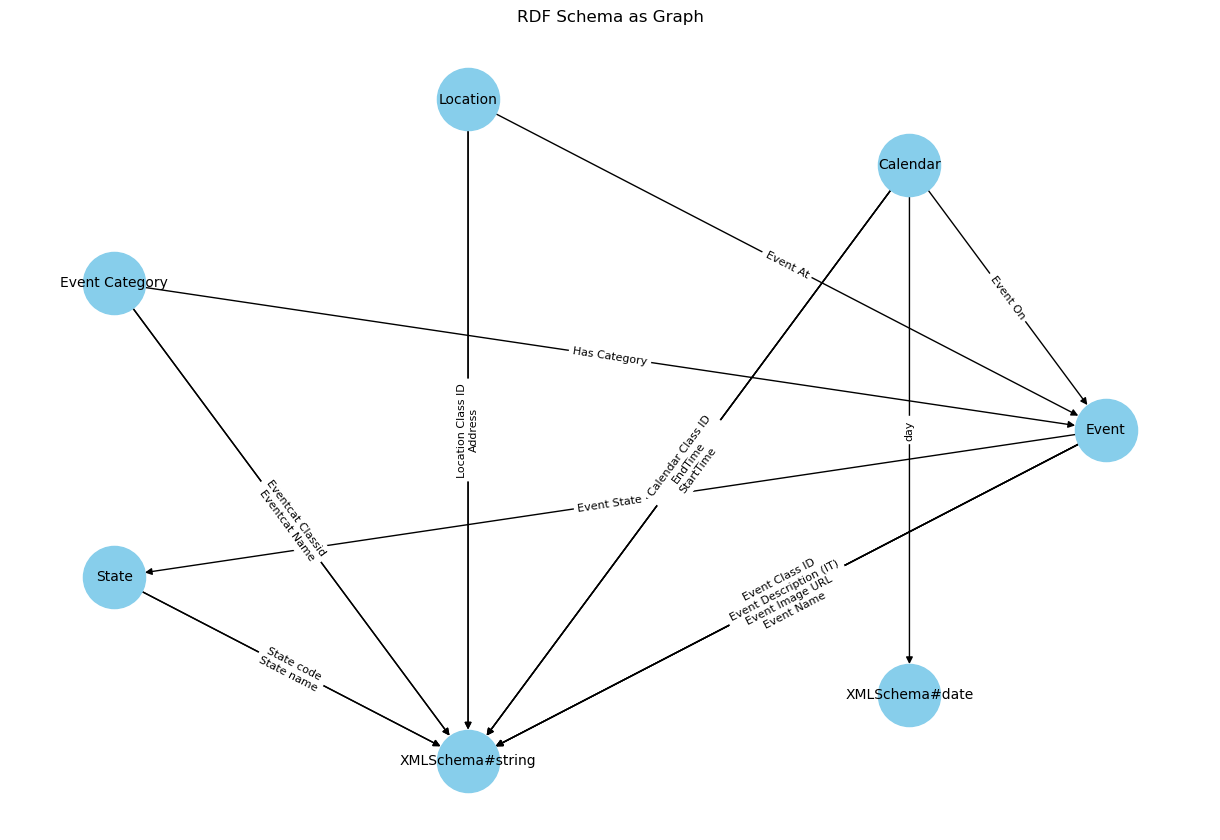

In [ ]:
ttl_graph = Graph()

ttl_graph.parse("only_events.ttl", format="turtle")

G = nx.MultiDiGraph()

for s in ttl_graph.subjects(RDF.type, OWL.Class):
    label = ttl_graph.value(s, RDFS.label)
    G.add_node(str(s), type="Class", label=str(label) if label else s.split("/")[-1])

for s in ttl_graph.subjects(RDF.type, OWL.ObjectProperty):
    domain = ttl_graph.value(s, RDFS.domain)
    range_ = ttl_graph.value(s, RDFS.range)
    label = ttl_graph.value(s, RDFS.label)
    prop_label = str(label) if label else s.split("/")[-1]
    if domain and range_:
        G.add_edge(str(domain), str(range_), type="ObjectProperty", label=prop_label)

for s in ttl_graph.subjects(RDF.type, OWL.DatatypeProperty):
    domain = ttl_graph.value(s, RDFS.domain)
    range_ = ttl_graph.value(s, RDFS.range)
    label = ttl_graph.value(s, RDFS.label)
    prop_label = str(label) if label else s.split("/")[-1]
    if domain:
        G.add_edge(str(domain), str(range_) if range_ else "Literal", type="DatatypeProperty", label=prop_label)

combined_labels = defaultdict(list)
for u, v, k, d in G.edges(data=True, keys=True):
    combined_labels[(u, v)].append(d['label'])

pos = nx.circular_layout(G)
edge_labels = {k: "\n".join(v) for k, v in combined_labels.items()}
node_labels = {n: d.get('label', n.split("/")[-1]) for n, d in G.nodes(data=True)}

plt.figure(figsize=(12, 8))
nx.draw(G, pos, with_labels=True, labels=node_labels, node_size=2000, node_color='skyblue', font_size=10, arrows=True)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
plt.title("RDF Schema as Graph")
plt.show()

In [ ]:
questions_responses = []

def ask_question(question, G, llm):

    class_nodes = [n for n in G.nodes() if not n.startswith("http://www.w3.org/2001/XMLSchema#")]

    prompt = (
        "You are a semantic web expert.\n"
        "Given the following classes in an RDF schema:\n\n"
        + "\n".join(f"- {n.split('/')[-1]}" for n in class_nodes) +
        "\n\nWhich of these classes are relevant for extracting information about:\n"
        f"'{question}'\n\n"
        "Provide only the relevant class names, without any options, explanations, or extra text. List them separated by commas."
    )

    response = llm(prompt, max_tokens=150, temperature=0.2)

    relevant_classes = response.get("text", "").strip()

    questions_responses.append({
        "question": question,
        "response": relevant_classes
    })

    return relevant_classes


In [ ]:
question_1 = "What are the names of the events happen on 2015-12-12?"
ask_question(question_1, G, llm)

Llama.generate: 103 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    7835.56 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    21 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =   19242.13 ms /    22 tokens


''

In [ ]:
def dtt_traverse(graph, start_class, max_depth=2):
    from collections import deque
    visited = set()
    queue = deque([(start_class, 0)])
    collected_properties = []

    while queue:
        current_node, depth = queue.popleft()
        if depth > max_depth or current_node in visited:
            continue
        visited.add(current_node)

        for _, neighbor, key, data in graph.out_edges(current_node, keys=True, data=True):
            property_info = {
                "from": current_node,
                "to": neighbor,
                "label": data.get("label", ""),
                "type": data.get("type", ""),
            }
            collected_properties.append(property_info)
            queue.append((neighbor, depth + 1))

    return collected_properties

In [ ]:
relevant_classes = ["http://example.org/Event", "http://example.org/Calendar, http://example.org/Location"]

In [ ]:
all_collected_props = set()

for cls in relevant_classes:
    props = dtt_traverse(G, cls)
    for prop in props:
        prop_tuple = (prop["from"], prop["to"], prop["label"], prop["type"])
        all_collected_props.add(prop_tuple)

all_collected_props = list(all_collected_props)


#### Upto this point did no change. when provide these classes to the extracing properties, use dictionary format.

In [ ]:
def prepare_property_prompt(question, relevant_classes, all_collected_props):
    # Generate TTL-style class definitions
    class_defs = ""
    for cls in relevant_classes:
        class_uri = cls.split("/")[-1]
        class_defs += f"ex:{class_uri} rdf:type owl:Class ;\n    rdfs:label \"{class_uri}\" .\n\n"
    print(class_defs)
    # Generate TTL-style property definitions from collected props
    prop_defs = ""
    for prop in all_collected_props:
        label = prop[2]
        prop_type = prop[3]
        from_cls = prop[0].split("/")[-1]
        to_cls = prop[1].split("/")[-1]

        if prop_type.lower() == "objectproperty":
            prop_defs += (
                f"ex:{label} rdf:type owl:ObjectProperty ;\n"
                f"    rdfs:domain ex:{from_cls} ;\n"
                f"    rdfs:range ex:{to_cls} ;\n"
                f"    rdfs:label \"{label}\" .\n\n"
            )
        else:
            prop_defs += (
                f"ex:{label} rdf:type owl:DatatypeProperty ;\n"
                f"    rdfs:domain ex:{from_cls} ;\n"
                f"    rdfs:range xsd:string ;\n"
                f"    rdfs:label \"{label}\" .\n\n"
            )
    print(prop_defs)
    # Combine everything into the prompt
    prompt = (
        f"You are a semantic web expert.\n\n"
        f"The following ontology definitions are relevant to the classes:\n\n"
        f"{class_defs}"
        f"{prop_defs}"
        f"Based on these definitions, which properties are relevant for answering the question:\n"
        f"'{question}'\n\n"
        f"List only the property labels, separated by commas, without explanation."
    )

    return prompt

In [ ]:
question_ = "'What are the locations of the events happen on 2015-12-12"


prompt = prepare_property_prompt(question_, relevant_classes, all_collected_props)
response = llm(prompt, max_tokens=150, temperature=0.2)

    #response_text = response['choices'][0]['text']
    #relevant_props = [p.strip() for p in response_text.split(",") if p.strip()]

print(f"Class: {relevant_classes} | Relevant Properties: {response}")

ex:Event rdf:type owl:Class ;
    rdfs:label "Event" .

ex:Location rdf:type owl:Class ;
    rdfs:label "Location" .


ex:Event Class ID rdf:type owl:DatatypeProperty ;
    rdfs:domain ex:Event ;
    rdfs:range xsd:string ;
    rdfs:label "Event Class ID" .

ex:Event Name rdf:type owl:DatatypeProperty ;
    rdfs:domain ex:Event ;
    rdfs:range xsd:string ;
    rdfs:label "Event Name" .

ex:State code rdf:type owl:DatatypeProperty ;
    rdfs:domain ex:State ;
    rdfs:range xsd:string ;
    rdfs:label "State code" .

ex:Event State rdf:type owl:ObjectProperty ;
    rdfs:domain ex:Event ;
    rdfs:range ex:State ;
    rdfs:label "Event State" .

ex:State name rdf:type owl:DatatypeProperty ;
    rdfs:domain ex:State ;
    rdfs:range xsd:string ;
    rdfs:label "State name" .

ex:Event Description (IT) rdf:type owl:DatatypeProperty ;
    rdfs:domain ex:Event ;
    rdfs:range xsd:string ;
    rdfs:label "Event Description (IT)" .

ex:Event Image URL rdf:type owl:DatatypeProperty ;
    rdfs

Llama.generate: 474 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    7835.56 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    16 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =   14539.74 ms /    17 tokens


Class: ['http://example.org/Event', 'http://example.org/Calendar, http://example.org/Location'] | Relevant Properties: {'id': 'cmpl-19081435-32bf-457d-aed2-e139e732d9d7', 'object': 'text_completion', 'created': 1746210473, 'model': 'llama-2-7b-chat.Q8_0.gguf', 'choices': [{'text': '\n\nPlease let me know if you need more information or clarification.', 'index': 0, 'logprobs': None, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 475, 'completion_tokens': 15, 'total_tokens': 490}}


In [ ]:
relevant_classes = ["http://example.org/Event", "http://example.org/Calendar"]

In [ ]:
all_collected_props = set()

for cls in relevant_classes:
    props = dtt_traverse(G, cls)
    for prop in props:
        prop_tuple = (prop["from"], prop["to"], prop["label"], prop["type"])
        all_collected_props.add(prop_tuple)

all_collected_props = list(all_collected_props)


In [ ]:
question_1 = "What are the names of the events happening on 2015-12-12?"


prompt = prepare_property_prompt(question_1, relevant_classes, all_collected_props)
response = llm(prompt, max_tokens=150, temperature=0.2)

    #response_text = response['choices'][0]['text']
    #relevant_props = [p.strip() for p in response_text.split(",") if p.strip()]

print(f"Class: {relevant_classes} | Relevant Properties: {response}")

Llama.generate: 49 prefix-match hit, remaining 669 prompt tokens to eval


ex:Event rdf:type owl:Class ;
    rdfs:label "Event" .

ex:Calendar rdf:type owl:Class ;
    rdfs:label "Calendar" .


ex:Calendar Class ID rdf:type owl:DatatypeProperty ;
    rdfs:domain ex:Calendar ;
    rdfs:range xsd:string ;
    rdfs:label "Calendar Class ID" .

ex:Event Class ID rdf:type owl:DatatypeProperty ;
    rdfs:domain ex:Event ;
    rdfs:range xsd:string ;
    rdfs:label "Event Class ID" .

ex:EndTime rdf:type owl:DatatypeProperty ;
    rdfs:domain ex:Calendar ;
    rdfs:range xsd:string ;
    rdfs:label "EndTime" .

ex:Event Name rdf:type owl:DatatypeProperty ;
    rdfs:domain ex:Event ;
    rdfs:range xsd:string ;
    rdfs:label "Event Name" .

ex:StartTime rdf:type owl:DatatypeProperty ;
    rdfs:domain ex:Calendar ;
    rdfs:range xsd:string ;
    rdfs:label "StartTime" .

ex:State code rdf:type owl:DatatypeProperty ;
    rdfs:domain ex:State ;
    rdfs:range xsd:string ;
    rdfs:label "State code" .

ex:day rdf:type owl:DatatypeProperty ;
    rdfs:domain ex:Calendar

llama_perf_context_print:        load time =    7835.56 ms
llama_perf_context_print: prompt eval time =       0.00 ms /   669 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    23 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =   58633.53 ms /   692 tokens


Class: ['http://example.org/Event', 'http://example.org/Calendar'] | Relevant Properties: {'id': 'cmpl-639eed19-a581-49a5-9450-91ff16e3d2fc', 'object': 'text_completion', 'created': 1746210487, 'model': 'llama-2-7b-chat.Q8_0.gguf', 'choices': [{'text': '\n\nEvent Name, StartTime, EndTime, Event On, Event State, State name, Event Image URL', 'index': 0, 'logprobs': None, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 718, 'completion_tokens': 23, 'total_tokens': 741}}


In [ ]:
relevant_classes = ["http://example.org/Event", "http://example.org/Location","http://example.org/EventCategory"]

In [ ]:
all_collected_props = set()

for cls in relevant_classes:
    props = dtt_traverse(G, cls)
    for prop in props:
        prop_tuple = (prop["from"], prop["to"], prop["label"], prop["type"])
        all_collected_props.add(prop_tuple)

all_collected_props = list(all_collected_props)


In [ ]:
question_2 = "What are the names and addresses of the events belong to 'Kids' category?"


prompt = prepare_property_prompt(question_2, relevant_classes, all_collected_props)
response = llm(prompt, max_tokens=150, temperature=0.2)

    #response_text = response['choices'][0]['text']
    #relevant_props = [p.strip() for p in response_text.split(",") if p.strip()]

print(f"Class: {relevant_classes} | Relevant Properties: {response}")

Llama.generate: 49 prefix-match hit, remaining 747 prompt tokens to eval


ex:Event rdf:type owl:Class ;
    rdfs:label "Event" .

ex:Location rdf:type owl:Class ;
    rdfs:label "Location" .

ex:EventCategory rdf:type owl:Class ;
    rdfs:label "EventCategory" .


ex:Event Class ID rdf:type owl:DatatypeProperty ;
    rdfs:domain ex:Event ;
    rdfs:range xsd:string ;
    rdfs:label "Event Class ID" .

ex:Eventcat Name rdf:type owl:DatatypeProperty ;
    rdfs:domain ex:EventCategory ;
    rdfs:range xsd:string ;
    rdfs:label "Eventcat Name" .

ex:Event Name rdf:type owl:DatatypeProperty ;
    rdfs:domain ex:Event ;
    rdfs:range xsd:string ;
    rdfs:label "Event Name" .

ex:Address rdf:type owl:DatatypeProperty ;
    rdfs:domain ex:Location ;
    rdfs:range xsd:string ;
    rdfs:label "Address" .

ex:Eventcat Classid rdf:type owl:DatatypeProperty ;
    rdfs:domain ex:EventCategory ;
    rdfs:range xsd:string ;
    rdfs:label "Eventcat Classid" .

ex:State code rdf:type owl:DatatypeProperty ;
    rdfs:domain ex:State ;
    rdfs:range xsd:string ;
    rdfs:

llama_perf_context_print:        load time =    7835.56 ms
llama_perf_context_print: prompt eval time =       0.00 ms /   747 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    18 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =   59777.92 ms /   765 tokens


Class: ['http://example.org/Event', 'http://example.org/Location', 'http://example.org/EventCategory'] | Relevant Properties: {'id': 'cmpl-a9275745-aedc-48cd-8928-b4d8de1e5ec1', 'object': 'text_completion', 'created': 1746210546, 'model': 'llama-2-7b-chat.Q8_0.gguf', 'choices': [{'text': '\nEvent Class ID, Event Name, Eventcat Name, State name, Event At.', 'index': 0, 'logprobs': None, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 796, 'completion_tokens': 18, 'total_tokens': 814}}


In [ ]:
question = "What are the names and addresses of the events happening on 2015-12-12?"
classes_involved = {"ex:Event": '''rdf:type owl:Class ;
    rdfs:label "Event" .''',
"ex:Calendar": '''rdf:type owl:Class ;
    rdfs:label "Calendar" .''',
"ex:Location": '''rdf:type owl:Class ;
    rdfs:label "Location" .''',
}
relevant_properties = [
    "Event Name (DatatypeProperty)",
    "Event On (DatatypeProperty)",
    "Event At (ObjectProperty)",
    "Address (DatatypeProperty)",
    "StartTime (DatatypeProperty)",
    "EndTime (DatatypeProperty)"
]

prompt = f"""
You are a semantic web expert. Your task is to write a SPARQL query that answers a user's question using the provided ontology.

Classes involved:
- {', '.join(classes_involved)}

Relevant Properties:
- {', '.join(relevant_properties)}

Here are a few example SPARQL queries to help you understand the format:

### EXAMPLE 1 ###
Question: What are the names and locations of the events that occurred in 2015-10-01?
SPARQL:
PREFIX ex: <http://example.org/>

SELECT ?eventName ?eventLocation
WHERE {{
  ?event a ex:Event ;
         ex:EventName ?eventName ;
         ex:eventon ?calendar ;
         ex:eventat ?eventAt .
  ?eventAt ex:address ?eventLocation .
  ?calendar  ex:start_time ?startTime ;
            ex:end_time ?endTime ;
            ex:day ?eventDate .
  FILTER(?eventDate = "2015-12-03")
}}

### EXAMPLE 2 ###
Question: What are the start and end times of the events happening in 2015-12-03?
SPARQL:
PREFIX ex: <http://example.org/>

SELECT ?eventName ?startTime ?endTime
WHERE {{
  ?event a ex:Event ;
         ex:EventName ?eventName ;
         ex:eventon ?calendar .
  ?calendar ex:start_time ?startTime ;
            ex:end_time ?endTime ;
            ex:day ?eventDate .
  FILTER(?eventDate = "2015-12-03")
}}

Now, please generate the SPARQL query for the user's question: "{question}"

Output:
Provide only the SPARQL query. Use PREFIX ex: <http://example.org/>.

SPARQL:
"""

response = llm(prompt, max_tokens=150, temperature=0.1)
print(response['choices'][0]['text'].strip())


Llama.generate: 499 prefix-match hit, remaining 34 prompt tokens to eval
llama_perf_context_print:        load time =   22856.20 ms
llama_perf_context_print: prompt eval time =       0.00 ms /    34 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /   112 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =  115936.86 ms /   146 tokens


SELECT ?eventName ?eventAddress
WHERE {
  ?event a ex:Event ;
         ex:EventName ?eventName ;
         ex:eventon ?calendar ;
         ?calendar ex:start_time ?startTime ;
            ex:end_time ?endTime ;
            ex:day ?eventDate .
  FILTER(?eventDate = "2015-12-12")
}

Note: Please use the ontology provided to answer the user's question.
